# Traindata 전처리

# JSON -> DataFrame

In [ ]:
import os
import json
import pandas as pd

# 라벨링 JSON 파일이 있는 최상위 폴더 경로
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/라벨링데이터/"

# 실제 WAV 파일이 존재하는 원천 데이터의 최상위 경로
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/원천데이터/"

# 정상적으로 처리된 데이터 정보를 담을 리스트
data = []

# 오류 발생 시 해당 JSON 파일 또는 존재하지 않는 WAV 경로를 저장할 리스트
broken_files = []

# 라벨링 폴더 내부의 모든 JSON 파일을 재귀적으로 탐색
for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if file_name.endswith(".json"):
            # 현재 JSON 파일의 전체 경로 구성
            json_path = os.path.join(folder_path, file_name)
            try:
                # JSON 파일 열기 및 파싱
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                # JSON 내부 정보 추출
                emotion = content["화자정보"]["Emotion"]
                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")
                wav_file = content["파일정보"]["FileName"]

                # 현재 JSON 경로를 라벨 기준 상대경로로 변환
                relative_path = os.path.relpath(folder_path, start=label_root)

                # 상대 경로에서 모든 TL을 TS로 변경
                relative_path = relative_path.replace("TL", "TS")

                # WAV 경로를 원천 데이터 기준으로 재구성
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                # WAV 파일 존재 여부 확인
                if os.path.exists(wav_path):
                    # 정상 데이터 추가
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion,
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    # WAV 파일이 존재하지 않는 경우 로그에 기록
                    print(f"WAV 파일 없음: {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                # JSON 파싱 중 오류 발생 시 기록
                print(f"JSON 읽기 오류: {json_path}: {e}")
                broken_files.append(json_path)

# 정상적으로 수집된 데이터를 DataFrame으로 변환
df = pd.DataFrame(data)

# 결과 CSV 파일로 저장
os.makedirs("./data/usou", exist_ok=True)
df.to_csv("./data/usou/metadata_cleaned.csv", index=False)

# 오류가 발생한 경로들을 텍스트 파일로 저장
with open("./data/usou/broken_files.txt", "w") as f:
    for path in broken_files:
        f.write(path + "\n")

# 최종 처리 결과 출력
print(f"정상 처리된 JSON 수: {len(df)}")
print(f"에러 발생 수: {len(broken_files)}")


# MFCC 추출
-  MFCC 추출이란
    - 음성에서 특징을 뽑아낸 백터
-  데이터 형태
    - 2차원 배열(시간 프레임수, 13)
- 배치
    - 배치 : 전체 데이터를 나누어 처리하는 단위
- 나누는 이유
    - 메모리 부족으로 컴퓨터 프리징 발생





In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

# ============================
# 1. 메타데이터 로드
# ============================
# 사전에 정제된 메타데이터 CSV 파일 경로
csv_path = "/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv"
df = pd.read_csv(csv_path)

# ============================
# 2. 설정값 정의
# ============================
sample_rate = 16000            # 음성 파일 샘플링 레이트 (Hz)
max_duration = 5.0             # WAV 파일 최대 로딩 시간 (초) → 너무 긴 파일 방지
save_interval = 10000          # 몇 개마다 배치로 저장할지 설정

# 저장용 리스트 초기화
mfcc_features = []             # MFCC 벡터 리스트
labels = []                    # 감정 레이블 리스트
error_files = []               # 처리 중 실패한 파일 목록
save_counter = 0               # 배치 저장 인덱스

# 저장 디렉토리 설정
save_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# ============================
# 3. MFCC 추출 루프
# ============================
for idx, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["wav_path"]  # 메타데이터에 포함된 wav 파일 전체 경로
    try:
        # WAV 파일 로딩 (최대 max_duration 초까지만 로드)
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)

        # MFCC 13차원 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # 시간 축 기준으로 전치 (time_step, n_mfcc)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])

    except Exception as e:
        # 에러 발생 시 파일 경로 저장
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    # 일정 수 이상 쌓이면 배치 저장 후 메모리 초기화
    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 남은 데이터가 있다면 마지막 배치 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ============================
# 4. 에러 파일 저장
# ============================
error_log_path = "/media/usou/PortableSSD/mldl_project/data/broken_audio_files.txt"
with open(error_log_path, "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ============================
# 5. 처리 결과 출력
# ============================
print(f"성공적으로 저장된 배치 수: {save_counter + 1}")
print(f"실패한 파일 수: {len(error_files)}")


# 레이블 인코딩

In [ ]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집
# ============================
# label_batch_*.npy 파일 경로 리스트
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 레이블 리스트 생성
all_labels = []
batch_label_data = []  # 배치별 데이터도 임시 저장
for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    batch_label_data.append(labels)
    all_labels.extend(labels)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 인코더 저장 (추후 예측 결과 복원용)
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 레이블 개수: {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"배치 수: {len(label_files)}")
print("레이블 인코딩 및 저장 완료")


# CNN 모델 정의

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    CNN 기반 음성 감정 분류 모델 정의

    Parameters:
        input_shape (tuple): 입력 데이터 형태 (예: (시간축 길이, MFCC 차원 수, 채널 수))
        num_classes (int): 분류할 감정 클래스 수

    Returns:
        tensorflow.keras.Model: 컴파일 완료된 CNN 모델
    """
    model = models.Sequential()

    # 첫 번째 컨볼루션 레이어: 필터 수 32, 커널 사이즈 3x3, 활성화 함수 ReLU
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    # 배치 정규화: 학습 안정성과 속도 개선
    model.add(layers.BatchNormalization())
    # 최대 풀링: 출력 크기 절반으로 줄임 (특징 추출과 과적합 방지)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 컨볼루션 레이어: 필터 수 64
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 세 번째 컨볼루션 레이어: 필터 수 128
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    # 전역 평균 풀링: 전체 피처 맵의 평균을 계산하여 1D 벡터로 변환
    model.add(layers.GlobalAveragePooling2D())

    # 완전 연결층(Dense Layer) 추가
    model.add(layers.Dense(128, activation='relu'))
    # 과적합 방지를 위한 드롭아웃 (30%)
    model.add(layers.Dropout(0.3))
    # 출력층: softmax로 감정 클래스 확률 예측
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일: Adam 옵티마이저, sparse_categorical_crossentropy 손실 함수, 정확도 지표
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Validation 전처리

# 메타데이터 csv로 저장

In [ ]:
import os
import json
import pandas as pd

# ========================================
# 1. 경로 설정
# ========================================

# 라벨링 JSON 파일이 저장된 루트 폴더
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/라벨링데이터/VL1"

# 실제 음성 WAV 파일이 있는 루트 폴더
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1"

# ========================================
# 2. 결과 저장 리스트 초기화
# ========================================
data = []             # 메타데이터 저장용 리스트
broken_files = []     # 에러 발생한 파일 로그용 리스트

# ========================================
# 3. JSON 파일 순회 및 정보 추출
# ========================================
for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if file_name.endswith(".json"):
            json_path = os.path.join(folder_path, file_name)
            try:
                # JSON 파일 열기
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                # 화자 정보에서 감정, 스타일, 세부 감정 추출
                emotion = content["화자정보"]["Emotion"]
                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")

                # WAV 파일 이름 추출
                wav_file = content["파일정보"]["FileName"]

                # 현재 JSON 경로에서 라벨 루트를 기준으로 상대 경로 추출
                relative_path = os.path.relpath(folder_path, start=label_root)

                # 실제 WAV 파일 경로 생성
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                # WAV 파일이 존재하면 메타데이터에 추가
                if os.path.exists(wav_path):
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion,
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    # WAV 파일이 없는 경우 기록
                    print(f"WAV 파일 없음: {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                # JSON 파싱 실패 시 기록
                print(f"JSON 읽기 오류: {json_path}, 에러: {e}")
                broken_files.append(json_path)

# ========================================
# 4. 결과 저장
# ========================================

# DataFrame 생성
df = pd.DataFrame(data)

# 저장 경로 생성
os.makedirs("/media/usou/PortableSSD/mldl_project/data/validation", exist_ok=True)

# 메타데이터 CSV 저장
df.to_csv("/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv", index=False)

# 에러 파일 로그 저장
with open("/media/usou/PortableSSD/mldl_project/data/validation/broken_val_files.txt", "w") as f:
    for path in broken_files:
        f.write(path + "\n")

# 요약 출력
print(f"정상 처리된 JSON 수: {len(df)}")
print(f"에러 발생 수: {len(broken_files)}")


# MFCC 추출 Validation 용

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

# ========================================
# 1. 메타데이터 로드
# ========================================

# validation용 정제된 메타데이터 CSV 경로
csv_path = "/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv"
df = pd.read_csv(csv_path)

# ========================================
# 2. 설정값 정의
# ========================================

sample_rate = 16000             # 음성 샘플링 레이트 (16kHz)
max_duration = 5.0              # WAV 최대 로딩 시간 (초)
save_interval = 10000           # 배치 저장 기준 개수
save_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# 저장용 리스트 초기화
mfcc_features = []              # 추출된 MFCC 벡터 리스트
labels = []                     # 감정 레이블 리스트
error_files = []                # 실패한 파일 목록
save_counter = 0                # 배치 파일 번호

# ========================================
# 3. MFCC 추출 루프
# ========================================

for idx, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = row["wav_path"]

    try:
        # WAV 파일 로딩 (최대 max_duration 초까지만 로드)
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)

        # MFCC 추출 (13차원)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # 시간 축 기준으로 전치 (time_step, 13)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])

    except Exception as e:
        # 로딩 실패 시 에러 출력 및 로그 저장
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    # 일정 개수 이상이면 배치 저장
    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 루프 종료 후 남은 데이터 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ========================================
# 4. 에러 파일 저장
# ========================================

error_log_path = "/media/usou/PortableSSD/mldl_project/data/validation/broken_audio_files_val.txt"
with open(error_log_path, "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ========================================
# 5. 처리 결과 출력
# ========================================

print(f"성공적으로 저장된 배치 수: {save_counter + 1}")
print(f"실패한 파일 수: {len(error_files)}")


# Validation 데이터용 레이블 인코딩

In [ ]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집
# ============================
# label_batch_*.npy 파일 경로 리스트
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 레이블 리스트 생성
all_labels = []
batch_label_data = []  # 배치별 데이터도 임시 저장
for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    batch_label_data.append(labels)
    all_labels.extend(labels)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 인코더 저장 (추후 예측 결과 복원용)
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 레이블 개수: {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"배치 수: {len(label_files)}")
print("레이블 인코딩 및 저장 완료")


# MFCC DataGenerator 클래스 생성

In [ ]:
import os
import numpy as np
import tensorflow as tf

class MFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_dir, prefix, batch_size=1, shuffle=True):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 배치 파일 목록 생성
        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])
        self.indices = list(range(len(self.mfcc_files)))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mfccs = []
        batch_labels = []

        for idx in batch_indices:
            mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
            label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

            mfcc_data = np.load(mfcc_path, allow_pickle=True)
            label_data = np.load(label_path)

            # 가장 긴 시퀀스 기준으로 padding
            max_len = max([x.shape[0] for x in mfcc_data])
            padded = tf.keras.preprocessing.sequence.pad_sequences(mfcc_data, maxlen=max_len, dtype='float32', padding='post')
            padded = np.expand_dims(padded, -1)  # (batch, time, n_mfcc, 1)

            batch_mfccs.append(padded)
            batch_labels.append(label_data)

        X = np.concatenate(batch_mfccs, axis=0)
        y = np.concatenate(batch_labels, axis=0)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# GPU 활성화 및 안정 설정 코드

In [ ]:
import tensorflow as tf

# 1. GPU 장치 목록 출력
gpus = tf.config.list_physical_devices('GPU')
print("사용 가능한 GPU:", gpus)

# 2. 메모리 자동 증가 설정 (안정성을 위해 권장)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✔ GPU 메모리 자동 증가 설정 완료")
    except RuntimeError as e:
        print("⚠ 메모리 설정 중 오류 발생:", e)
else:
    print("❌ GPU를 찾을 수 없습니다. CPU로 진행됩니다.")


# label_encoder.pkl을 로드해 동일하게 인코딩하는 코드

In [ ]:
import os
import numpy as np
import glob
import pickle

# ============================
# 1. 설정
# ============================
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
encoded_label_dir = os.path.join(val_label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# 학습 데이터에서 저장한 LabelEncoder 로드
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# ============================
# 2. 모든 validation 레이블 수집
# ============================
label_files = sorted(glob.glob(os.path.join(val_label_dir, "label_batch_*.npy")))

for i, label_file in enumerate(label_files):
    labels = np.load(label_file, allow_pickle=True)
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"✅ Validation 레이블 인코딩 및 저장 완료 (배치 수: {len(label_files)})")


# CNN 모델 정의

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    CNN 기반 음성 감정 분류 모델 정의

    Parameters:
        input_shape (tuple): 입력 데이터 형태 (예: (시간축 길이, MFCC 차원 수, 채널 수))
        num_classes (int): 분류할 감정 클래스 수

    Returns:
        tensorflow.keras.Model: 컴파일 완료된 CNN 모델
    """
    model = models.Sequential()

    # [1] 첫 번째 컨볼루션 블록
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())               # 학습 안정성 향상
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))     # 공간 크기 감소

    # [2] 두 번째 컨볼루션 블록
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # [3] 세 번째 컨볼루션 블록
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())           # 피처맵 전체 평균값

    # [4] 완전 연결층 + 드롭아웃
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))                       # 과적합 방지

    # [5] 출력층 - 클래스 수만큼 softmax 출력
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 학습

In [ ]:
import tensorflow as tf

# ============================
# 1. 데이터 제너레이터 생성
# ============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 안정 위해 소량으로 시작
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ============================
# 2. 클래스 수 설정
# ============================
import pickle

# 학습 데이터의 레이블 인코더를 불러와 클래스 수 확인
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 3. 입력 형태 설정
# ============================
# 예시 입력 크기 지정 (임의 값, 실제 학습 데이터 확인 후 조정 가능)
# 이 부분은 train_generator[0][0].shape 로 확인 가능
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# ============================
# 4. 모델 생성 및 요약
# ============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ============================
# 5. 콜백 정의 (모델 저장 및 EarlyStopping)
# ============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ============================
# 6. 학습 실행
# ============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


- 학습 실패한 이유 
- Conv2D 커널이 너무 커서 작은 입력에 비해 작동을 못함 - kernel size 축소 or padding ="same" 적용 -> 모델 재정의

# 안정적인 CNN 모델 정의

In [ ]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    음성 감정 분류를 위한 CNN 모델 정의
    
    Parameters:
        input_shape (tuple): 입력 데이터의 형태 (시간축, MFCC 차원, 채널 수)
        num_classes (int): 분류할 감정 클래스 수
        
    Returns:
        keras.models.Sequential: 컴파일된 모델 객체
    """

    model = models.Sequential()

    # ===============================
    # [1] 첫 번째 컨볼루션 블록
    # ===============================
    # Conv2D: 32개의 필터, 3x3 커널, relu 활성화 함수 사용
    # padding='same'으로 출력 크기 감소 방지
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())  # 정규화로 학습 안정화
    model.add(layers.MaxPooling2D((2, 2)))  # 출력 크기 절반으로 축소

    # ===============================
    # [2] 두 번째 컨볼루션 블록
    # ===============================
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # ===============================
    # [3] 세 번째 컨볼루션 블록
    # ===============================
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # GlobalAveragePooling2D: 각 채널의 평균을 취해 1D 벡터로 변환
    model.add(layers.GlobalAveragePooling2D())

    # ===============================
    # [4] 완전 연결층 + 출력층
    # ===============================
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # 과적합 방지
    model.add(layers.Dense(num_classes, activation='softmax'))  # 감정 클래스 확률 출력

    # ===============================
    # [5] 모델 컴파일
    # ===============================
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# 학습
- 학습 도중 시스템이 멈추지 않도록 작은 배치 크기와 적절한 콜백 설정 포함

In [ ]:
import os
import pickle
import tensorflow as tf

# ============================
# 1. 데이터 제너레이터 생성
# ============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 절약을 위한 작은 배치
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ============================
# 2. 레이블 인코더 로드 및 클래스 수 설정
# ============================
# 학습 데이터용 레이블 인코더를 통해 클래스 수 파악
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 3. 입력 형태 설정
# ============================
# 첫 배치에서 입력 형태 파악
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# ============================
# 4. 모델 생성
# ============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ============================
# 5. 콜백 설정
# ============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ============================
# 6. 학습 실행
# ============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


- GPU 메모리 부족

# 모델 경량화 프루닝 라이브러리 및 모델 정의

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, models

def create_pruned_cnn_model(input_shape, num_classes):
    # 프루닝 설정: 가중치의 50%를 0으로 만듦 (비율은 조절 가능)
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.5,
            begin_step=0,
            end_step=1000  # 조절 가능
        )
    }

    model = models.Sequential()

    # 첫 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 두 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(64, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 세 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(128, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # 밀집층
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(128, activation='relu'),
        **pruning_params
    ))
    model.add(layers.Dropout(0.3))
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(num_classes, activation='softmax'),
        **pruning_params
    ))

    # 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, models

def create_pruned_cnn_model(input_shape, num_classes):
    # 프루닝 설정: 가중치의 50%를 0으로 만듦 (비율은 조절 가능)
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.5,
            begin_step=0,
            end_step=1000  # 조절 가능
        )
    }

    model = models.Sequential()

    # 첫 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 두 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(64, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 세 번째 블록
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(128, (3, 3), activation='relu'),
        **pruning_params
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # 밀집층
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(128, activation='relu'),
        **pruning_params
    ))
    model.add(layers.Dropout(0.3))
    model.add(tfmot.sparsity.keras.prune_low_magnitude(
        layers.Dense(num_classes, activation='softmax'),
        **pruning_params
    ))

    # 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


- 프루닝 실패
1. Sequential 모델 안에 잘못된 레이어 구조를 넣었거나

2. 프루닝 대상에 이미 프루닝된 레이어를 다시 적용하려고 하거나

3. 모델 구조에서 무한 루프가 생겼거나

4. 너무 많은 프루닝 wrapper가 중첩된 경우



# 여기서 부터 

# MFCCDataGenerator 클래스
- tf.keras.utils.Sequence를 상속받아, 저장된 MFCC 및 레이블 배치 데이터를 Keras 모델 학습에 적합하게 동적으로 불러오고 전처리해주는 제너레이터

In [ ]:
import os
import numpy as np
import tensorflow as tf

class MFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_dir, prefix, batch_size=1, shuffle=True):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 배치 리스트 구성
        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])
        self.indices = list(range(len(self.mfcc_files)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        # 현재 배치 인덱스 범위 계산
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_mfccs = []
        batch_labels = []

        for idx in batch_indices:
            mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
            label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

            mfcc_data = np.load(mfcc_path, allow_pickle=True)
            label_data = np.load(label_path)

            # 시퀀스 길이 맞추기 (Zero-padding)
            max_len = max([x.shape[0] for x in mfcc_data])
            padded = tf.keras.preprocessing.sequence.pad_sequences(mfcc_data, maxlen=max_len, dtype='float32', padding='post')
            padded = np.expand_dims(padded, -1)  # CNN 입력 형식 맞추기

            batch_mfccs.append(padded)
            batch_labels.append(label_data)

        X = np.concatenate(batch_mfccs, axis=0)
        y = np.concatenate(batch_labels, axis=0)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# 음성 감정 분류를 위한 CNN 모델을 정의한 함수

In [ ]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    음성 감정 인식을 위한 CNN 모델 정의
    - 입력: MFCC 시퀀스 (batch, time, n_mfcc, 1)
    - 출력: 감정 클래스 확률 (softmax)
    """

    model = models.Sequential()

    # [1] 첫 번째 컨볼루션 블록
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # [2] 두 번째 컨볼루션 블록
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # [3] 세 번째 컨볼루션 블록
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())  # 피처맵 전체 평균값

    # [4] 완전 연결층
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))  # 감정 클래스 개수만큼 출력

    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# 학습

In [ ]:
import os
import pickle
import tensorflow as tf

# ===============================
# [0] GPU 메모리 설정 (OOM 방지)
# ===============================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("❌ RuntimeError:", e)

# ===============================
# [1] 데이터 제너레이터 생성
# ===============================
train_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches",
    prefix="mfcc",
    batch_size=1  # 메모리 안전 위해 최소 배치
)

val_generator = MFCCDataGenerator(
    batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches",
    prefix="mfcc",
    batch_size=1
)

# ===============================
# [2] 레이블 인코더 로드 및 클래스 수
# ===============================
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ===============================
# [3] 입력 형태 확인
# ===============================
sample_input = train_generator[0][0]  # shape: (batch, time, n_mfcc, 1)
input_shape = sample_input.shape[1:]

# ===============================
# [4] 모델 생성
# ===============================
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ===============================
# [5] 콜백 설정 (모델 저장 + 조기 종료)
# ===============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# ===============================
# [6] 모델 학습
# ===============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


# 모델 변경  PyTorch 기반 간단한 CNN 모델 예시

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


 # 데이터 로더 정의 (PyTorch용)

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os

class MFCCDataset(Dataset):
    def __init__(self, batch_dir, prefix):
        self.batch_dir = batch_dir
        self.prefix = prefix

        self.mfcc_files = sorted([
            f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")
        ])

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
        label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

        # 여기서도 배치 데이터임
        mfcc_batch = np.load(mfcc_path, allow_pickle=True)
        label_batch = np.load(label_path)

        # 리스트로 묶어서 반환 (collate_fn에서 처리)
        return list(zip(mfcc_batch, label_batch))


# collate_fn 추가 (패딩과 텐서 변환)

In [ ]:
def collate_fn(batch):
    batch = sum(batch, [])  # [(mfcc1, label1), ..., (mfccN, labelN)]로 평탄화
    seq_lens = [x[0].shape[0] for x in batch]
    max_len = max(seq_lens)
    n_mfcc = batch[0][0].shape[1]

    padded_mfccs = []
    labels = []

    for mfcc, label in batch:
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:mfcc.shape[0], :] = mfcc
        padded_mfccs.append(padded)
        labels.append(label)

    X = torch.tensor(padded_mfccs).unsqueeze(1)  # (batch, 1, time, n_mfcc)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# DataLoader 생성

In [ ]:
train_dataset = MFCCDataset("/media/usou/PortableSSD/mldl_project/data/mfcc_batches", "mfcc")
val_dataset = MFCCDataset("/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches", "mfcc")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# 모델 학습

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# ============================
# 0. 기본 설정
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

num_classes = len(label_encoder.classes_)
model = AudioEmotionCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# ============================
# 1. 학습 루프
# ============================
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ============================
    # 2. 검증 루프
    # ============================
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_acc = val_correct / val_total
    print(f"🔵 Epoch {epoch+1}: Val Acc: {val_acc:.4f}")

    # ============================
    # 3. 모델 저장
    # ============================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved with Val Acc: {val_acc:.4f}")

print("✅ 학습 완료")


- 에러 :  배치 안의 샘플들이 시퀀스 길이(time step)가 서로 달라서 torch.stack() 실패.
PyTorch DataLoader는 collate_fn이 내부에서 torch.stack()을 사용하기 때문에, 입력 데이터들 크기가 다르면 에러가 납니다.
TensorFlow에서는 padding으로 해결됐던 부분

- 해결 방안 : 배치 크기를 맞추는 collate_fn 함수 구현
    - collate_fn을 사용하여 배치 내 데이터 크기를 맞추는 방법을 추가

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import pickle

# ============================
# 0. 기본 설정
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ============================
# 1. 레이블 인코더 로드 및 클래스 수 확인
# ============================
with open("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)

# ============================
# 2. 데이터셋 클래스 정의
# ============================
class MFCCDataset(Dataset):
    def __init__(self, batch_dir, prefix):
        self.batch_dir = batch_dir
        self.prefix = prefix
        self.mfcc_files = sorted([f for f in os.listdir(batch_dir) if f.startswith(f"{prefix}_batch_")])

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        mfcc_path = os.path.join(self.batch_dir, f"{self.prefix}_batch_{idx}.npy")
        label_path = os.path.join(self.batch_dir, "encoded_labels", f"label_batch_{idx}.npy")

        mfcc_data = np.load(mfcc_path, allow_pickle=True)
        label_data = np.load(label_path)

        # 리스트 형태일 경우 numpy 배열로 변환
        if isinstance(mfcc_data, list):
            mfcc_data = np.array(mfcc_data)

        # 2D 배열인지 확인 (time, n_mfcc)
        if mfcc_data.ndim != 2:
            raise ValueError(f"[{mfcc_path}] shape 오류: (time, n_mfcc) 형식이 아님 → 실제 shape: {mfcc_data.shape}")

        return mfcc_data, label_data


# 패딩을 위한 collate_fn 정의
def collate_fn(batch):
    # 각 샘플은 (sequence_len, n_mfcc)
    seq_lens = [sample[0].shape[0] for sample in batch]
    max_len = max(seq_lens)

    padded_batch = []
    labels = []

    for mfcc_data, label_data in batch:
        # mfcc_data shape: (time, n_mfcc)
        time_len = mfcc_data.shape[0]
        n_mfcc = mfcc_data.shape[1]

        # (time, n_mfcc) → (max_len, n_mfcc)
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:time_len, :] = mfcc_data

        padded_batch.append(padded)
        labels.append(label_data)

    # (batch, 1, time, n_mfcc)
    X = torch.tensor(padded_batch).unsqueeze(1)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# 데이터셋 로딩
train_dataset = MFCCDataset(batch_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches", prefix="mfcc")
val_dataset = MFCCDataset(batch_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches", prefix="mfcc")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# ============================
# 3. 모델 정의
# ============================
class AudioEmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 모델과 손실 함수, 옵티마이저 설정
model = AudioEmotionCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# ============================
# 4. 학습 루프
# ============================
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ============================
    # 5. 검증 루프
    # ============================
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

    val_acc = val_correct / val_total
    print(f"🔵 Epoch {epoch+1}: Val Acc: {val_acc:.4f}")

    # ============================
    # 6. 모델 저장
    # ============================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved with Val Acc: {val_acc:.4f}")

print("✅ 학습 완료")


- 에러
allow_pickle=True 옵션으로 불러온 데이터를 np.load() 하면, 원래는 List[np.ndarray] 혹은 (time, n_mfcc) 구조여야 합니다.

만약 이전에 이 mfcc_batch_1.npy를 배치 단위 리스트 형태로 저장했었다면:

지금처럼 __getitem__에서 개별 .npy를 꺼낼 경우 배치 전체가 한 개의 1D 배열로 저장되어 있을 수 있습니다.

- 해결 방법: 각 샘플을 개별 .npy 파일로 저장

In [ ]:
import numpy as np
import os

# 원본 다중샘플 npy 경로
input_path = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/mfcc_batch_1.npy"

# 저장할 경로
output_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples"
os.makedirs(output_dir, exist_ok=True)

# 데이터 로드
data = np.load(input_path, allow_pickle=True)

# 각 샘플 저장
for i, sample in enumerate(data):
    save_path = os.path.join(output_dir, f"sample_{i:04d}.npy")
    np.save(save_path, sample)

print(f"✅ 총 {len(data)}개 샘플 저장 완료: {output_dir}")


# 레이블 분할 저장 코드

In [ ]:
import numpy as np
import os

# 레이블 경로
label_path = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels/label_batch_1.npy"
labels = np.load(label_path)

# 저장할 디렉토리
label_output_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels"
os.makedirs(label_output_dir, exist_ok=True)

# 분할 저장
for i, label in enumerate(labels):
    save_path = os.path.join(label_output_dir, f"label_{i:04d}.npy")
    np.save(save_path, label)

print(f"✅ 총 {len(labels)}개 레이블 저장 완료: {label_output_dir}")


# MFCCSampleDataset 정의 (샘플 단위)

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import os
import torch

class MFCCSampleDataset(Dataset):
    def __init__(self, sample_dir, label_dir):
        self.sample_paths = sorted([
            os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        mfcc = np.load(self.sample_paths[idx])          # shape: (time, n_mfcc)
        label = np.load(self.label_paths[idx])          # shape: ()

        # 텐서로 변환 (채널 추가)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # (1, time, n_mfcc)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mfcc_tensor, label_tensor


# collate_fn 정의

In [ ]:
def collate_fn(batch):
    seq_lens = [x[0].shape[0] for x in batch]
    max_len = max(seq_lens)

    # n_mfcc 추정 시 더 안전하게
    n_mfcc = None
    for mfcc_data, _ in batch:
        if isinstance(mfcc_data, np.ndarray) and mfcc_data.ndim == 2:
            n_mfcc = mfcc_data.shape[1]
            break

    if n_mfcc is None:
        raise ValueError("모든 샘플에서 유효한 2D MFCC 데이터를 찾을 수 없습니다.")

    padded_batch = []
    labels = []

    for mfcc_data, label_data in batch:
        time_len = mfcc_data.shape[0]
        padded = np.zeros((max_len, n_mfcc), dtype=np.float32)
        padded[:time_len, :] = mfcc_data
        padded_batch.append(padded)
        labels.append(label_data)

    X = torch.tensor(padded_batch).unsqueeze(1)  # (batch, 1, time, n_mfcc)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y


# DataLoader 생성

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


#  기본 설정 및 모델 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 모델 정의 (이전에 정의한 AudioEmotionCNN 사용)
model = AudioEmotionCNN(num_classes=8).to(device)  # 클래스 수에 맞게 수정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30


# 학습 루프

In [ ]:
best_val_acc = 0.0
save_path = "/media/usou/PortableSSD/mldl_project/models/best_model_pt.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    train_acc = correct / total
    print(f"🟢 Epoch {epoch+1}: Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")


# Tensorflow 로 변경

# 1. 샘플 단위 .npy 파일을 위한 DataGenerator 정의

In [ ]:
import os
import numpy as np
import tensorflow as tf

class SampleMFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_dir, label_dir, batch_size=32, shuffle=True):
        self.mfcc_paths = sorted([
            os.path.join(mfcc_dir, f) for f in os.listdir(mfcc_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []

        for i in batch_indices:
            mfcc = np.load(self.mfcc_paths[i])  # (time, n_mfcc)
            label = np.load(self.label_paths[i])  # 정수 인코딩 레이블

            X.append(mfcc)
            y.append(label)

        # Zero-padding
        max_len = max(x.shape[0] for x in X)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(
            X, maxlen=max_len, padding='post', dtype='float32'
        )
        X_pad = np.expand_dims(X_pad, -1)  # (batch, time, n_mfcc, 1)
        y = np.array(y)

        return X_pad, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# CNN 모델 정의

In [ ]:
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# 2.1  validation 데이터도 split 

In [ ]:
import numpy as np
import os

val_input_path = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/mfcc_batch_0.npy"
val_label_path = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/label_batch_0.npy"

# 저장할 폴더
val_sample_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples"
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels"
os.makedirs(val_sample_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# 데이터 로드
mfcc_data = np.load(val_input_path, allow_pickle=True)
label_data = np.load(val_label_path)

# 저장
for i, (sample, label) in enumerate(zip(mfcc_data, label_data)):
    np.save(os.path.join(val_sample_dir, f"sample_{i:04d}.npy"), sample)
    np.save(os.path.join(val_label_dir, f"label_{i:04d}.npy"), label)

print(f"✅ validation용 {len(mfcc_data)}개 샘플 및 레이블 저장 완료")


# 3. 콜백 설정 및 모델 학습

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ===============================
# [1] 학습 및 검증용 DataGenerator 정의
# ===============================
train_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels",
    batch_size=8
)

val_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels",
    batch_size=8
)

# ===============================
# [2] 입력 형태 확인 및 모델 생성
# ===============================
sample_input, _ = train_generator[0]
input_shape = sample_input.shape[1:]  # (time, n_mfcc, 1)

# 클래스 수 확인
import glob
label_paths = sorted(glob.glob("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels/*.npy"))
all_labels = [int(np.load(p)) for p in label_paths]
num_classes = len(set(all_labels))

model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# ===============================
# [3] 콜백 설정
# ===============================
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_tf.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

# GPU 초기화를 위한 예열용 더미 실행 (CPU에서 실행)
with tf.device("/CPU:0"):
    model(tf.random.normal((1,) + input_shape))

# ===============================
# [4] 모델 학습 실행
# ===============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

print("✅ 모델 학습 완료 및 저장 완료")


# gpu 사용 확인

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# cpu로 학습 시도

In [ ]:
# 0. GPU 완전 비활성화 (가장 먼저 실행)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 1. 필수 라이브러리 임포트
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
import glob

# 2. 사용자 정의 DataGenerator
class SampleMFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_dir, label_dir, batch_size=32, shuffle=True):
        self.mfcc_paths = sorted([
            os.path.join(mfcc_dir, f) for f in os.listdir(mfcc_dir) if f.endswith(".npy")
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".npy")
        ])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mfcc = [np.load(self.mfcc_paths[i]) for i in batch_indexes]
        batch_label = [np.load(self.label_paths[i]).item() for i in batch_indexes]  # .item() 추가

        batch_mfcc = [np.expand_dims(x, axis=-1) for x in batch_mfcc]  # (time, n_mfcc, 1)

        max_len = max(x.shape[0] for x in batch_mfcc)
        padded_mfcc = np.array([
            np.pad(x, ((0, max_len - x.shape[0]), (0, 0), (0, 0)), mode='constant')
            for x in batch_mfcc
        ])

        labels = np.array(batch_label, dtype=np.int32)
        return padded_mfcc, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 3. CNN 모델 생성 함수
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. DataGenerator 설정
train_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels",
    batch_size=8
)

val_generator = SampleMFCCDataGenerator(
    mfcc_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_samples",
    label_dir="/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/split_labels",
    batch_size=8
)

# 5. 입력 형상 및 클래스 수 확인
sample_input, _ = train_generator[0]
input_shape = sample_input.shape[1:]

label_paths = sorted(glob.glob("/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_labels/*.npy"))
all_labels = [np.load(p).item() for p in label_paths]  # .item()으로 스칼라 추출
num_classes = len(set(all_labels))
print(f"클래스 수: {num_classes}")

# 6. 모델 생성 및 콜백 설정
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_tf.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 7. 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

print("모델 학습 완료 및 저장 완료")


# 머신 러닝 시도
## 작업 순서
1. 데이터 로딩 및 통합
    - metadata_cleaned (train)
    - metadata_cleaned_val (validation)

2. 특징(X)과 레이블(y) 분리
    - MFCC는 X
    - 감정 레이블은 y

3. 레이블 인코딩
    - 문자열 레이블(Happy, Sad 등)을 숫자로 변환

4. 머신러닝 모델 선택 및 학습
    - 예: RandomForestClassifier, SVC, GradientBoosting, LogisticRegression

5. 검증 및 평가
    - accuracy_score, classification_report, confusion_matrix

# 데이터 로딩 및 통합

In [ ]:
import numpy as np
import os
from glob import glob

# 경로
train_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/metadata_cleaned"
val_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/metadata_cleaned_val"

# 파일 불러오기
train_mfcc_paths = sorted(glob(os.path.join(train_dir, "*.npy")))
val_mfcc_paths = sorted(glob(os.path.join(val_dir, "*.npy")))

# 데이터 로딩
train_data = [np.load(f, allow_pickle=True).item() for f in train_mfcc_paths]
val_data = [np.load(f, allow_pickle=True).item() for f in val_mfcc_paths]

# 분리
X_train = [d["mfcc"] for d in train_data]
y_train = [d["emotion"] for d in train_data]

X_val = [d["mfcc"] for d in val_data]
y_val = [d["emotion"] for d in val_data]


# 특징(X)과 레이블(y) 분리

In [ ]:
import pandas as pd

# 학습용 데이터 로딩
train_path = "/media/usou/PortableSSD/mldl_project/data/metadata_cleaned.csv"
metadata_cleaned = pd.read_csv(train_path)

# 검증용 데이터 로딩
val_path = "/media/usou/PortableSSD/mldl_project/data/validation/metadata_cleaned_val.csv"
metadata_cleaned_val = pd.read_csv(val_path)

# X: MFCC 특징, y: 감정 레이블
X_train = metadata_cleaned["mfcc"]
y_train = metadata_cleaned["emotion"]

X_val = metadata_cleaned_val["mfcc"]
y_val = metadata_cleaned_val["emotion"]


In [ ]:
print(metadata_cleaned.columns)


In [ ]:
base_mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/split_samples"

def load_mfcc_from_path(path_series):
    mfcc_list = []
    for rel_path in path_series:
        fname = os.path.splitext(os.path.basename(rel_path))[0]
        mfcc_path = os.path.join(base_mfcc_dir, f"{fname}.npy")
        if not os.path.exists(mfcc_path):
            print(f"⚠️ 누락된 MFCC 파일: {mfcc_path}")
            continue
        mfcc = np.load(mfcc_path)
        mfcc_list.append(mfcc.flatten())  # 머신러닝용 1D 벡터로
    return np.array(mfcc_list)


In [ ]:
# X (특징) 로딩
X_train = load_mfcc_from_path(metadata_cleaned["wav_path"])
X_val = load_mfcc_from_path(metadata_cleaned_val["wav_path"])

# y (레이블) 추출
y_train = metadata_cleaned["emotion"].values
y_val = metadata_cleaned_val["emotion"].values


# MFCC 추출 이후 부터 딥러닝 다시 

## 데이터 로딩 및 전처리 

In [ ]:
import numpy as np
import os
from glob import glob

# 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 파일 경로 정렬
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 로딩
X_raw = [np.load(p, allow_pickle=True) for p in mfcc_paths]
y_raw = [np.load(p) for p in label_paths]

# 리스트로 되어 있는 MFCC들을 한 리스트로 합치기
X_all = [sample for batch in X_raw for sample in batch]
y_all = np.concatenate(y_raw)

print(f"총 MFCC 샘플 수: {len(X_all)}")
print(f"총 레이블 수: {len(y_all)}")


# MFCC 샘플 길이 정규화(패딩)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# MFCC의 각 샘플은 (time, 13) 형태 → 시퀀스 길이 맞추기
max_len = max([x.shape[0] for x in X_all])
print("가장 긴 MFCC 시퀀스 길이:", max_len)

# (샘플 수, time, n_mfcc)
X_padded = pad_sequences(X_all, maxlen=max_len, padding='post', dtype='float32')
print("패딩된 X shape:", X_padded.shape)

# 마지막 차원을 명시적으로 추가: (샘플 수, time, n_mfcc, 1)
X_padded = np.expand_dims(X_padded, -1)


In [ ]:
# 검증용 MFCC 데이터 로딩
val_mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches"
val_label_dir = "/media/usou/PortableSSD/mldl_project/data/validation/mfcc_batches/encoded_labels"

val_mfcc_paths = sorted(glob(os.path.join(val_mfcc_dir, "mfcc_batch_*.npy")))
val_label_paths = sorted(glob(os.path.join(val_label_dir, "label_batch_*.npy")))

X_val_raw = [np.load(p, allow_pickle=True) for p in val_mfcc_paths]
y_val_raw = [np.load(p) for p in val_label_paths]

X_val_all = [sample for batch in X_val_raw for sample in batch]
y_val = np.concatenate(y_val_raw)

print(f"검증용 MFCC 샘플 수: {len(X_val_all)}")
print(f"검증용 레이블 수: {len(y_val)}")


# CNN 기반 모델 정의

In [ ]:
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
input_shape = X_padded.shape[1:]  # (157, 13, 1)
num_classes = len(np.unique(y_all))

model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model.summary()


# 콜백 설정 & 모델 학습 준비

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 저장 경로
checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_cnn.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


# 학습

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=30,
    callbacks=callbacks
)


# 커널 재시작 후

In [ ]:
# 1. MFCC 및 레이블 로딩
import numpy as np
import os
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 경로
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 데이터 로딩
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))
X_raw = [np.load(p, allow_pickle=True) for p in mfcc_paths]
y_raw = [np.load(p) for p in label_paths]

X_all = [sample for batch in X_raw for sample in batch]
y_all = np.concatenate(y_raw)

# 시퀀스 패딩
max_len = 157  # 고정
X_padded = pad_sequences(X_all, maxlen=max_len, padding='post', dtype='float32')
X_padded = np.expand_dims(X_padded, -1)

# 훈련/검증 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y_all, test_size=0.12, random_state=42, stratify=y_all
)

print("✅ 데이터 준비 완료")


- 이 상황은 매우 자주 발생하는 Jupyter Notebook의 커널 메모리 한계 문제

- 위 방법으로 해결 예저
1. generator 정의
2. gc.collect()
3. model.fit(generator, validation_data=(X_val, y_val))



# 배치 제너레이터 정의(훈련용)

In [ ]:
import numpy as np
import tensorflow as tf  # ✅ 반드시 필요


In [ ]:
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.mfcc_paths = mfcc_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.max_len = max_len
        self.shuffle = shuffle
        self.indices = np.arange(len(self.mfcc_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mfcc_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []

        for i in batch_idx:
            mfcc = np.load(self.mfcc_paths[i], allow_pickle=True)
            label = np.load(self.label_paths[i])

            # 유효한 MFCC만 처리
            if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
                padded = tf.keras.preprocessing.sequence.pad_sequences(
                    [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
                )[0]
                X_batch.append(padded)
                y_batch.append(label)

        X_batch = np.expand_dims(np.array(X_batch), -1)  # (batch, time, n_mfcc, 1)
        y_batch = np.array(y_batch)

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# 제너레이터 생성 및 모델 학습

In [ ]:
import gc
import tensorflow as tf

# 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

from glob import glob
import os

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 학습용 제너레이터
train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=64, max_len=157, shuffle=True)

# 가비지 컬렉션 실행 (메모리 확보)
gc.collect()

from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 모델 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)


# 콜백 정의
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 검증용 데이터는 메모리 적재 방식으로 유지
# 이 부분은 이전에 분리한 X_val, y_val을 사용해야 합니다
# 혹시 없다면 validation set 따로 만들 수 있도록 알려주세요

In [ ]:
# 전체 레이블 로딩
all_labels = [np.load(p) for p in label_paths]
y_all = np.concatenate(all_labels)

# 전체 MFCC 로딩 (메모리 작은 검증셋만 로딩)
val_size = 112157  # 예: 전체의 약 13%
X_val_paths = mfcc_paths[-val_size:]
y_val_paths = label_paths[-val_size:]

# 검증 데이터 로딩
X_val_list = []
for path in X_val_paths:
    mfcc = np.load(path, allow_pickle=True)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        [mfcc], maxlen=157, padding='post', dtype='float32'
    )[0]
    X_val_list.append(padded)

X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.concatenate([np.load(p) for p in y_val_paths])


In [ ]:
X_val_list = []
valid_y_list = []

for mfcc_path, label_path in zip(X_val_paths, y_val_paths):
    mfcc = np.load(mfcc_path, allow_pickle=True)
    
    # (time, 13) 형식인지 확인
    if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [mfcc], maxlen=157, padding='post', dtype='float32'
        )[0]
        X_val_list.append(padded)

        label = np.load(label_path)
        valid_y_list.append(label)
    else:
        print("❌ 잘못된 MFCC:", mfcc_path)

# 최종 배열로 변환
X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.array(valid_y_list)

print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)


In [ ]:
import numpy as np
import tensorflow as tf
from glob import glob
import os

# 경로
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

# 배치 파일 리스트
mfcc_batch_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_batch_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 검증용 비율 기준으로 뒤에서 N개 배치만 선택
val_batch_count = 10  # 예: 마지막 10개 배치만 사용
X_val_list = []
y_val_list = []

for mfcc_batch_path, label_batch_path in zip(mfcc_batch_paths[-val_batch_count:], label_batch_paths[-val_batch_count:]):
    mfcc_batch = np.load(mfcc_batch_path, allow_pickle=True)
    label_batch = np.load(label_batch_path)

    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=157, padding='post', dtype='float32'
            )[0]
            X_val_list.append(padded)
            y_val_list.append(label)

# 배열로 변환
X_val = np.expand_dims(np.array(X_val_list), -1)
y_val = np.array(y_val_list)

print("✅ 검증용 X shape:", X_val.shape)
print("✅ 검증용 y shape:", y_val.shape)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),  # 이 부분이 메모리에 있어야 해요!
    epochs=30,
    callbacks=callbacks
)


# 다시 정리 커널 재시작 후

# 1 

In [ ]:
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# 2

In [ ]:
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))


# 3

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 검증용 샘플 수 고정
val_sample_size = 112157

X_val_list = []
y_val_list = []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)

    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and len(mfcc.shape) == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

# numpy 배열로 변환 (꼭 확인!)
X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)

print("✅ 검증 데이터 재구성 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)


# 4

In [ ]:
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.mfcc_paths = mfcc_paths
        self.label_paths = label_paths
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 전체 샘플을 flatten
        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)

            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []

        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
            )[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])

        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# 5

In [ ]:
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# 6

In [ ]:
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


# 7

In [ ]:
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)


In [ ]:
# 1. 기본 라이브러리
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


# 2. 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"

mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 3. 검증 데이터 구성
val_sample_size = 112157
X_val_list, y_val_list = [], []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)
    
    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)
print("✅ 검증 데이터 준비 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)

# 4. 학습용 제너레이터 정의 및 생성
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)
            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                [mfcc], maxlen=self.max_len, padding='post', dtype='float32'
            )[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])

        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=16)
print("✅ 유효한 학습용 샘플 수:", len(train_generator) * 16)

# 5. 모델 정의
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 6. 모델 생성 및 콜백 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# 7. 가비지 컬렉션
gc.collect()

# 8. 학습 시작
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)


# 저장된 모델 불러오기


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
model = load_model(model_path)
print("✅ 모델 로드 완료")


In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_val, y_pred_classes)
print(f"✅ 검증 정확도: {acc:.4f}\n")

print("📊 분류 리포트:")
print(classification_report(y_val, y_pred_classes))

print("🌀 혼동 행렬:")
print(confusion_matrix(y_val, y_pred_classes))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 학습 로그 저장

In [ ]:
import pickle

# 학습 직후 저장
with open("/media/usou/PortableSSD/mldl_project/models/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ 학습 로그 저장 완료")


# 학습 로그 불러 오기

In [ ]:
import pickle

with open("/media/usou/PortableSSD/mldl_project/models/history.pkl", "rb") as f:
    history_dict = pickle.load(f)

print("✅ 학습 로그 불러오기 완료")


# 시각화

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# epoch 300 으로 accuracy 더 올리기

In [2]:
# 1. 기본 라이브러리 불러오기 및 GPU 설정
import numpy as np
import tensorflow as tf
import os, gc
from glob import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# GPU 메모리 과도할당 방지 설정
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 2. MFCC 및 레이블 파일 경로 설정
mfcc_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/encoded_labels"
mfcc_paths = sorted(glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
label_paths = sorted(glob(os.path.join(label_dir, "label_batch_*.npy")))

# 3. 검증 데이터셋 구성 (112157개 샘플)
val_sample_size = 112157
X_val_list, y_val_list = [], []
loaded = 0

for mfcc_path, label_path in zip(reversed(mfcc_paths), reversed(label_paths)):
    mfcc_batch = np.load(mfcc_path, allow_pickle=True)
    label_batch = np.load(label_path)
    
    for mfcc, label in zip(mfcc_batch, label_batch):
        if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
            padded = pad_sequences([mfcc], maxlen=157, padding='post', dtype='float32')[0]
            X_val_list.append(padded)
            y_val_list.append(label)
            loaded += 1
            if loaded >= val_sample_size:
                break
    if loaded >= val_sample_size:
        break

X_val = np.array(X_val_list).reshape(-1, 157, 13, 1)
y_val = np.array(y_val_list)

print("검증 데이터 준비 완료")
print("검증용 X shape:", X_val.shape)
print("검증용 y shape:", y_val.shape)

# 4. 학습용 데이터 제너레이터 정의
class MFCCBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, mfcc_paths, label_paths, batch_size=16, max_len=157, shuffle=True):
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X_all = []
        self.y_all = []

        for mfcc_path, label_path in zip(mfcc_paths, label_paths):
            mfcc_batch = np.load(mfcc_path, allow_pickle=True)
            label_batch = np.load(label_path)
            for mfcc, label in zip(mfcc_batch, label_batch):
                if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2 and mfcc.shape[1] == 13:
                    self.X_all.append(mfcc)
                    self.y_all.append(label)

        self.indices = np.arange(len(self.X_all))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X_all) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for i in batch_indices:
            mfcc = self.X_all[i]
            padded = pad_sequences([mfcc], maxlen=self.max_len, padding='post', dtype='float32')[0]
            X_batch.append(padded)
            y_batch.append(self.y_all[i])
        X_batch = np.array(X_batch).reshape(-1, 157, 13, 1)
        y_batch = np.array(y_batch)
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = MFCCBatchGenerator(mfcc_paths, label_paths, batch_size=16)
print("유효한 학습용 샘플 수:", len(train_generator) * 16)

# 5. CNN 모델 정의 함수
from tensorflow.keras import models, layers

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 6. 모델 구성 및 콜백 정의
input_shape = (157, 13, 1)
num_classes = 8
model = create_cnn_model(input_shape, num_classes)

checkpoint_path = "/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5"
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
]

# 7. 불필요한 메모리 수거
gc.collect()

# # 8. 모델 학습 (epoch 300으로 확장)
# history = model.fit(
#     train_generator,
#     validation_data=(X_val, y_val),
#     epochs=300,
#     callbacks=callbacks
# )


2025-04-04 11:29:40.450437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743733780.511469    4638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743733780.530245    4638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743733780.669660    4638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743733780.669689    4638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743733780.669690    4638 computation_placer.cc:177] computation placer alr

검증 데이터 준비 완료
검증용 X shape: (112157, 157, 13, 1)
검증용 y shape: (112157,)
유효한 학습용 샘플 수: 525776


/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-04 11:30:04.276858: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743733804.277331    4638 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


0

# 시각화

2025-04-04 11:30:53.196941: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
2025-04-04 11:30:54.313232: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 915649748 exceeds 10% of free system memory.
I0000 00:00:1743733855.058142    8477 service.cc:152] XLA service 0x79e7ec0029d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743733855.058176    8477 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-04 11:30:55.079536: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743733855.180731    8477 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-04 11:30:55.615828: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially bug

  26/3505 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step 

I0000 00:00:1743733856.306102    8477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3498/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-04-04 11:31:06.529920: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[29,32,157,13]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,1,157,13]{3,2,1,0} %bitcast.352, f32[32,1,3,3]{3,2,1,0} %bitcast.359, f32[32]{0} %bitcast.361), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-04 11:31:06.591286: I external/local_xla/xla/service/gpu/autotuning/conv_algo

3505/3505 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 1 with shape (7,).

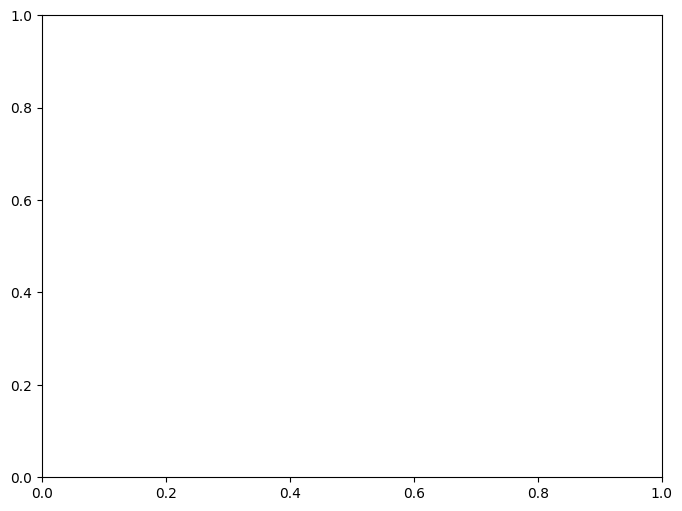

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib

# 예시: 모델 예측값이 있다고 가정
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)

# 레이블 디코더 로딩 (있다면)
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

# classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_labels)
x = np.arange(len(class_names))

plt.figure(figsize=(8, 6))
bar_width = 0.25
plt.bar(x, precision, width=bar_width, label='precision')
plt.bar(x + bar_width, recall, width=bar_width, label='recall')
plt.bar(x + 2*bar_width, f1, width=bar_width, label='f1-score')
plt.xticks(x + bar_width, class_names)
plt.title("Precision / Recall / F1-score by Class")
plt.legend()
plt.tight_layout()
plt.show()


# 모델 저장 및 시각화

In [1]:
import json
import matplotlib.pyplot as plt

# 로그 저장 경로
log_path = "/media/usou/PortableSSD/mldl_project/models/train_history_log.json"

# history 객체를 JSON으로 저장
with open(log_path, "w") as f:
    json.dump(history.history, f)
print("✅ 학습 로그 저장 완료")

# 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

# .keras 포맷 으로 저장

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/media/usou/PortableSSD/mldl_project/models/best_model_generator.h5")


In [ ]:
model.save("best_model_generator.keras")

# .keras -> .h5 로 변경

In [3]:
from tensorflow.keras.models import load_model

# 1. 기존 .keras 모델 경로
keras_path = "/home/usou/dev_ws/superbad/deeplearning-repo-3/ai/models//voice_emotion_model.keras"

# 2. 저장할 .h5 모델 경로
h5_path = "/home/usou/dev_ws/superbad/deeplearning-repo-3/ai/models//voice_emotion_model.h5"

# 3. 모델 로드 후 저장
model = load_model(keras_path, compile=False)
model.save(h5_path)

print("✅ 변환 완료: .keras → .h5")


✅ 변환 완료: .keras → .h5


# 모델 테스트

## m4a → wav 변환

In [ ]:
from pydub import AudioSegment
import os

def convert_to_wav(input_path, output_path=None):
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"파일이 존재하지 않아요: {input_path}")

    if output_path is None:
        output_path = os.path.splitext(input_path)[0] + ".wav"

    audio = AudioSegment.from_file(input_path, format="m4a")
    audio.export(output_path, format="wav")
    print("✅ 변환 완료:", output_path)
    return output_path


## m4a, mp3, mp4 -> wav

In [13]:
import os
from pydub import AudioSegment

def convert_to_wav(input_path, output_path=None):
    """
    오디오 또는 비디오 파일을 WAV로 변환합니다.
    지원 포맷: .wav, .m4a, .mp3, .mp4 등
    내부적으로 ffmpeg가 설치되어 있어야 합니다.

    :param input_path: 입력 파일 경로
    :param output_path: 출력 파일 경로 (None이면 자동 생성)
    :return: 변환된 WAV 파일 경로
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"파일이 존재하지 않아요: {input_path}")

    ext = os.path.splitext(input_path)[1].lower()
    if output_path is None:
        output_path = os.path.splitext(input_path)[0] + ".wav"

    # pydub이 ffmpeg를 통해 모든 형식 처리함
    try:
        audio = AudioSegment.from_file(input_path)
        audio.export(output_path, format="wav")
    except Exception as e:
        raise RuntimeError(f"오디오 변환 실패: {e}")

    print("변환 완료:", output_path)
    return output_path


## MFCC 추출(모델 입력 준비)

In [14]:
import librosa
import numpy as np

def extract_mfcc(file_path, sr=16000, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.expand_dims(mfcc, axis=-1)  # CNN 입력을 위해 채널 차원 추가
    return mfcc


## 레이블 인코딩

In [15]:
import os
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder

# ============================
# 1. 설정
# ============================
# 레이블 배치가 저장된 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches"

# 인코딩된 레이블 저장 경로
encoded_label_dir = os.path.join(label_dir, "encoded_labels")
os.makedirs(encoded_label_dir, exist_ok=True)

# ============================
# 2. 모든 배치 레이블 수집 및 'nan' 제거
# ============================
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

all_labels = []
batch_label_data = []
valid_indices_per_batch = []

for label_file in label_files:
    labels = np.load(label_file, allow_pickle=True)
    
    # 'nan' 문자열 제거
    valid_indices = [i for i, l in enumerate(labels) if str(l).lower() != 'nan']
    valid_labels = [labels[i] for i in valid_indices]

    all_labels.extend(valid_labels)
    batch_label_data.append(valid_labels)
    valid_indices_per_batch.append(valid_indices)

# ============================
# 3. 레이블 인코딩
# ============================
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 인코더 저장
with open(os.path.join(label_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# ============================
# 4. 인코딩된 레이블 배치별로 저장
# ============================
for i, labels in enumerate(batch_label_data):
    encoded = label_encoder.transform(labels)
    save_path = os.path.join(encoded_label_dir, f"label_batch_{i}.npy")
    np.save(save_path, encoded)

print(f"총 유효 레이블 개수 (nan 제외): {len(all_labels)}")
print(f"인코딩된 클래스 목록: {label_encoder.classes_}")
print(f"유효 배치 수: {len(label_files)}")
print("nan 제거 및 레이블 인코딩 완료")


총 유효 레이블 개수 (nan 제외): 530280
인코딩된 클래스 목록: ['Angry' 'Anxious' 'Embarrassed' 'Happy' 'Hurt' 'Neutrality' 'Sad']
유효 배치 수: 82
nan 제거 및 레이블 인코딩 완료


## 감정 분석 예측

In [16]:
from tensorflow.keras.models import load_model
import numpy as np

# 모델 로드
model_path = "best_model_generator_voice_emotion_analyze.keras"
model = load_model(model_path)

# LabelEncoder 로드
import pickle
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

def predict_emotion(mfcc_data):
    # 입력 형태 맞추기 (1, time, freq, 1)
    X = np.expand_dims(mfcc_data, axis=0)
    pred = model.predict(X)
    idx = np.argmax(pred)
    label = le.inverse_transform([idx])[0]
    confidence = float(np.max(pred))
    return label, confidence


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 전체 파이프라인 실행 예시

In [17]:
# 1. 파일 변환
m4a_path = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1/1.감정/5.상처/0005_G1A3E5S0C0_LJB/0005_G1A3E5S0C0_LJB_000011.wav"

wav_path = convert_to_wav(m4a_path)

# 2. MFCC 추출
mfcc = extract_mfcc(wav_path)

# 3. 감정 예측
emotion, score = predict_emotion(mfcc)
print(f"\n 감정 분석 결과: {emotion} ({score:.2%} 확신)")


변환 완료: /media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1/1.감정/5.상처/0005_G1A3E5S0C0_LJB/0005_G1A3E5S0C0_LJB_000011.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

 감정 분석 결과: Happy (100.00% 확신)


In [10]:
import librosa
import numpy as np
import tensorflow as tf
import pickle

# 설정
wav_path = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1/1.감정/5.상처/0005_G1A3E5S0C0_LJB/0005_G1A3E5S0C0_LJB_000011.wav"  # 예: ./val_data/sample_001.wav
label_encoder_path = "/media/usou/PortableSSD/mldl_project/data/mfcc_batches/label_encoder.pkl"  # 예: ./label_encoder.pkl
model_path = "best_model_generator_voice_emotion_analyze.keras"


# 1. 모델 및 라벨 인코더 로드
model = tf.keras.models.load_model(model_path)

with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# 2. wav 파일에서 MFCC 추출
def extract_mfcc(wav_path, sr=16000, n_mfcc=40, max_len=300):
    y, sr = librosa.load(wav_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # 길이 고정 (짧으면 패딩, 길면 자름)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

# 3. 예측
mfcc = extract_mfcc(wav_path)
mfcc_input = mfcc[np.newaxis, ..., np.newaxis]  # (1, 40, 300, 1) 형태로 reshape

y_pred = model.predict(mfcc_input)

# 4. 결과 출력
pred_index = np.argmax(y_pred)
pred_emotion = label_encoder.inverse_transform([pred_index])[0]

print("Softmax 확률 분포:", y_pred[0])
print("예측된 감정:", pred_emotion)


/home/usou/venv/test_super/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-02 12:21:20.363584: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.11 = (f32[1,128,10,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,10,75]{3,2,1,0} %bitcast.440, f32[128,64,3,3]{3,2,1,0} %bitcast.447, f32[128]{0} %bitcast.449), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_2_1/convolution" source_file="/home/usou/venv/test_super/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_o

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Softmax 확률 분포: [6.35206882e-17 7.89071120e-13 1.22968635e-10 1.00000000e+00
 3.78825990e-27 1.18888200e-12 5.54563053e-27 1.00396704e-16]
예측된 감정: Happy


## 재학습

-  감정 클래스 7 -> 4개 축소
- 행복, 슬픔, 분노, 중립
- 데이터 증강 및 개선 모델 필요
- 모델 성능 향상 전략
    - 데이터 증강 + 하이퍼 파라미터 튜닝 + 과적합 방지

# 전체 흐름 요약
✅ 전체 흐름 요약

| 단계         | 설명                                              |
|--------------|---------------------------------------------------|
| 1단계 (완료) | JSON → `metadata_cleaned.csv` 생성               |
| 2단계        | 4개 감정만 필터링 → `metadata_4class.csv` 저장   |
| 3단계        | MFCC 추출 + 증강 적용                             |
| 4단계        | 인코딩 → 배치 분할 저장                          |


# 1단계: JSON → DataFrame 변환 

In [6]:
import os
import json
import pandas as pd

# 라벨링 JSON이 위치한 최상위 폴더 경로
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/라벨링데이터/"

# 실제 wav 파일이 존재하는 원천 데이터 경로
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/원천데이터/"

# 결과 CSV 및 로그를 저장할 폴더 경로
save_dir = "./data/usou"
os.makedirs(save_dir, exist_ok=True)

# 사용할 감정 4개만 필터링 대상
target_classes = ['Happy', 'Sad', 'Angry', 'Neutrality']

# 정제된 데이터와 누락 파일 로그를 담을 리스트
data = []
broken_files = []

# 모든 하위 폴더를 순회하며 JSON 파일 탐색
for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if not file_name.endswith(".json"):
            continue  # JSON 파일만 처리

        json_path = os.path.join(folder_path, file_name)
        try:
            # JSON 파일 로딩
            with open(json_path, 'r', encoding='utf-8') as f:
                content = json.load(f)

            # 감정 정보 추출 및 필터링
            emotion = content["화자정보"]["Emotion"]
            if emotion not in target_classes:
                continue  # 지정된 감정이 아닌 경우 제외

            # 그 외 부가 정보 추출
            style = content["화자정보"].get("SpeechStyle", "N/A")
            sensitivity = content["화자정보"].get("Sensitivity", "N/A")
            wav_file = content["파일정보"]["FileName"]

            # 경로 변환 (TL → TS로 수정하여 wav 경로 재구성)
            relative_path = os.path.relpath(folder_path, start=label_root)
            relative_path = relative_path.replace("TL", "TS")
            wav_path = os.path.join(wav_root, relative_path, wav_file)

            # wav 파일 존재 여부 확인 후 저장
            if os.path.exists(wav_path):
                data.append({
                    "wav_path": wav_path,
                    "emotion": emotion,
                    "style": style,
                    "sensitivity": sensitivity
                })
            else:
                broken_files.append(wav_path)
        except Exception as e:
            # JSON 로딩 실패 또는 파싱 오류 발생 시 경로 저장
            broken_files.append(json_path)

# 수집된 데이터를 DataFrame으로 변환
df = pd.DataFrame(data)

# 결과 CSV 저장
df.to_csv(os.path.join(save_dir, "metadata_4class.csv"), index=False)

# 누락된 경로 저장
with open(os.path.join(save_dir, "broken_files.txt"), "w") as f:
    for path in broken_files:
        f.write(path + "\n")

# 최종 처리 결과 출력
print("총 수집된 샘플:", len(df))
print("에러 발생 수:", len(broken_files))


총 수집된 샘플: 300584
에러 발생 수: 0


# MFCC 추출 + 증강

- metadata_4class.csv에서 경로와 감정 읽기

- audiomentations로 증강 (2배)

- MFCC 추출 (40 x 300)

- mfcc_data.npy, labels.npy 저장

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from tqdm import tqdm

# 1. 입력 및 출력 경로 설정
csv_path = "./data/usou/metadata_4class.csv"
output_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
os.makedirs(output_dir, exist_ok=True)

# 2. 오디오 및 MFCC 관련 설정
n_mfcc = 40                     # 추출할 MFCC 계수 수
max_len = 300                  # MFCC 길이 고정값
n_augment = 2                  # 증강 횟수 (원본 포함 총 3배)
batch_size = 1000              # 배치 저장 단위

# 3. 데이터프레임 불러오기
df = pd.read_csv(csv_path)

# 4. 증강 파이프라인 설정
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.7),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_shift=-0.2, max_shift=0.2, p=0.5)
])

# 5. MFCC 추출 함수 정의
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

# 6. 배치별로 데이터를 저장하기 위한 변수 초기화
mfcc_batch = []
label_batch = []
batch_index = 0

# 7. tqdm을 이용해 전체 진행 상황 표시
for idx, row in tqdm(df.iterrows(), total=len(df), desc="MFCC 추출 및 증강"):
    wav_path = row["wav_path"]
    emotion = row["emotion"]

    try:
        # 원본 로딩
        y, sr = librosa.load(wav_path, sr=16000)

        # 원본 MFCC 저장
        mfcc_batch.append(extract_mfcc(y, sr))
        label_batch.append(emotion)

        # 증강 MFCC 저장
        for _ in range(n_augment):
            y_aug = augment(samples=y, sample_rate=sr)
            mfcc_batch.append(extract_mfcc(y_aug, sr))
            label_batch.append(emotion)

        # 일정 크기의 배치가 모이면 저장 후 초기화
        if len(mfcc_batch) >= batch_size:
            np.save(os.path.join(output_dir, f"mfcc_batch_{batch_index}.npy"), np.array(mfcc_batch))
            np.save(os.path.join(output_dir, f"label_batch_{batch_index}.npy"), np.array(label_batch, dtype=object))
            print(f"배치 {batch_index} 저장 완료 - {len(mfcc_batch)}개")
            batch_index += 1
            mfcc_batch.clear()
            label_batch.clear()

    except Exception as e:
        print(f"오류 발생: {wav_path} → {e}")
        continue

# 8. 마지막에 남은 배치도 저장
if mfcc_batch:
    np.save(os.path.join(output_dir, f"mfcc_batch_{batch_index}.npy"), np.array(mfcc_batch))
    np.save(os.path.join(output_dir, f"label_batch_{batch_index}.npy"), np.array(label_batch, dtype=object))
    print(f"마지막 배치 {batch_index} 저장 완료 - {len(mfcc_batch)}개")

print("전체 MFCC 추출 및 저장 작업 완료")


/tmp/ipykernel_4643/3246010131.py:20: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
MFCC 추출 및 증강:   0%|          | 335/300584 [00:25<7:26:13, 11.21it/s]

배치 0 저장 완료 - 1002개


MFCC 추출 및 증강:   0%|          | 669/300584 [00:52<7:05:35, 11.75it/s]

배치 1 저장 완료 - 1002개


MFCC 추출 및 증강:   0%|          | 1003/300584 [01:19<6:33:32, 12.69it/s]

배치 2 저장 완료 - 1002개


MFCC 추출 및 증강:   0%|          | 1339/300584 [01:45<5:59:34, 13.87it/s]

배치 3 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 1672/300584 [02:12<7:22:27, 11.26it/s]

배치 4 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 2005/300584 [02:39<7:08:27, 11.61it/s]

배치 5 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 2339/300584 [03:09<9:13:48,  8.98it/s] 

배치 6 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 2673/300584 [03:38<7:00:54, 11.80it/s]

배치 7 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 3007/300584 [04:06<7:00:46, 11.79it/s]

배치 8 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 3341/300584 [04:36<10:25:53,  7.92it/s]

배치 9 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|          | 3675/300584 [05:06<8:14:35, 10.01it/s] 

배치 10 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|▏         | 4011/300584 [05:34<5:49:34, 14.14it/s]

배치 11 저장 완료 - 1002개


MFCC 추출 및 증강:   1%|▏         | 4343/300584 [06:02<6:37:31, 12.42it/s] 

배치 12 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 4678/300584 [06:30<6:45:41, 12.16it/s]

배치 13 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 5012/300584 [06:59<6:58:11, 11.78it/s]

배치 14 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 5345/300584 [07:27<7:35:58, 10.79it/s]

배치 15 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 5680/300584 [07:54<6:02:02, 13.58it/s]

배치 16 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 6014/300584 [08:21<6:38:06, 12.33it/s]

배치 17 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 6349/300584 [08:48<6:16:18, 13.03it/s]

배치 18 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 6683/300584 [09:15<6:27:29, 12.64it/s]

배치 19 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 7015/300584 [09:42<7:19:14, 11.14it/s]

배치 20 저장 완료 - 1002개


MFCC 추출 및 증강:   2%|▏         | 7350/300584 [10:09<6:11:35, 13.15it/s]

배치 21 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 7685/300584 [10:36<6:33:22, 12.41it/s]

배치 22 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 8018/300584 [11:03<7:40:19, 10.59it/s]

배치 23 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 8351/300584 [11:28<7:38:08, 10.63it/s]

배치 24 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 8686/300584 [11:55<5:35:51, 14.49it/s]

배치 25 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 9020/300584 [12:22<4:54:02, 16.53it/s]

배치 26 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 9354/300584 [12:48<7:11:23, 11.25it/s]

배치 27 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 9689/300584 [13:14<5:33:36, 14.53it/s]

배치 28 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 10022/300584 [13:41<6:44:33, 11.97it/s]

배치 29 저장 완료 - 1002개


MFCC 추출 및 증강:   3%|▎         | 10357/300584 [14:08<6:08:25, 13.13it/s]

배치 30 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▎         | 10689/300584 [14:34<6:47:13, 11.86it/s]

배치 31 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▎         | 11023/300584 [15:00<6:32:27, 12.30it/s]

배치 32 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 11357/300584 [15:27<6:18:30, 12.74it/s]

배치 33 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 11693/300584 [15:55<7:05:06, 11.33it/s]

배치 34 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 12024/300584 [16:23<6:30:57, 12.30it/s]

배치 35 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 12360/300584 [16:51<6:31:45, 12.26it/s]

배치 36 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 12693/300584 [17:17<6:25:28, 12.45it/s]

배치 37 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 13027/300584 [17:44<8:38:10,  9.25it/s]

배치 38 저장 완료 - 1002개


MFCC 추출 및 증강:   4%|▍         | 13362/300584 [18:11<6:04:20, 13.14it/s]

배치 39 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▍         | 13696/300584 [18:39<7:36:52, 10.47it/s]

배치 40 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▍         | 14029/300584 [19:06<7:31:44, 10.57it/s]

배치 41 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▍         | 14363/300584 [19:33<6:59:13, 11.38it/s]

배치 42 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▍         | 14699/300584 [20:01<6:29:44, 12.23it/s]

배치 43 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▌         | 15031/300584 [20:29<7:42:30, 10.29it/s]

배치 44 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▌         | 15364/300584 [20:57<6:24:02, 12.38it/s]

배치 45 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▌         | 15698/300584 [21:24<6:33:22, 12.07it/s]

배치 46 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▌         | 16034/300584 [21:51<5:45:14, 13.74it/s]

배치 47 저장 완료 - 1002개


MFCC 추출 및 증강:   5%|▌         | 16368/300584 [22:18<6:55:04, 11.41it/s]

배치 48 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 16701/300584 [22:47<6:55:37, 11.38it/s]

배치 49 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 17034/300584 [23:16<7:40:21, 10.27it/s]

배치 50 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 17370/300584 [23:43<7:05:24, 11.10it/s]

배치 51 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 17703/300584 [24:09<7:04:26, 11.11it/s]

배치 52 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 18037/300584 [24:39<6:26:37, 12.18it/s]

배치 53 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 18371/300584 [25:08<8:10:08,  9.60it/s]

배치 54 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▌         | 18706/300584 [25:34<5:56:39, 13.17it/s]

배치 55 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▋         | 19039/300584 [26:03<6:39:39, 11.74it/s]

배치 56 저장 완료 - 1002개


MFCC 추출 및 증강:   6%|▋         | 19374/300584 [26:30<7:01:24, 11.12it/s]

배치 57 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 19707/300584 [26:58<5:38:40, 13.82it/s]

배치 58 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 20041/300584 [27:25<6:55:44, 11.25it/s]

배치 59 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 20375/300584 [27:52<9:08:28,  8.51it/s] 

배치 60 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 20708/300584 [28:24<11:21:42,  6.84it/s]

배치 61 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 21043/300584 [28:53<6:35:56, 11.77it/s] 

배치 62 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 21378/300584 [29:20<6:21:37, 12.19it/s]

배치 63 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 21713/300584 [29:45<5:36:24, 13.82it/s]

배치 64 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 22047/300584 [30:11<5:27:02, 14.20it/s]

배치 65 저장 완료 - 1002개


MFCC 추출 및 증강:   7%|▋         | 22381/300584 [30:38<6:23:49, 12.08it/s]

배치 66 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 22715/300584 [31:03<6:10:05, 12.51it/s]

배치 67 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 23048/300584 [31:31<6:14:15, 12.36it/s]

배치 68 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 23382/300584 [31:59<7:04:44, 10.88it/s]

배치 69 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 23716/300584 [32:25<6:20:27, 12.13it/s] 

배치 70 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 24050/300584 [32:52<5:44:22, 13.38it/s]

배치 71 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 24383/300584 [33:19<6:53:25, 11.13it/s]

배치 72 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 24719/300584 [33:45<5:48:29, 13.19it/s]

배치 73 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 25051/300584 [34:12<7:25:22, 10.31it/s]

배치 74 저장 완료 - 1002개


MFCC 추출 및 증강:   8%|▊         | 25386/300584 [34:40<5:18:55, 14.38it/s]

배치 75 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▊         | 25719/300584 [35:07<6:28:26, 11.79it/s]

배치 76 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▊         | 26053/300584 [35:34<7:16:49, 10.47it/s]

배치 77 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 26386/300584 [36:04<6:30:50, 11.69it/s] 

배치 78 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 26723/300584 [36:30<5:33:30, 13.69it/s]

배치 79 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 27054/300584 [36:58<8:05:43,  9.39it/s]

배치 80 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 27389/300584 [37:29<8:02:09,  9.44it/s] 

배치 81 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 27725/300584 [37:55<6:48:43, 11.13it/s]

배치 82 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 28058/300584 [38:21<5:41:57, 13.28it/s]

배치 83 저장 완료 - 1002개


MFCC 추출 및 증강:   9%|▉         | 28392/300584 [38:47<6:44:39, 11.21it/s]

배치 84 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|▉         | 28725/300584 [39:13<5:37:48, 13.41it/s]

배치 85 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|▉         | 29059/300584 [39:40<5:58:31, 12.62it/s]

배치 86 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|▉         | 29395/300584 [40:07<5:41:57, 13.22it/s]

배치 87 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|▉         | 29727/300584 [40:33<6:23:40, 11.77it/s]

배치 88 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|█         | 30062/300584 [40:59<5:44:52, 13.07it/s]

배치 89 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|█         | 30395/300584 [41:27<8:33:38,  8.77it/s]

배치 90 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|█         | 30728/300584 [41:58<6:32:35, 11.46it/s] 

배치 91 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|█         | 31062/300584 [42:26<8:10:57,  9.15it/s]

배치 92 저장 완료 - 1002개


MFCC 추출 및 증강:  10%|█         | 31397/300584 [42:56<8:03:38,  9.28it/s]

배치 93 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 31732/300584 [43:26<7:46:42,  9.60it/s]

배치 94 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 32064/300584 [43:54<7:16:46, 10.25it/s]

배치 95 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 32401/300584 [44:22<5:59:09, 12.45it/s]

배치 96 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 32732/300584 [44:49<6:10:44, 12.04it/s]

배치 97 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 33068/300584 [45:18<6:16:20, 11.85it/s]

배치 98 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 33401/300584 [45:46<7:26:32,  9.97it/s]

배치 99 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█         | 33736/300584 [46:15<5:53:52, 12.57it/s]

배치 100 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█▏        | 34070/300584 [46:43<6:17:56, 11.75it/s]

배치 101 저장 완료 - 1002개


MFCC 추출 및 증강:  11%|█▏        | 34403/300584 [47:10<6:59:45, 10.57it/s]

배치 102 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 34738/300584 [47:37<7:14:55, 10.19it/s]

배치 103 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 35073/300584 [48:05<6:38:47, 11.10it/s]

배치 104 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 35404/300584 [48:32<5:53:39, 12.50it/s]

배치 105 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 35739/300584 [49:00<6:34:12, 11.20it/s] 

배치 106 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 36073/300584 [49:28<7:33:03,  9.73it/s]

배치 107 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 36408/300584 [49:56<6:51:10, 10.71it/s]

배치 108 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 36742/300584 [50:25<7:42:21,  9.51it/s]

배치 109 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 37077/300584 [50:53<6:37:57, 11.04it/s]

배치 110 저장 완료 - 1002개


MFCC 추출 및 증강:  12%|█▏        | 37410/300584 [51:24<7:01:46, 10.40it/s]

배치 111 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 37744/300584 [51:53<6:54:57, 10.56it/s]

배치 112 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 38077/300584 [52:21<6:13:23, 11.72it/s]

배치 113 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 38412/300584 [52:49<8:07:04,  8.97it/s]

배치 114 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 38747/300584 [53:18<6:17:29, 11.56it/s]

배치 115 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 39079/300584 [53:45<8:45:32,  8.29it/s]

배치 116 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 39413/300584 [54:11<6:43:02, 10.80it/s]

배치 117 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 39748/300584 [54:35<6:34:44, 11.01it/s]

배치 118 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 40082/300584 [55:01<5:41:57, 12.70it/s]

배치 119 저장 완료 - 1002개


MFCC 추출 및 증강:  13%|█▎        | 40416/300584 [55:25<6:54:30, 10.46it/s]

배치 120 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▎        | 40749/300584 [55:53<6:15:25, 11.54it/s] 

배치 121 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▎        | 41085/300584 [56:20<5:37:39, 12.81it/s]

배치 122 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 41419/300584 [56:47<6:52:00, 10.48it/s]

배치 123 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 41751/300584 [57:12<6:04:29, 11.84it/s]

배치 124 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 42085/300584 [57:38<7:05:15, 10.13it/s]

배치 125 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 42420/300584 [58:03<6:33:10, 10.94it/s]

배치 126 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 42754/300584 [58:29<6:14:19, 11.48it/s]

배치 127 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 43088/300584 [58:58<7:13:24,  9.90it/s]

배치 128 저장 완료 - 1002개


MFCC 추출 및 증강:  14%|█▍        | 43422/300584 [59:27<6:35:31, 10.84it/s]

배치 129 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▍        | 43758/300584 [59:53<5:46:19, 12.36it/s]

배치 130 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▍        | 44089/300584 [1:00:23<7:26:08,  9.58it/s]

배치 131 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▍        | 44423/300584 [1:00:54<7:04:34, 10.06it/s] 

배치 132 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▍        | 44757/300584 [1:01:28<9:09:55,  7.75it/s] 

배치 133 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▌        | 45092/300584 [1:02:04<6:15:40, 11.34it/s] 

배치 134 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▌        | 45424/300584 [1:02:36<13:53:21,  5.10it/s]

배치 135 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▌        | 45759/300584 [1:03:16<9:04:47,  7.80it/s] 

배치 136 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▌        | 46093/300584 [1:03:47<6:46:32, 10.43it/s] 

배치 137 저장 완료 - 1002개


MFCC 추출 및 증강:  15%|█▌        | 46426/300584 [1:04:20<6:45:12, 10.45it/s] 

배치 138 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 46760/300584 [1:04:54<7:23:27,  9.54it/s] 

배치 139 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 47096/300584 [1:05:25<6:48:10, 10.35it/s]

배치 140 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 47431/300584 [1:05:56<6:27:59, 10.87it/s]

배치 141 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 47763/300584 [1:06:22<6:02:19, 11.63it/s]

배치 142 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 48099/300584 [1:06:50<5:00:54, 13.98it/s]

배치 143 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 48432/300584 [1:07:17<5:43:21, 12.24it/s]

배치 144 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▌        | 48766/300584 [1:07:43<5:45:38, 12.14it/s]

배치 145 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▋        | 49100/300584 [1:08:09<6:57:47, 10.03it/s]

배치 146 저장 완료 - 1002개


MFCC 추출 및 증강:  16%|█▋        | 49434/300584 [1:08:37<6:23:28, 10.92it/s]

배치 147 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 49768/300584 [1:09:04<6:40:14, 10.44it/s]

배치 148 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 50102/300584 [1:09:33<6:23:46, 10.88it/s] 

배치 149 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 50435/300584 [1:10:00<5:48:35, 11.96it/s]

배치 150 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 50770/300584 [1:10:29<5:57:33, 11.64it/s]

배치 151 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 51104/300584 [1:10:59<6:21:36, 10.90it/s]

배치 152 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 51439/300584 [1:11:29<5:59:10, 11.56it/s]

배치 153 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 51772/300584 [1:11:56<7:16:43,  9.50it/s]

배치 154 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 52106/300584 [1:12:25<6:47:22, 10.17it/s]

배치 155 저장 완료 - 1002개


MFCC 추출 및 증강:  17%|█▋        | 52438/300584 [1:12:53<6:14:11, 11.05it/s]

배치 156 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 52775/300584 [1:13:23<5:11:48, 13.25it/s]

배치 157 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 53108/300584 [1:13:53<5:45:59, 11.92it/s]

배치 158 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 53442/300584 [1:14:26<6:29:56, 10.56it/s]

배치 159 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 53776/300584 [1:14:56<6:44:11, 10.18it/s]

배치 160 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 54108/300584 [1:15:25<7:19:08,  9.35it/s]

배치 161 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 54444/300584 [1:15:57<7:44:17,  8.84it/s] 

배치 162 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 54777/300584 [1:16:27<7:33:52,  9.03it/s]

배치 163 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 55112/300584 [1:16:57<7:29:39,  9.10it/s]

배치 164 저장 완료 - 1002개


MFCC 추출 및 증강:  18%|█▊        | 55446/300584 [1:17:27<6:01:05, 11.31it/s]

배치 165 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▊        | 55780/300584 [1:17:57<8:08:32,  8.35it/s]

배치 166 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▊        | 56113/300584 [1:18:27<6:50:55,  9.92it/s]

배치 167 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 56447/300584 [1:18:57<5:27:02, 12.44it/s]

배치 168 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 56782/300584 [1:19:26<5:48:00, 11.68it/s]

배치 169 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 57116/300584 [1:19:51<5:34:26, 12.13it/s]

배치 170 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 57449/300584 [1:20:17<5:10:20, 13.06it/s]

배치 171 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 57785/300584 [1:20:43<6:08:23, 10.98it/s]

배치 172 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 58117/300584 [1:21:08<5:32:21, 12.16it/s]

배치 173 저장 완료 - 1002개


MFCC 추출 및 증강:  19%|█▉        | 58453/300584 [1:21:34<5:10:34, 12.99it/s]

배치 174 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|█▉        | 58785/300584 [1:22:00<5:49:39, 11.53it/s]

배치 175 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|█▉        | 59120/300584 [1:22:27<5:39:20, 11.86it/s]

배치 176 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|█▉        | 59454/300584 [1:22:53<5:10:38, 12.94it/s] 

배치 177 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|█▉        | 59789/300584 [1:23:17<5:00:42, 13.35it/s]

배치 178 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|██        | 60121/300584 [1:23:43<6:06:59, 10.92it/s]

배치 179 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|██        | 60455/300584 [1:24:07<5:23:11, 12.38it/s]

배치 180 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|██        | 60790/300584 [1:24:33<5:39:15, 11.78it/s]

배치 181 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|██        | 61125/300584 [1:25:02<5:48:50, 11.44it/s]

배치 182 저장 완료 - 1002개


MFCC 추출 및 증강:  20%|██        | 61458/300584 [1:25:28<6:04:02, 10.95it/s]

배치 183 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 61791/300584 [1:25:54<5:44:17, 11.56it/s]

배치 184 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 62127/300584 [1:26:21<5:26:07, 12.19it/s]

배치 185 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 62458/300584 [1:26:53<10:27:15,  6.33it/s]

배치 186 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 62792/300584 [1:27:26<7:45:13,  8.52it/s] 

배치 187 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 63127/300584 [1:27:55<9:00:55,  7.32it/s]

배치 188 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 63461/300584 [1:28:24<6:29:54, 10.14it/s]

배치 189 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██        | 63794/300584 [1:28:53<5:50:52, 11.25it/s]

배치 190 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██▏       | 64129/300584 [1:29:25<6:05:26, 10.78it/s] 

배치 191 저장 완료 - 1002개


MFCC 추출 및 증강:  21%|██▏       | 64463/300584 [1:29:56<6:40:46,  9.82it/s]

배치 192 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 64797/300584 [1:30:22<5:29:50, 11.91it/s]

배치 193 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 65132/300584 [1:30:47<5:54:34, 11.07it/s]

배치 194 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 65464/300584 [1:31:12<6:21:28, 10.27it/s]

배치 195 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 65799/300584 [1:31:36<4:24:49, 14.78it/s]

배치 196 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 66133/300584 [1:32:01<5:01:06, 12.98it/s]

배치 197 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 66468/300584 [1:32:22<4:04:16, 15.97it/s]

배치 198 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 66804/300584 [1:32:43<3:49:20, 16.99it/s]

배치 199 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 67135/300584 [1:33:05<5:10:15, 12.54it/s]

배치 200 저장 완료 - 1002개


MFCC 추출 및 증강:  22%|██▏       | 67469/300584 [1:33:27<5:13:52, 12.38it/s]

배치 201 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 67804/300584 [1:33:49<4:14:17, 15.26it/s]

배치 202 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 68137/300584 [1:34:13<4:06:39, 15.71it/s]

배치 203 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 68472/300584 [1:34:36<4:15:29, 15.14it/s]

배치 204 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 68807/300584 [1:34:57<4:22:59, 14.69it/s]

배치 205 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 69140/300584 [1:35:19<4:30:31, 14.26it/s]

배치 206 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 69472/300584 [1:35:41<5:08:33, 12.48it/s]

배치 207 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 69809/300584 [1:36:02<4:11:58, 15.26it/s]

배치 208 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 70142/300584 [1:36:24<3:44:43, 17.09it/s]

배치 209 저장 완료 - 1002개


MFCC 추출 및 증강:  23%|██▎       | 70476/300584 [1:36:44<3:44:15, 17.10it/s]

배치 210 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▎       | 70812/300584 [1:37:04<4:01:13, 15.88it/s]

배치 211 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▎       | 71145/300584 [1:37:25<4:31:36, 14.08it/s]

배치 212 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 71477/300584 [1:37:45<6:41:12,  9.52it/s]

배치 213 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 71812/300584 [1:38:06<3:58:55, 15.96it/s]

배치 214 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 72146/300584 [1:38:29<6:14:31, 10.17it/s]

배치 215 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 72481/300584 [1:38:52<4:20:51, 14.57it/s]

배치 216 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 72814/300584 [1:39:14<5:04:47, 12.46it/s]

배치 217 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 73149/300584 [1:39:35<3:26:51, 18.32it/s]

배치 218 저장 완료 - 1002개


MFCC 추출 및 증강:  24%|██▍       | 73480/300584 [1:39:57<5:04:41, 12.42it/s]

배치 219 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▍       | 73817/300584 [1:40:18<3:20:04, 18.89it/s]

배치 220 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▍       | 74149/300584 [1:40:41<5:14:40, 11.99it/s] 

배치 221 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▍       | 74486/300584 [1:41:01<3:29:21, 18.00it/s]

배치 222 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▍       | 74819/300584 [1:41:22<4:17:38, 14.60it/s]

배치 223 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▌       | 75153/300584 [1:41:42<3:49:47, 16.35it/s]

배치 224 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▌       | 75485/300584 [1:42:04<5:33:40, 11.24it/s]

배치 225 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▌       | 75821/300584 [1:42:25<3:05:27, 20.20it/s]

배치 226 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▌       | 76156/300584 [1:42:46<3:19:16, 18.77it/s]

배치 227 저장 완료 - 1002개


MFCC 추출 및 증강:  25%|██▌       | 76488/300584 [1:43:07<3:14:00, 19.25it/s]

배치 228 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 76821/300584 [1:43:29<5:32:30, 11.22it/s]

배치 229 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 77156/300584 [1:43:51<3:53:18, 15.96it/s]

배치 230 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 77490/300584 [1:44:13<5:59:30, 10.34it/s]

배치 231 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 77824/300584 [1:44:36<4:39:51, 13.27it/s]

배치 232 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 78159/300584 [1:44:58<4:25:26, 13.97it/s]

배치 233 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 78494/300584 [1:45:20<3:53:16, 15.87it/s]

배치 234 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▌       | 78825/300584 [1:45:43<4:02:14, 15.26it/s]

배치 235 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▋       | 79161/300584 [1:46:04<5:04:26, 12.12it/s]

배치 236 저장 완료 - 1002개


MFCC 추출 및 증강:  26%|██▋       | 79495/300584 [1:46:26<4:44:33, 12.95it/s]

배치 237 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 79830/300584 [1:46:48<3:44:16, 16.41it/s]

배치 238 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 80160/300584 [1:47:10<4:33:14, 13.45it/s]

배치 239 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 80496/300584 [1:47:32<3:42:58, 16.45it/s]

배치 240 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 80830/300584 [1:47:56<4:17:38, 14.22it/s]

배치 241 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 81165/300584 [1:48:18<4:35:53, 13.26it/s]

배치 242 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 81498/300584 [1:48:40<4:02:10, 15.08it/s]

배치 243 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 81833/300584 [1:49:04<4:28:43, 13.57it/s]

배치 244 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 82167/300584 [1:49:26<4:12:07, 14.44it/s]

배치 245 저장 완료 - 1002개


MFCC 추출 및 증강:  27%|██▋       | 82500/300584 [1:49:49<5:29:21, 11.04it/s]

배치 246 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 82835/300584 [1:50:10<5:09:16, 11.73it/s]

배치 247 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 83169/300584 [1:50:30<3:43:05, 16.24it/s]

배치 248 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 83504/300584 [1:50:51<3:42:11, 16.28it/s]

배치 249 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 83836/300584 [1:51:12<4:01:33, 14.96it/s]

배치 250 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 84170/300584 [1:51:32<4:36:59, 13.02it/s]

배치 251 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 84503/300584 [1:51:52<4:40:47, 12.83it/s]

배치 252 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 84839/300584 [1:52:15<4:30:41, 13.28it/s]

배치 253 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 85173/300584 [1:52:36<3:55:54, 15.22it/s]

배치 254 저장 완료 - 1002개


MFCC 추출 및 증강:  28%|██▊       | 85506/300584 [1:52:57<4:11:08, 14.27it/s]

배치 255 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▊       | 85841/300584 [1:53:19<3:35:13, 16.63it/s]

배치 256 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▊       | 86175/300584 [1:53:42<4:30:28, 13.21it/s]

배치 257 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 86507/300584 [1:54:04<5:03:18, 11.76it/s]

배치 258 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 86844/300584 [1:54:25<3:01:38, 19.61it/s]

배치 259 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 87175/300584 [1:54:45<3:30:41, 16.88it/s]

배치 260 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 87511/300584 [1:55:08<4:28:13, 13.24it/s]

배치 261 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 87844/300584 [1:55:30<3:58:19, 14.88it/s]

배치 262 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 88177/300584 [1:55:52<4:17:27, 13.75it/s]

배치 263 저장 완료 - 1002개


MFCC 추출 및 증강:  29%|██▉       | 88511/300584 [1:56:14<3:48:21, 15.48it/s]

배치 264 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|██▉       | 88846/300584 [1:56:35<4:41:21, 12.54it/s]

배치 265 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|██▉       | 89181/300584 [1:56:57<3:09:24, 18.60it/s]

배치 266 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|██▉       | 89513/300584 [1:57:19<5:09:11, 11.38it/s]

배치 267 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|██▉       | 89847/300584 [1:57:42<3:59:50, 14.64it/s]

배치 268 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|███       | 90183/300584 [1:58:07<5:12:29, 11.22it/s]

배치 269 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|███       | 90516/300584 [1:58:32<3:57:18, 14.75it/s]

배치 270 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|███       | 90850/300584 [1:58:54<5:18:26, 10.98it/s]

배치 271 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|███       | 91184/300584 [1:59:16<3:35:56, 16.16it/s]

배치 272 저장 완료 - 1002개


MFCC 추출 및 증강:  30%|███       | 91519/300584 [1:59:37<4:00:02, 14.52it/s]

배치 273 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 91852/300584 [2:00:00<4:29:04, 12.93it/s]

배치 274 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 92187/300584 [2:00:24<4:04:46, 14.19it/s]

배치 275 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 92521/300584 [2:00:46<3:49:19, 15.12it/s]

배치 276 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 92853/300584 [2:01:08<5:29:33, 10.51it/s]

배치 277 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 93187/300584 [2:01:30<3:40:42, 15.66it/s]

배치 278 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 93524/300584 [2:01:53<3:42:45, 15.49it/s]

배치 279 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███       | 93856/300584 [2:02:15<3:15:40, 17.61it/s]

배치 280 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███▏      | 94190/300584 [2:02:39<3:58:11, 14.44it/s]

배치 281 저장 완료 - 1002개


MFCC 추출 및 증강:  31%|███▏      | 94524/300584 [2:03:01<4:28:58, 12.77it/s]

배치 282 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 94859/300584 [2:03:24<3:58:18, 14.39it/s]

배치 283 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 95192/300584 [2:03:46<4:41:13, 12.17it/s]

배치 284 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 95528/300584 [2:04:12<4:14:14, 13.44it/s]

배치 285 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 95861/300584 [2:04:41<4:58:48, 11.42it/s]

배치 286 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 96193/300584 [2:05:08<4:28:02, 12.71it/s]

배치 287 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 96526/300584 [2:05:37<7:14:53,  7.82it/s]

배치 288 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 96862/300584 [2:06:04<3:51:11, 14.69it/s]

배치 289 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 97195/300584 [2:06:29<4:57:17, 11.40it/s]

배치 290 저장 완료 - 1002개


MFCC 추출 및 증강:  32%|███▏      | 97530/300584 [2:06:55<4:29:48, 12.54it/s]

배치 291 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 97864/300584 [2:07:22<4:28:48, 12.57it/s]

배치 292 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 98197/300584 [2:07:48<5:14:29, 10.73it/s]

배치 293 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 98531/300584 [2:08:15<6:08:32,  9.14it/s]

배치 294 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 98864/300584 [2:08:43<5:13:33, 10.72it/s]

배치 295 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 99198/300584 [2:09:14<5:54:05,  9.48it/s]

배치 296 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 99532/300584 [2:09:44<5:26:52, 10.25it/s]

배치 297 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 99866/300584 [2:10:13<6:02:04,  9.24it/s]

배치 298 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 100201/300584 [2:10:44<6:50:08,  8.14it/s]

배치 299 저장 완료 - 1002개


MFCC 추출 및 증강:  33%|███▎      | 100536/300584 [2:11:16<4:08:11, 13.43it/s]

배치 300 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▎      | 100872/300584 [2:11:42<4:28:46, 12.38it/s]

배치 301 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▎      | 101203/300584 [2:12:09<7:23:45,  7.49it/s]

배치 302 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 101537/300584 [2:12:36<4:37:54, 11.94it/s]

배치 303 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 101871/300584 [2:13:04<4:43:39, 11.68it/s]

배치 304 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 102205/300584 [2:13:33<5:00:15, 11.01it/s]

배치 305 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 102540/300584 [2:14:01<4:18:28, 12.77it/s]

배치 306 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 102875/300584 [2:14:27<4:00:07, 13.72it/s]

배치 307 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 103207/300584 [2:14:53<4:54:52, 11.16it/s]

배치 308 저장 완료 - 1002개


MFCC 추출 및 증강:  34%|███▍      | 103542/300584 [2:15:21<4:52:44, 11.22it/s]

배치 309 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▍      | 103876/300584 [2:15:48<5:16:08, 10.37it/s]

배치 310 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▍      | 104210/300584 [2:16:18<5:46:32,  9.44it/s]

배치 311 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▍      | 104543/300584 [2:16:46<10:10:12,  5.35it/s]

배치 312 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▍      | 104879/300584 [2:17:20<4:52:49, 11.14it/s] 

배치 313 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▌      | 105211/300584 [2:17:53<7:03:48,  7.68it/s]

배치 314 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▌      | 105546/300584 [2:18:25<4:05:32, 13.24it/s]

배치 315 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▌      | 105879/300584 [2:18:56<7:43:28,  7.00it/s]

배치 316 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▌      | 106212/300584 [2:19:27<4:49:17, 11.20it/s]

배치 317 저장 완료 - 1002개


MFCC 추출 및 증강:  35%|███▌      | 106548/300584 [2:19:59<4:29:53, 11.98it/s]

배치 318 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 106881/300584 [2:20:25<5:11:04, 10.38it/s]

배치 319 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 107217/300584 [2:20:50<5:17:11, 10.16it/s]

배치 320 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 107550/300584 [2:21:16<5:11:42, 10.32it/s]

배치 321 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 107884/300584 [2:21:44<5:30:36,  9.71it/s]

배치 322 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 108218/300584 [2:22:11<4:25:07, 12.09it/s]

배치 323 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 108552/300584 [2:22:38<4:38:24, 11.50it/s]

배치 324 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▌      | 108885/300584 [2:23:04<4:48:45, 11.06it/s]

배치 325 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▋      | 109220/300584 [2:23:30<5:58:15,  8.90it/s]

배치 326 저장 완료 - 1002개


MFCC 추출 및 증강:  36%|███▋      | 109553/300584 [2:23:57<4:37:28, 11.47it/s]

배치 327 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 109887/300584 [2:24:24<6:13:12,  8.52it/s]

배치 328 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 110222/300584 [2:24:50<4:18:20, 12.28it/s]

배치 329 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 110556/300584 [2:25:17<4:25:11, 11.94it/s]

배치 330 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 110889/300584 [2:25:43<3:45:15, 14.04it/s]

배치 331 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 111224/300584 [2:26:10<4:02:07, 13.03it/s]

배치 332 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 111558/300584 [2:26:36<3:40:20, 14.30it/s]

배치 333 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 111893/300584 [2:27:06<6:02:06,  8.69it/s]

배치 334 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 112225/300584 [2:27:38<6:34:00,  7.97it/s]

배치 335 저장 완료 - 1002개


MFCC 추출 및 증강:  37%|███▋      | 112560/300584 [2:28:08<3:58:33, 13.14it/s]

배치 336 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 112894/300584 [2:28:38<4:19:15, 12.07it/s]

배치 337 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 113227/300584 [2:29:08<4:45:10, 10.95it/s]

배치 338 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 113563/300584 [2:29:38<4:41:38, 11.07it/s]

배치 339 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 113895/300584 [2:30:08<6:42:32,  7.73it/s]

배치 340 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 114231/300584 [2:30:40<5:24:33,  9.57it/s]

배치 341 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 114565/300584 [2:31:11<5:17:55,  9.75it/s]

배치 342 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 114898/300584 [2:31:38<4:43:30, 10.92it/s]

배치 343 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 115231/300584 [2:32:07<4:57:58, 10.37it/s]

배치 344 저장 완료 - 1002개


MFCC 추출 및 증강:  38%|███▊      | 115565/300584 [2:32:34<4:27:11, 11.54it/s]

배치 345 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▊      | 115900/300584 [2:33:02<3:42:18, 13.85it/s]

배치 346 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▊      | 116232/300584 [2:33:31<5:20:55,  9.57it/s]

배치 347 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 116567/300584 [2:34:05<5:21:50,  9.53it/s]

배치 348 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 116901/300584 [2:34:42<8:26:47,  6.04it/s]

배치 349 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 117236/300584 [2:35:16<5:48:12,  8.78it/s]

배치 350 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 117570/300584 [2:35:49<4:52:50, 10.42it/s]

배치 351 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 117903/300584 [2:36:23<5:44:05,  8.85it/s]

배치 352 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 118239/300584 [2:37:00<5:25:34,  9.33it/s]

배치 353 저장 완료 - 1002개


MFCC 추출 및 증강:  39%|███▉      | 118572/300584 [2:37:33<5:14:15,  9.65it/s]

배치 354 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|███▉      | 118906/300584 [2:38:03<5:53:42,  8.56it/s]

배치 355 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|███▉      | 119240/300584 [2:38:27<3:42:36, 13.58it/s]

배치 356 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|███▉      | 119572/300584 [2:38:48<3:13:43, 15.57it/s]

배치 357 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|███▉      | 119907/300584 [2:39:14<4:42:18, 10.67it/s]

배치 358 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|████      | 120241/300584 [2:39:38<5:49:25,  8.60it/s]

배치 359 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|████      | 120577/300584 [2:40:02<3:46:50, 13.23it/s]

배치 360 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|████      | 120910/300584 [2:40:26<4:47:32, 10.41it/s]

배치 361 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|████      | 121244/300584 [2:40:49<3:32:20, 14.08it/s]

배치 362 저장 완료 - 1002개


MFCC 추출 및 증강:  40%|████      | 121578/300584 [2:41:11<5:51:05,  8.50it/s]

배치 363 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 121912/300584 [2:41:34<4:14:45, 11.69it/s]

배치 364 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 122246/300584 [2:41:57<3:40:12, 13.50it/s]

배치 365 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 122579/300584 [2:42:21<4:14:19, 11.67it/s]

배치 366 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 122914/300584 [2:42:45<5:16:19,  9.36it/s]

배치 367 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 123249/300584 [2:43:08<3:32:56, 13.88it/s]

배치 368 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 123584/300584 [2:43:33<4:25:21, 11.12it/s]

배치 369 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████      | 123916/300584 [2:43:58<4:16:05, 11.50it/s]

배치 370 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████▏     | 124250/300584 [2:44:21<3:18:26, 14.81it/s]

배치 371 저장 완료 - 1002개


MFCC 추출 및 증강:  41%|████▏     | 124584/300584 [2:44:46<4:19:28, 11.30it/s]

배치 372 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 124918/300584 [2:45:12<4:37:41, 10.54it/s]

배치 373 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 125253/300584 [2:45:37<3:46:26, 12.90it/s]

배치 374 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 125585/300584 [2:46:01<4:37:19, 10.52it/s]

배치 375 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 125921/300584 [2:46:25<2:54:51, 16.65it/s]

배치 376 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 126255/300584 [2:46:48<4:27:38, 10.86it/s]

배치 377 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 126587/300584 [2:47:13<5:33:05,  8.71it/s]

배치 378 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 126922/300584 [2:47:37<3:28:45, 13.87it/s]

배치 379 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 127256/300584 [2:48:01<4:35:02, 10.50it/s]

배치 380 저장 완료 - 1002개


MFCC 추출 및 증강:  42%|████▏     | 127591/300584 [2:48:25<4:19:50, 11.10it/s]

배치 381 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 127924/300584 [2:48:50<3:41:20, 13.00it/s]

배치 382 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 128257/300584 [2:49:14<4:01:30, 11.89it/s]

배치 383 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 128591/300584 [2:49:40<3:59:05, 11.99it/s]

배치 384 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 128927/300584 [2:50:03<2:33:02, 18.69it/s]

배치 385 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 129260/300584 [2:50:26<4:33:55, 10.42it/s]

배치 386 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 129593/300584 [2:50:52<4:08:05, 11.49it/s]

배치 387 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 129928/300584 [2:51:17<4:01:35, 11.77it/s]

배치 388 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 130261/300584 [2:51:41<4:28:27, 10.57it/s]

배치 389 저장 완료 - 1002개


MFCC 추출 및 증강:  43%|████▎     | 130596/300584 [2:52:05<2:36:55, 18.05it/s]

배치 390 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▎     | 130931/300584 [2:52:26<2:56:20, 16.04it/s]

배치 391 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▎     | 131264/300584 [2:52:47<3:24:57, 13.77it/s]

배치 392 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 131598/300584 [2:53:07<2:22:58, 19.70it/s]

배치 393 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 131933/300584 [2:53:29<2:44:53, 17.05it/s]

배치 394 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 132266/300584 [2:53:50<4:06:35, 11.38it/s]

배치 395 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 132601/300584 [2:54:12<3:10:51, 14.67it/s]

배치 396 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 132935/300584 [2:54:33<2:51:52, 16.26it/s]

배치 397 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 133267/300584 [2:54:53<3:21:25, 13.84it/s]

배치 398 저장 완료 - 1002개


MFCC 추출 및 증강:  44%|████▍     | 133604/300584 [2:55:12<2:30:32, 18.49it/s]

배치 399 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▍     | 133936/300584 [2:55:33<3:13:17, 14.37it/s]

배치 400 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▍     | 134270/300584 [2:55:53<2:52:42, 16.05it/s]

배치 401 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▍     | 134603/300584 [2:56:13<2:49:38, 16.31it/s]

배치 402 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▍     | 134938/300584 [2:56:34<3:11:37, 14.41it/s]

배치 403 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▌     | 135273/300584 [2:56:54<3:31:50, 13.01it/s]

배치 404 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▌     | 135608/300584 [2:57:14<2:47:28, 16.42it/s]

배치 405 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▌     | 135939/300584 [2:57:35<3:09:57, 14.45it/s]

배치 406 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▌     | 136274/300584 [2:57:55<3:08:44, 14.51it/s]

배치 407 저장 완료 - 1002개


MFCC 추출 및 증강:  45%|████▌     | 136610/300584 [2:58:17<2:46:35, 16.40it/s]

배치 408 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 136943/300584 [2:58:37<3:02:09, 14.97it/s]

배치 409 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 137276/300584 [2:58:59<3:06:36, 14.59it/s]

배치 410 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 137610/300584 [2:59:19<3:00:21, 15.06it/s]

배치 411 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 137945/300584 [2:59:39<3:20:54, 13.49it/s]

배치 412 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 138279/300584 [3:00:00<2:53:22, 15.60it/s]

배치 413 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 138612/300584 [3:00:20<3:15:49, 13.79it/s]

배치 414 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▌     | 138947/300584 [3:00:42<3:30:07, 12.82it/s]

배치 415 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▋     | 139280/300584 [3:01:01<2:44:24, 16.35it/s]

배치 416 저장 완료 - 1002개


MFCC 추출 및 증강:  46%|████▋     | 139614/300584 [3:01:22<2:28:04, 18.12it/s]

배치 417 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 139948/300584 [3:01:41<2:39:52, 16.75it/s]

배치 418 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 140282/300584 [3:02:01<3:10:47, 14.00it/s]

배치 419 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 140617/300584 [3:02:20<3:03:09, 14.56it/s]

배치 420 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 140949/300584 [3:02:39<2:37:38, 16.88it/s]

배치 421 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 141284/300584 [3:02:59<2:58:47, 14.85it/s]

배치 422 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 141618/300584 [3:03:18<2:06:28, 20.95it/s]

배치 423 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 141952/300584 [3:03:38<2:45:51, 15.94it/s]

배치 424 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 142286/300584 [3:03:58<2:59:25, 14.70it/s]

배치 425 저장 완료 - 1002개


MFCC 추출 및 증강:  47%|████▋     | 142618/300584 [3:04:20<3:20:57, 13.10it/s]

배치 426 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 142955/300584 [3:04:42<3:16:48, 13.35it/s]

배치 427 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 143287/300584 [3:05:03<3:13:38, 13.54it/s]

배치 428 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 143622/300584 [3:05:24<2:43:55, 15.96it/s]

배치 429 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 143957/300584 [3:05:45<2:47:32, 15.58it/s]

배치 430 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 144289/300584 [3:06:04<3:08:00, 13.85it/s]

배치 431 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 144625/300584 [3:06:25<3:17:30, 13.16it/s]

배치 432 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 144957/300584 [3:06:46<3:07:40, 13.82it/s]

배치 433 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 145294/300584 [3:07:06<2:35:12, 16.67it/s]

배치 434 저장 완료 - 1002개


MFCC 추출 및 증강:  48%|████▊     | 145626/300584 [3:07:25<2:38:41, 16.28it/s]

배치 435 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▊     | 145960/300584 [3:07:47<2:59:46, 14.34it/s]

배치 436 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▊     | 146294/300584 [3:08:08<3:19:57, 12.86it/s]

배치 437 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 146629/300584 [3:08:28<2:45:18, 15.52it/s]

배치 438 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 146963/300584 [3:08:48<2:23:30, 17.84it/s]

배치 439 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 147297/300584 [3:09:09<2:19:16, 18.34it/s]

배치 440 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 147630/300584 [3:09:32<3:24:57, 12.44it/s]

배치 441 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 147963/300584 [3:09:58<4:58:54,  8.51it/s]

배치 442 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 148298/300584 [3:10:24<3:39:18, 11.57it/s]

배치 443 저장 완료 - 1002개


MFCC 추출 및 증강:  49%|████▉     | 148634/300584 [3:10:46<2:44:52, 15.36it/s]

배치 444 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|████▉     | 148965/300584 [3:11:10<2:59:00, 14.12it/s]

배치 445 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|████▉     | 149300/300584 [3:11:33<3:46:43, 11.12it/s]

배치 446 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|████▉     | 149635/300584 [3:11:55<3:12:52, 13.04it/s]

배치 447 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|████▉     | 149968/300584 [3:12:16<3:08:00, 13.35it/s]

배치 448 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|█████     | 150303/300584 [3:12:37<2:54:13, 14.38it/s]

배치 449 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|█████     | 150635/300584 [3:12:57<2:45:13, 15.13it/s]

배치 450 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|█████     | 150970/300584 [3:13:18<2:51:01, 14.58it/s]

배치 451 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|█████     | 151304/300584 [3:13:39<2:26:25, 16.99it/s]

배치 452 저장 완료 - 1002개


MFCC 추출 및 증강:  50%|█████     | 151637/300584 [3:13:59<2:53:25, 14.31it/s]

배치 453 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 151972/300584 [3:14:20<3:17:08, 12.56it/s]

배치 454 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 152307/300584 [3:14:41<2:23:06, 17.27it/s]

배치 455 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 152640/300584 [3:15:00<2:20:58, 17.49it/s]

배치 456 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 152975/300584 [3:15:21<2:45:23, 14.87it/s]

배치 457 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 153309/300584 [3:15:42<2:25:12, 16.90it/s]

배치 458 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 153643/300584 [3:16:02<2:33:11, 15.99it/s]

배치 459 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████     | 153975/300584 [3:16:24<2:51:30, 14.25it/s]

배치 460 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████▏    | 154310/300584 [3:16:45<2:32:14, 16.01it/s]

배치 461 저장 완료 - 1002개


MFCC 추출 및 증강:  51%|█████▏    | 154644/300584 [3:17:06<2:37:08, 15.48it/s]

배치 462 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 154978/300584 [3:17:29<2:44:00, 14.80it/s]

배치 463 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 155314/300584 [3:17:49<2:02:30, 19.76it/s]

배치 464 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 155647/300584 [3:18:10<2:15:34, 17.82it/s]

배치 465 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 155979/300584 [3:18:30<3:03:55, 13.10it/s]

배치 466 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 156313/300584 [3:18:50<2:39:16, 15.10it/s]

배치 467 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 156648/300584 [3:19:10<2:50:57, 14.03it/s]

배치 468 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 156983/300584 [3:19:30<2:19:08, 17.20it/s]

배치 469 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 157317/300584 [3:19:49<2:02:29, 19.49it/s]

배치 470 저장 완료 - 1002개


MFCC 추출 및 증강:  52%|█████▏    | 157649/300584 [3:20:10<3:08:53, 12.61it/s]

배치 471 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 157984/300584 [3:20:32<3:27:44, 11.44it/s]

배치 472 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 158318/300584 [3:20:54<2:36:01, 15.20it/s]

배치 473 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 158649/300584 [3:21:15<1:54:07, 20.73it/s]

배치 474 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 158988/300584 [3:21:36<2:25:02, 16.27it/s]

배치 475 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 159320/300584 [3:22:00<2:25:49, 16.15it/s]

배치 476 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 159653/300584 [3:22:22<3:16:00, 11.98it/s]

배치 477 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 159989/300584 [3:22:43<2:59:41, 13.04it/s]

배치 478 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 160323/300584 [3:23:05<2:38:35, 14.74it/s]

배치 479 저장 완료 - 1002개


MFCC 추출 및 증강:  53%|█████▎    | 160656/300584 [3:23:26<2:34:19, 15.11it/s]

배치 480 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▎    | 160989/300584 [3:23:46<2:33:39, 15.14it/s]

배치 481 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▎    | 161323/300584 [3:24:08<2:55:59, 13.19it/s]

배치 482 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 161659/300584 [3:24:29<2:42:37, 14.24it/s]

배치 483 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 161992/300584 [3:24:52<2:35:32, 14.85it/s]

배치 484 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 162326/300584 [3:25:17<3:16:19, 11.74it/s]

배치 485 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 162660/300584 [3:25:39<3:28:13, 11.04it/s]

배치 486 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 162993/300584 [3:26:02<3:22:31, 11.32it/s]

배치 487 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 163328/300584 [3:26:25<2:17:21, 16.65it/s]

배치 488 저장 완료 - 1002개


MFCC 추출 및 증강:  54%|█████▍    | 163661/300584 [3:26:47<2:36:50, 14.55it/s]

배치 489 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▍    | 163997/300584 [3:27:08<2:18:42, 16.41it/s]

배치 490 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▍    | 164329/300584 [3:27:29<1:58:02, 19.24it/s]

배치 491 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▍    | 164664/300584 [3:27:49<2:03:03, 18.41it/s]

배치 492 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▍    | 164997/300584 [3:28:08<2:21:02, 16.02it/s]

배치 493 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▌    | 165334/300584 [3:28:29<1:58:17, 19.06it/s]

배치 494 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▌    | 165665/300584 [3:28:49<2:28:25, 15.15it/s]

배치 495 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▌    | 166000/300584 [3:29:11<2:32:08, 14.74it/s]

배치 496 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▌    | 166335/300584 [3:29:31<2:39:00, 14.07it/s]

배치 497 저장 완료 - 1002개


MFCC 추출 및 증강:  55%|█████▌    | 166668/300584 [3:29:51<1:57:30, 19.00it/s]

배치 498 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 167002/300584 [3:30:12<2:13:36, 16.66it/s]

배치 499 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 167336/300584 [3:30:33<2:51:30, 12.95it/s]

배치 500 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 167672/300584 [3:30:54<2:13:19, 16.61it/s]

배치 501 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 168005/300584 [3:31:13<2:03:43, 17.86it/s]

배치 502 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 168338/300584 [3:31:34<2:10:35, 16.88it/s]

배치 503 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 168672/300584 [3:31:56<2:40:38, 13.69it/s]

배치 504 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▌    | 169007/300584 [3:32:20<2:33:36, 14.28it/s]

배치 505 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▋    | 169340/300584 [3:32:42<2:46:08, 13.17it/s]

배치 506 저장 완료 - 1002개


MFCC 추출 및 증강:  56%|█████▋    | 169674/300584 [3:33:08<3:34:35, 10.17it/s]

배치 507 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 170008/300584 [3:33:35<3:58:30,  9.12it/s]

배치 508 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 170343/300584 [3:34:01<2:49:24, 12.81it/s]

배치 509 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 170675/300584 [3:34:26<2:37:54, 13.71it/s]

배치 510 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 171009/300584 [3:34:54<3:03:14, 11.79it/s]

배치 511 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 171343/300584 [3:35:20<2:40:22, 13.43it/s]

배치 512 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 171677/300584 [3:35:47<2:58:00, 12.07it/s]

배치 513 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 172011/300584 [3:36:14<3:42:54,  9.61it/s]

배치 514 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 172345/300584 [3:36:40<2:42:39, 13.14it/s]

배치 515 저장 완료 - 1002개


MFCC 추출 및 증강:  57%|█████▋    | 172679/300584 [3:37:07<3:25:43, 10.36it/s]

배치 516 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 173013/300584 [3:37:37<4:20:06,  8.17it/s]

배치 517 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 173348/300584 [3:38:09<2:48:36, 12.58it/s]

배치 518 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 173683/300584 [3:38:38<2:43:21, 12.95it/s]

배치 519 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 174017/300584 [3:39:04<2:32:43, 13.81it/s]

배치 520 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 174349/300584 [3:39:32<3:25:18, 10.25it/s]

배치 521 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 174683/300584 [3:40:02<3:24:20, 10.27it/s]

배치 522 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 175018/300584 [3:40:30<3:22:23, 10.34it/s]

배치 523 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 175351/300584 [3:40:59<3:04:19, 11.32it/s]

배치 524 저장 완료 - 1002개


MFCC 추출 및 증강:  58%|█████▊    | 175687/300584 [3:41:29<3:03:16, 11.36it/s]

배치 525 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▊    | 176019/300584 [3:41:58<2:55:55, 11.80it/s]

배치 526 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▊    | 176354/300584 [3:42:26<2:55:48, 11.78it/s]

배치 527 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 176688/300584 [3:42:52<2:39:03, 12.98it/s]

배치 528 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 177024/300584 [3:43:19<2:30:54, 13.65it/s]

배치 529 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 177356/300584 [3:43:44<2:38:48, 12.93it/s]

배치 530 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 177690/300584 [3:44:11<3:18:37, 10.31it/s]

배치 531 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 178024/300584 [3:44:38<3:12:02, 10.64it/s]

배치 532 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 178357/300584 [3:45:04<3:40:42,  9.23it/s]

배치 533 저장 완료 - 1002개


MFCC 추출 및 증강:  59%|█████▉    | 178692/300584 [3:45:31<3:51:42,  8.77it/s]

배치 534 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|█████▉    | 179026/300584 [3:45:57<3:00:18, 11.24it/s]

배치 535 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|█████▉    | 179358/300584 [3:46:22<2:48:43, 11.97it/s]

배치 536 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|█████▉    | 179695/300584 [3:46:50<2:30:04, 13.43it/s]

배치 537 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|█████▉    | 180026/300584 [3:47:18<2:41:23, 12.45it/s]

배치 538 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|██████    | 180361/300584 [3:47:45<3:43:36,  8.96it/s]

배치 539 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|██████    | 180696/300584 [3:48:14<3:51:10,  8.64it/s]

배치 540 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|██████    | 181029/300584 [3:48:40<3:20:15,  9.95it/s]

배치 541 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|██████    | 181364/300584 [3:49:06<3:12:32, 10.32it/s]

배치 542 저장 완료 - 1002개


MFCC 추출 및 증강:  60%|██████    | 181696/300584 [3:49:34<3:54:50,  8.44it/s]

배치 543 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 182031/300584 [3:50:02<2:58:23, 11.08it/s]

배치 544 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 182364/300584 [3:50:30<6:00:51,  5.46it/s]

배치 545 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 182702/300584 [3:50:58<3:06:15, 10.55it/s]

배치 546 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 183033/300584 [3:51:25<3:18:11,  9.89it/s]

배치 547 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 183369/300584 [3:51:52<3:11:43, 10.19it/s]

배치 548 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 183703/300584 [3:52:22<3:34:21,  9.09it/s]

배치 549 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████    | 184036/300584 [3:52:51<4:01:59,  8.03it/s]

배치 550 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████▏   | 184370/300584 [3:53:21<3:33:51,  9.06it/s]

배치 551 저장 완료 - 1002개


MFCC 추출 및 증강:  61%|██████▏   | 184704/300584 [3:53:52<3:35:45,  8.95it/s]

배치 552 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 185037/300584 [3:54:20<4:13:52,  7.59it/s]

배치 553 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 185371/300584 [3:54:50<3:37:42,  8.82it/s]

배치 554 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 185705/300584 [3:55:22<3:43:37,  8.56it/s]

배치 555 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 186039/300584 [3:55:51<2:09:02, 14.79it/s]

배치 556 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 186374/300584 [3:56:18<2:16:37, 13.93it/s]

배치 557 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 186708/300584 [3:56:45<2:45:59, 11.43it/s]

배치 558 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 187043/300584 [3:57:12<2:15:04, 14.01it/s]

배치 559 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 187376/300584 [3:57:37<2:26:04, 12.92it/s]

배치 560 저장 완료 - 1002개


MFCC 추출 및 증강:  62%|██████▏   | 187711/300584 [3:58:04<2:19:41, 13.47it/s]

배치 561 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 188044/300584 [3:58:31<2:20:16, 13.37it/s]

배치 562 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 188378/300584 [3:58:57<2:07:10, 14.70it/s]

배치 563 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 188711/300584 [3:59:23<3:03:54, 10.14it/s]

배치 564 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 189046/300584 [3:59:48<2:21:13, 13.16it/s]

배치 565 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 189378/300584 [4:00:13<2:47:51, 11.04it/s]

배치 566 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 189714/300584 [4:00:40<2:11:35, 14.04it/s]

배치 567 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 190048/300584 [4:01:04<1:54:16, 16.12it/s]

배치 568 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 190382/300584 [4:01:30<2:23:23, 12.81it/s]

배치 569 저장 완료 - 1002개


MFCC 추출 및 증강:  63%|██████▎   | 190717/300584 [4:01:59<1:53:42, 16.10it/s]

배치 570 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▎   | 191049/300584 [4:02:25<3:03:17,  9.96it/s]

배치 571 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▎   | 191386/300584 [4:02:50<2:14:04, 13.57it/s]

배치 572 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 191718/300584 [4:03:19<2:47:13, 10.85it/s]

배치 573 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 192051/300584 [4:03:48<3:37:16,  8.33it/s]

배치 574 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 192387/300584 [4:04:17<2:24:42, 12.46it/s]

배치 575 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 192721/300584 [4:04:45<2:19:23, 12.90it/s]

배치 576 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 193053/300584 [4:05:11<2:39:13, 11.26it/s]

배치 577 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 193387/300584 [4:05:37<2:31:19, 11.81it/s]

배치 578 저장 완료 - 1002개


MFCC 추출 및 증강:  64%|██████▍   | 193722/300584 [4:06:05<2:32:16, 11.70it/s]

배치 579 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▍   | 194056/300584 [4:06:30<2:16:10, 13.04it/s]

배치 580 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▍   | 194388/300584 [4:06:56<2:35:46, 11.36it/s]

배치 581 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▍   | 194722/300584 [4:07:26<2:08:48, 13.70it/s]

배치 582 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▍   | 195056/300584 [4:07:55<3:30:22,  8.36it/s]

배치 583 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▌   | 195391/300584 [4:08:22<2:42:12, 10.81it/s]

배치 584 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▌   | 195726/300584 [4:08:51<2:48:38, 10.36it/s]

배치 585 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▌   | 196060/300584 [4:09:18<2:07:17, 13.69it/s]

배치 586 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▌   | 196393/300584 [4:09:42<2:01:34, 14.28it/s]

배치 587 저장 완료 - 1002개


MFCC 추출 및 증강:  65%|██████▌   | 196726/300584 [4:10:07<2:10:40, 13.25it/s]

배치 588 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 197062/300584 [4:10:32<2:18:29, 12.46it/s]

배치 589 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 197397/300584 [4:10:55<1:52:08, 15.34it/s]

배치 590 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 197731/300584 [4:11:16<1:55:14, 14.88it/s]

배치 591 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 198063/300584 [4:11:39<2:07:59, 13.35it/s]

배치 592 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 198398/300584 [4:12:00<2:12:27, 12.86it/s]

배치 593 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 198731/300584 [4:12:19<2:20:20, 12.10it/s]

배치 594 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▌   | 199066/300584 [4:12:39<1:50:07, 15.36it/s]

배치 595 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▋   | 199400/300584 [4:13:01<2:16:37, 12.34it/s]

배치 596 저장 완료 - 1002개


MFCC 추출 및 증강:  66%|██████▋   | 199736/300584 [4:13:20<1:40:11, 16.78it/s]

배치 597 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 200068/300584 [4:13:42<2:26:57, 11.40it/s]

배치 598 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 200403/300584 [4:14:01<1:51:50, 14.93it/s]

배치 599 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 200738/300584 [4:14:19<1:54:25, 14.54it/s]

배치 600 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 201070/300584 [4:14:37<1:37:35, 17.00it/s]

배치 601 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 201403/300584 [4:14:56<2:23:07, 11.55it/s]

배치 602 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 201739/300584 [4:15:16<1:38:44, 16.68it/s]

배치 603 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 202074/300584 [4:15:37<1:51:14, 14.76it/s]

배치 604 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 202406/300584 [4:15:57<2:05:58, 12.99it/s]

배치 605 저장 완료 - 1002개


MFCC 추출 및 증강:  67%|██████▋   | 202739/300584 [4:16:18<2:01:45, 13.39it/s]

배치 606 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 203075/300584 [4:16:41<1:53:30, 14.32it/s]

배치 607 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 203408/300584 [4:17:02<2:10:01, 12.46it/s]

배치 608 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 203742/300584 [4:17:26<2:02:05, 13.22it/s]

배치 609 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 204077/300584 [4:17:48<1:51:54, 14.37it/s]

배치 610 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 204410/300584 [4:18:12<2:04:11, 12.91it/s]

배치 611 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 204745/300584 [4:18:34<1:40:41, 15.86it/s]

배치 612 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 205077/300584 [4:18:55<2:18:20, 11.51it/s]

배치 613 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 205411/300584 [4:19:19<2:16:48, 11.59it/s]

배치 614 저장 완료 - 1002개


MFCC 추출 및 증강:  68%|██████▊   | 205745/300584 [4:19:43<2:38:53,  9.95it/s]

배치 615 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▊   | 206080/300584 [4:20:06<2:08:05, 12.30it/s]

배치 616 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▊   | 206415/300584 [4:20:32<1:41:22, 15.48it/s]

배치 617 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 206748/300584 [4:20:52<1:37:12, 16.09it/s]

배치 618 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 207084/300584 [4:21:12<2:06:39, 12.30it/s]

배치 619 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 207415/300584 [4:21:32<2:11:09, 11.84it/s]

배치 620 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 207749/300584 [4:21:54<1:44:08, 14.86it/s]

배치 621 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 208083/300584 [4:22:15<1:50:46, 13.92it/s]

배치 622 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 208419/300584 [4:22:37<1:34:25, 16.27it/s]

배치 623 저장 완료 - 1002개


MFCC 추출 및 증강:  69%|██████▉   | 208751/300584 [4:22:56<1:18:22, 19.53it/s]

배치 624 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|██████▉   | 209086/300584 [4:23:17<1:48:30, 14.05it/s]

배치 625 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|██████▉   | 209420/300584 [4:23:42<2:05:08, 12.14it/s]

배치 626 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|██████▉   | 209752/300584 [4:24:07<1:28:08, 17.17it/s]

배치 627 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|██████▉   | 210087/300584 [4:24:32<2:14:56, 11.18it/s]

배치 628 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|███████   | 210422/300584 [4:24:58<2:44:32,  9.13it/s]

배치 629 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|███████   | 210756/300584 [4:25:23<2:47:45,  8.92it/s]

배치 630 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|███████   | 211089/300584 [4:25:45<2:38:01,  9.44it/s]

배치 631 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|███████   | 211425/300584 [4:26:08<1:48:35, 13.68it/s]

배치 632 저장 완료 - 1002개


MFCC 추출 및 증강:  70%|███████   | 211757/300584 [4:26:34<2:16:54, 10.81it/s]

배치 633 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 212092/300584 [4:27:03<2:22:31, 10.35it/s]

배치 634 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 212425/300584 [4:27:28<1:42:44, 14.30it/s]

배치 635 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 212759/300584 [4:27:50<1:48:20, 13.51it/s]

배치 636 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 213095/300584 [4:28:10<1:21:51, 17.81it/s]

배치 637 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 213429/300584 [4:28:31<1:30:11, 16.11it/s]

배치 638 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 213761/300584 [4:28:53<1:45:39, 13.69it/s]

배치 639 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████   | 214098/300584 [4:29:15<1:26:30, 16.66it/s]

배치 640 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████▏  | 214429/300584 [4:29:38<2:06:55, 11.31it/s]

배치 641 저장 완료 - 1002개


MFCC 추출 및 증강:  71%|███████▏  | 214766/300584 [4:29:59<1:15:39, 18.90it/s]

배치 642 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 215099/300584 [4:30:20<1:29:04, 16.00it/s]

배치 643 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 215430/300584 [4:30:43<2:02:00, 11.63it/s]

배치 644 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 215766/300584 [4:31:06<2:07:54, 11.05it/s]

배치 645 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 216101/300584 [4:31:28<1:32:15, 15.26it/s]

배치 646 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 216434/300584 [4:31:52<1:29:22, 15.69it/s]

배치 647 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 216767/300584 [4:32:13<1:27:09, 16.03it/s]

배치 648 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 217104/300584 [4:32:33<1:27:12, 15.96it/s]

배치 649 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 217434/300584 [4:32:58<1:46:32, 13.01it/s]

배치 650 저장 완료 - 1002개


MFCC 추출 및 증강:  72%|███████▏  | 217769/300584 [4:33:23<1:49:50, 12.57it/s]

배치 651 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 218105/300584 [4:33:47<1:50:48, 12.41it/s]

배치 652 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 218437/300584 [4:34:12<1:55:14, 11.88it/s]

배치 653 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 218771/300584 [4:34:36<1:54:51, 11.87it/s]

배치 654 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 219105/300584 [4:35:02<2:06:10, 10.76it/s]

배치 655 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 219440/300584 [4:35:33<1:55:53, 11.67it/s]

배치 656 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 219773/300584 [4:36:00<2:28:42,  9.06it/s]

배치 657 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 220107/300584 [4:36:26<1:44:18, 12.86it/s]

배치 658 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 220441/300584 [4:36:54<2:08:20, 10.41it/s]

배치 659 저장 완료 - 1002개


MFCC 추출 및 증강:  73%|███████▎  | 220775/300584 [4:37:19<1:36:44, 13.75it/s]

배치 660 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▎  | 221109/300584 [4:37:42<1:33:01, 14.24it/s]

배치 661 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▎  | 221443/300584 [4:38:08<1:39:49, 13.21it/s]

배치 662 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 221779/300584 [4:38:31<1:16:28, 17.18it/s]

배치 663 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 222111/300584 [4:38:54<2:01:45, 10.74it/s]

배치 664 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 222446/300584 [4:39:19<1:23:42, 15.56it/s]

배치 665 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 222779/300584 [4:39:39<1:46:12, 12.21it/s]

배치 666 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 223114/300584 [4:40:03<1:37:10, 13.29it/s]

배치 667 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 223447/300584 [4:40:26<1:29:31, 14.36it/s]

배치 668 저장 완료 - 1002개


MFCC 추출 및 증강:  74%|███████▍  | 223784/300584 [4:40:49<1:12:55, 17.55it/s]

배치 669 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▍  | 224117/300584 [4:41:11<1:06:19, 19.21it/s]

배치 670 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▍  | 224450/300584 [4:41:35<1:32:56, 13.65it/s]

배치 671 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▍  | 224784/300584 [4:41:57<1:36:33, 13.08it/s]

배치 672 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▍  | 225118/300584 [4:42:18<1:24:45, 14.84it/s]

배치 673 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▌  | 225452/300584 [4:42:42<1:18:18, 15.99it/s]

배치 674 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▌  | 225785/300584 [4:43:06<1:44:41, 11.91it/s]

배치 675 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▌  | 226119/300584 [4:43:29<2:02:59, 10.09it/s]

배치 676 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▌  | 226454/300584 [4:43:52<1:15:57, 16.27it/s]

배치 677 저장 완료 - 1002개


MFCC 추출 및 증강:  75%|███████▌  | 226789/300584 [4:44:13<1:18:58, 15.57it/s]

배치 678 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 227121/300584 [4:44:33<1:40:48, 12.15it/s]

배치 679 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 227455/300584 [4:44:57<1:43:14, 11.80it/s]

배치 680 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 227790/300584 [4:45:22<1:25:29, 14.19it/s]

배치 681 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 228125/300584 [4:45:46<1:27:52, 13.74it/s]

배치 682 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 228458/300584 [4:46:09<1:15:47, 15.86it/s]

배치 683 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 228795/300584 [4:46:28<55:43, 21.47it/s]  

배치 684 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▌  | 229126/300584 [4:46:47<1:11:25, 16.67it/s]

배치 685 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▋  | 229461/300584 [4:47:09<1:19:27, 14.92it/s]

배치 686 저장 완료 - 1002개


MFCC 추출 및 증강:  76%|███████▋  | 229794/300584 [4:47:30<1:04:11, 18.38it/s]

배치 687 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 230130/300584 [4:47:50<1:22:49, 14.18it/s]

배치 688 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 230462/300584 [4:48:14<1:19:20, 14.73it/s]

배치 689 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 230796/300584 [4:48:35<1:22:06, 14.17it/s]

배치 690 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 231130/300584 [4:48:57<1:25:19, 13.57it/s]

배치 691 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 231464/300584 [4:49:21<1:40:40, 11.44it/s]

배치 692 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 231798/300584 [4:49:44<1:32:05, 12.45it/s]

배치 693 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 232131/300584 [4:50:10<1:28:13, 12.93it/s]

배치 694 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 232466/300584 [4:50:34<1:20:49, 14.05it/s]

배치 695 저장 완료 - 1002개


MFCC 추출 및 증강:  77%|███████▋  | 232800/300584 [4:50:55<1:16:47, 14.71it/s]

배치 696 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 233133/300584 [4:51:17<1:38:09, 11.45it/s]

배치 697 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 233467/300584 [4:51:42<1:33:16, 11.99it/s]

배치 698 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 233801/300584 [4:52:05<1:34:31, 11.77it/s]

배치 699 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 234135/300584 [4:52:30<1:48:14, 10.23it/s]

배치 700 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 234470/300584 [4:52:56<1:32:33, 11.90it/s]

배치 701 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 234803/300584 [4:53:17<1:27:26, 12.54it/s]

배치 702 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 235138/300584 [4:53:39<1:12:27, 15.05it/s]

배치 703 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 235473/300584 [4:54:04<1:03:35, 17.06it/s]

배치 704 저장 완료 - 1002개


MFCC 추출 및 증강:  78%|███████▊  | 235805/300584 [4:54:28<1:16:59, 14.02it/s]

배치 705 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▊  | 236138/300584 [4:54:52<1:24:46, 12.67it/s]

배치 706 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▊  | 236473/300584 [4:55:15<1:10:33, 15.15it/s]

배치 707 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 236808/300584 [4:55:35<1:12:35, 14.64it/s]

배치 708 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 237142/300584 [4:55:57<1:25:00, 12.44it/s]

배치 709 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 237477/300584 [4:56:21<1:04:49, 16.22it/s]

배치 710 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 237810/300584 [4:56:43<1:06:04, 15.84it/s]

배치 711 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 238142/300584 [4:57:09<1:17:52, 13.36it/s]

배치 712 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 238477/300584 [4:57:32<58:45, 17.61it/s]  

배치 713 저장 완료 - 1002개


MFCC 추출 및 증강:  79%|███████▉  | 238811/300584 [4:57:51<1:08:41, 14.99it/s]

배치 714 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|███████▉  | 239147/300584 [4:58:12<59:59, 17.07it/s]  

배치 715 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|███████▉  | 239479/300584 [4:58:36<1:33:38, 10.88it/s]

배치 716 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|███████▉  | 239815/300584 [4:58:59<1:08:42, 14.74it/s]

배치 717 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|███████▉  | 240148/300584 [4:59:24<1:27:17, 11.54it/s]

배치 718 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|████████  | 240481/300584 [4:59:47<1:17:51, 12.87it/s]

배치 719 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|████████  | 240816/300584 [5:00:08<1:21:32, 12.22it/s]

배치 720 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|████████  | 241150/300584 [5:00:31<1:07:28, 14.68it/s]

배치 721 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|████████  | 241482/300584 [5:00:56<1:28:56, 11.07it/s]

배치 722 저장 완료 - 1002개


MFCC 추출 및 증강:  80%|████████  | 241818/300584 [5:01:21<58:53, 16.63it/s]  

배치 723 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 242152/300584 [5:01:46<1:14:22, 13.10it/s]

배치 724 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 242486/300584 [5:02:11<1:10:38, 13.71it/s]

배치 725 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 242820/300584 [5:02:33<1:09:00, 13.95it/s]

배치 726 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 243153/300584 [5:02:58<1:28:33, 10.81it/s]

배치 727 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 243487/300584 [5:03:25<1:27:40, 10.85it/s]

배치 728 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 243823/300584 [5:03:49<1:02:27, 15.14it/s]

배치 729 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████  | 244156/300584 [5:04:16<1:18:16, 12.02it/s]

배치 730 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████▏ | 244491/300584 [5:04:38<54:40, 17.10it/s]  

배치 731 저장 완료 - 1002개


MFCC 추출 및 증강:  81%|████████▏ | 244826/300584 [5:04:58<52:21, 17.75it/s]  

배치 732 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 245157/300584 [5:05:18<1:04:46, 14.26it/s]

배치 733 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 245492/300584 [5:05:40<56:47, 16.17it/s]  

배치 734 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 245827/300584 [5:06:02<55:52, 16.33it/s]  

배치 735 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 246159/300584 [5:06:25<1:15:16, 12.05it/s]

배치 736 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 246493/300584 [5:06:47<52:32, 17.16it/s]  

배치 737 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 246829/300584 [5:07:08<46:09, 19.41it/s]  

배치 738 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 247161/300584 [5:07:29<1:14:44, 11.91it/s]

배치 739 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 247495/300584 [5:07:53<1:08:55, 12.84it/s]

배치 740 저장 완료 - 1002개


MFCC 추출 및 증강:  82%|████████▏ | 247830/300584 [5:08:14<1:01:41, 14.25it/s]

배치 741 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 248163/300584 [5:08:38<1:16:49, 11.37it/s]

배치 742 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 248499/300584 [5:08:58<57:10, 15.18it/s]  

배치 743 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 248832/300584 [5:09:17<56:10, 15.35it/s]  

배치 744 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 249166/300584 [5:09:37<51:13, 16.73it/s]  

배치 745 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 249499/300584 [5:10:00<57:11, 14.89it/s]  

배치 746 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 249833/300584 [5:10:21<1:04:26, 13.13it/s]

배치 747 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 250168/300584 [5:10:45<1:06:43, 12.59it/s]

배치 748 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 250503/300584 [5:11:07<52:38, 15.86it/s]  

배치 749 저장 완료 - 1002개


MFCC 추출 및 증강:  83%|████████▎ | 250837/300584 [5:11:28<1:03:03, 13.15it/s]

배치 750 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▎ | 251170/300584 [5:11:49<1:03:25, 12.99it/s]

배치 751 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▎ | 251504/300584 [5:12:13<1:11:33, 11.43it/s]

배치 752 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 251837/300584 [5:12:35<1:03:58, 12.70it/s]

배치 753 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 252171/300584 [5:13:00<1:45:20,  7.66it/s]

배치 754 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 252505/300584 [5:13:35<2:08:59,  6.21it/s]

배치 755 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 252840/300584 [5:14:03<1:00:41, 13.11it/s]

배치 756 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 253174/300584 [5:14:29<1:05:46, 12.01it/s]

배치 757 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 253508/300584 [5:14:57<1:00:06, 13.05it/s]

배치 758 저장 완료 - 1002개


MFCC 추출 및 증강:  84%|████████▍ | 253841/300584 [5:15:24<1:25:51,  9.07it/s]

배치 759 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▍ | 254176/300584 [5:15:52<1:10:30, 10.97it/s]

배치 760 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▍ | 254509/300584 [5:16:17<59:16, 12.95it/s]  

배치 761 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▍ | 254843/300584 [5:16:41<1:05:26, 11.65it/s]

배치 762 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▍ | 255179/300584 [5:17:06<1:55:08,  6.57it/s]

배치 763 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▌ | 255511/300584 [5:17:32<1:06:32, 11.29it/s]

배치 764 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▌ | 255845/300584 [5:17:58<1:40:52,  7.39it/s]

배치 765 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▌ | 256180/300584 [5:18:25<1:12:04, 10.27it/s]

배치 766 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▌ | 256515/300584 [5:18:52<1:12:34, 10.12it/s]

배치 767 저장 완료 - 1002개


MFCC 추출 및 증강:  85%|████████▌ | 256848/300584 [5:19:18<1:17:23,  9.42it/s]

배치 768 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 257181/300584 [5:19:45<1:13:30,  9.84it/s]

배치 769 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 257516/300584 [5:20:15<1:15:46,  9.47it/s]

배치 770 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 257850/300584 [5:20:44<1:18:00,  9.13it/s]

배치 771 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 258183/300584 [5:21:14<1:08:51, 10.26it/s]

배치 772 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 258519/300584 [5:21:42<53:09, 13.19it/s]  

배치 773 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 258851/300584 [5:22:09<1:05:11, 10.67it/s]

배치 774 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▌ | 259186/300584 [5:22:39<1:05:00, 10.61it/s]

배치 775 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▋ | 259519/300584 [5:23:09<1:34:41,  7.23it/s]

배치 776 저장 완료 - 1002개


MFCC 추출 및 증강:  86%|████████▋ | 259852/300584 [5:23:38<1:16:29,  8.88it/s]

배치 777 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 260187/300584 [5:24:09<1:17:27,  8.69it/s]

배치 778 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 260520/300584 [5:24:39<55:38, 12.00it/s]  

배치 779 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 260855/300584 [5:25:10<1:28:39,  7.47it/s]

배치 780 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 261189/300584 [5:25:39<1:01:52, 10.61it/s]

배치 781 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 261524/300584 [5:26:08<50:14, 12.96it/s]  

배치 782 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 261860/300584 [5:26:36<55:48, 11.57it/s]  

배치 783 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 262191/300584 [5:27:04<1:34:47,  6.75it/s]

배치 784 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 262525/300584 [5:27:37<1:24:19,  7.52it/s]

배치 785 저장 완료 - 1002개


MFCC 추출 및 증강:  87%|████████▋ | 262859/300584 [5:28:10<1:19:51,  7.87it/s]

배치 786 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 263193/300584 [5:28:42<52:01, 11.98it/s]  

배치 787 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 263528/300584 [5:29:08<44:30, 13.88it/s]  

배치 788 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 263862/300584 [5:29:31<42:19, 14.46it/s]

배치 789 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 264196/300584 [5:29:55<48:25, 12.52it/s]

배치 790 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 264531/300584 [5:30:21<51:21, 11.70it/s]  

배치 791 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 264864/300584 [5:30:47<43:41, 13.63it/s]  

배치 792 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 265198/300584 [5:31:12<41:53, 14.08it/s]  

배치 793 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 265533/300584 [5:31:36<58:07, 10.05it/s]  

배치 794 저장 완료 - 1002개


MFCC 추출 및 증강:  88%|████████▊ | 265867/300584 [5:32:00<47:09, 12.27it/s]

배치 795 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▊ | 266202/300584 [5:32:23<44:17, 12.94it/s]

배치 796 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▊ | 266533/300584 [5:32:46<43:55, 12.92it/s]

배치 797 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 266869/300584 [5:33:08<38:54, 14.44it/s]

배치 798 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 267204/300584 [5:33:30<36:15, 15.34it/s]

배치 799 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 267537/300584 [5:33:50<39:56, 13.79it/s]

배치 800 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 267869/300584 [5:34:09<36:10, 15.07it/s]

배치 801 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 268204/300584 [5:34:30<46:38, 11.57it/s]

배치 802 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 268538/300584 [5:34:54<54:13,  9.85it/s]

배치 803 저장 완료 - 1002개


MFCC 추출 및 증강:  89%|████████▉ | 268873/300584 [5:35:17<38:54, 13.58it/s]

배치 804 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|████████▉ | 269207/300584 [5:35:40<38:17, 13.66it/s]

배치 805 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|████████▉ | 269540/300584 [5:36:02<36:20, 14.24it/s]

배치 806 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|████████▉ | 269875/300584 [5:36:24<36:54, 13.87it/s]  

배치 807 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|████████▉ | 270209/300584 [5:36:46<40:28, 12.51it/s]

배치 808 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|█████████ | 270541/300584 [5:37:07<37:54, 13.21it/s]

배치 809 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|█████████ | 270876/300584 [5:37:28<28:54, 17.13it/s]

배치 810 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|█████████ | 271212/300584 [5:37:49<33:43, 14.52it/s]

배치 811 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|█████████ | 271543/300584 [5:38:08<32:56, 14.69it/s]

배치 812 저장 완료 - 1002개


MFCC 추출 및 증강:  90%|█████████ | 271879/300584 [5:38:28<29:22, 16.29it/s]

배치 813 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 272211/300584 [5:38:49<37:31, 12.60it/s]

배치 814 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 272544/300584 [5:39:14<53:17,  8.77it/s]

배치 815 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 272879/300584 [5:39:37<37:00, 12.48it/s]

배치 816 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 273214/300584 [5:39:58<27:15, 16.74it/s]

배치 817 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 273549/300584 [5:40:19<41:27, 10.87it/s]

배치 818 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 273881/300584 [5:40:40<32:19, 13.76it/s]

배치 819 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████ | 274217/300584 [5:41:00<28:45, 15.28it/s]

배치 820 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████▏| 274551/300584 [5:41:19<29:21, 14.78it/s]

배치 821 저장 완료 - 1002개


MFCC 추출 및 증강:  91%|█████████▏| 274885/300584 [5:41:42<39:14, 10.91it/s]  

배치 822 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 275218/300584 [5:42:05<26:48, 15.77it/s]

배치 823 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 275552/300584 [5:42:28<36:45, 11.35it/s]

배치 824 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 275887/300584 [5:42:53<29:00, 14.19it/s]

배치 825 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 276220/300584 [5:43:15<29:27, 13.79it/s]

배치 826 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 276554/300584 [5:43:38<28:51, 13.88it/s]

배치 827 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 276887/300584 [5:44:02<29:02, 13.60it/s]

배치 828 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 277222/300584 [5:44:25<30:20, 12.83it/s]

배치 829 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 277555/300584 [5:44:51<29:21, 13.07it/s]

배치 830 저장 완료 - 1002개


MFCC 추출 및 증강:  92%|█████████▏| 277889/300584 [5:45:15<33:05, 11.43it/s]

배치 831 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 278223/300584 [5:45:37<30:45, 12.12it/s]

배치 832 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 278559/300584 [5:45:59<27:02, 13.58it/s]

배치 833 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 278892/300584 [5:46:21<24:11, 14.94it/s]

배치 834 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 279226/300584 [5:46:44<33:05, 10.75it/s]

배치 835 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 279560/300584 [5:47:05<24:00, 14.60it/s]

배치 836 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 279895/300584 [5:47:25<22:42, 15.18it/s]

배치 837 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 280228/300584 [5:47:45<20:18, 16.70it/s]

배치 838 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 280563/300584 [5:48:05<21:07, 15.80it/s]

배치 839 저장 완료 - 1002개


MFCC 추출 및 증강:  93%|█████████▎| 280894/300584 [5:48:26<21:17, 15.42it/s]

배치 840 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▎| 281230/300584 [5:48:49<24:32, 13.14it/s]

배치 841 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▎| 281564/300584 [5:49:13<31:13, 10.15it/s]

배치 842 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 281898/300584 [5:49:36<21:39, 14.38it/s]

배치 843 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 282233/300584 [5:49:58<20:02, 15.27it/s]

배치 844 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 282567/300584 [5:50:19<19:26, 15.44it/s]

배치 845 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 282899/300584 [5:50:43<21:15, 13.87it/s]

배치 846 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 283232/300584 [5:51:08<33:27,  8.64it/s]

배치 847 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 283567/300584 [5:51:34<22:27, 12.63it/s]

배치 848 저장 완료 - 1002개


MFCC 추출 및 증강:  94%|█████████▍| 283901/300584 [5:51:58<26:00, 10.69it/s]

배치 849 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▍| 284236/300584 [5:52:23<28:45,  9.48it/s]

배치 850 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▍| 284569/300584 [5:52:47<22:25, 11.90it/s]

배치 851 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▍| 284905/300584 [5:53:08<17:46, 14.70it/s]

배치 852 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▍| 285238/300584 [5:53:28<16:48, 15.21it/s]

배치 853 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▌| 285573/300584 [5:53:49<16:12, 15.43it/s]

배치 854 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▌| 285906/300584 [5:54:08<17:41, 13.83it/s]

배치 855 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▌| 286240/300584 [5:54:28<14:58, 15.96it/s]

배치 856 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▌| 286574/300584 [5:54:47<17:08, 13.62it/s]

배치 857 저장 완료 - 1002개


MFCC 추출 및 증강:  95%|█████████▌| 286907/300584 [5:55:08<15:47, 14.44it/s]

배치 858 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 287241/300584 [5:55:31<21:13, 10.48it/s]

배치 859 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 287577/300584 [5:55:53<12:43, 17.03it/s]

배치 860 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 287910/300584 [5:56:14<18:05, 11.68it/s]

배치 861 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 288244/300584 [5:56:35<12:00, 17.13it/s]

배치 862 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 288577/300584 [5:56:54<13:46, 14.53it/s]

배치 863 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 288913/300584 [5:57:16<14:42, 13.22it/s]

배치 864 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▌| 289246/300584 [5:57:38<13:29, 14.00it/s]

배치 865 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▋| 289580/300584 [5:58:00<14:15, 12.86it/s]

배치 866 저장 완료 - 1002개


MFCC 추출 및 증강:  96%|█████████▋| 289915/300584 [5:58:22<12:19, 14.42it/s]

배치 867 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 290250/300584 [5:58:43<10:16, 16.75it/s]

배치 868 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 290582/300584 [5:59:04<10:17, 16.19it/s]

배치 869 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 290917/300584 [5:59:25<10:19, 15.61it/s]

배치 870 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 291251/300584 [5:59:46<08:43, 17.84it/s]

배치 871 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 291584/300584 [6:00:08<10:29, 14.30it/s]

배치 872 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 291918/300584 [6:00:28<08:03, 17.91it/s]

배치 873 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 292252/300584 [6:00:49<10:11, 13.62it/s]

배치 874 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 292586/300584 [6:01:10<10:18, 12.93it/s]

배치 875 저장 완료 - 1002개


MFCC 추출 및 증강:  97%|█████████▋| 292921/300584 [6:01:31<07:51, 16.26it/s]

배치 876 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 293253/300584 [6:01:51<08:14, 14.82it/s]

배치 877 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 293589/300584 [6:02:12<06:47, 17.16it/s]

배치 878 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 293923/300584 [6:02:32<06:43, 16.52it/s]

배치 879 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 294257/300584 [6:02:52<06:36, 15.94it/s]

배치 880 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 294591/300584 [6:03:12<07:03, 14.16it/s]

배치 881 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 294922/300584 [6:03:36<06:22, 14.81it/s]

배치 882 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 295258/300584 [6:04:00<07:26, 11.92it/s]

배치 883 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 295592/300584 [6:04:23<05:22, 15.47it/s]

배치 884 저장 완료 - 1002개


MFCC 추출 및 증강:  98%|█████████▊| 295927/300584 [6:04:42<03:58, 19.53it/s]

배치 885 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▊| 296259/300584 [6:05:01<04:19, 16.66it/s]

배치 886 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▊| 296596/300584 [6:05:20<03:36, 18.43it/s]

배치 887 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 296927/300584 [6:05:42<04:29, 13.57it/s]

배치 888 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 297261/300584 [6:06:03<04:17, 12.92it/s]

배치 889 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 297596/300584 [6:06:25<03:35, 13.88it/s]

배치 890 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 297929/300584 [6:06:46<02:31, 17.51it/s]

배치 891 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 298265/300584 [6:07:07<02:55, 13.24it/s]

배치 892 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 298598/300584 [6:07:28<02:20, 14.13it/s]

배치 893 저장 완료 - 1002개


MFCC 추출 및 증강:  99%|█████████▉| 298931/300584 [6:07:50<01:47, 15.36it/s]

배치 894 저장 완료 - 1002개


MFCC 추출 및 증강: 100%|█████████▉| 299266/300584 [6:08:12<01:28, 14.92it/s]

배치 895 저장 완료 - 1002개


MFCC 추출 및 증강: 100%|█████████▉| 299600/300584 [6:08:35<01:12, 13.63it/s]

배치 896 저장 완료 - 1002개


MFCC 추출 및 증강: 100%|█████████▉| 299934/300584 [6:08:57<00:41, 15.83it/s]

배치 897 저장 완료 - 1002개


MFCC 추출 및 증강: 100%|█████████▉| 300268/300584 [6:09:19<00:24, 12.92it/s]

배치 898 저장 완료 - 1002개


MFCC 추출 및 증강: 100%|██████████| 300584/300584 [6:09:40<00:00, 13.55it/s]

마지막 배치 899 저장 완료 - 954개
전체 MFCC 추출 및 저장 작업 완료


# Validation

## JSON -> DataFrame

In [2]:
import os
import json
import pandas as pd

# 검증 데이터의 JSON 폴더 경로 (변경 필요)
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/라벨링데이터/"
wav_root   = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/원천데이터/"

save_dir = "./data/usou"
os.makedirs(save_dir, exist_ok=True)

target_classes = ['Happy', 'Sad', 'Angry', 'Neutrality']

data = []
broken_files = []

for folder_path, _, files in os.walk(label_root):
    for file_name in files:
        if not file_name.endswith(".json"):
            continue
        json_path = os.path.join(folder_path, file_name)
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                content = json.load(f)

            emotion = content["화자정보"]["Emotion"]
            if emotion not in target_classes:
                continue

            style = content["화자정보"].get("SpeechStyle", "N/A")
            sensitivity = content["화자정보"].get("Sensitivity", "N/A")
            wav_file = content["파일정보"]["FileName"]

            relative_path = os.path.relpath(folder_path, start=label_root)
            relative_path = relative_path.replace("TL", "TS")
            wav_path = os.path.join(wav_root, relative_path, wav_file)

            if os.path.exists(wav_path):
                data.append({
                    "wav_path": wav_path,
                    "emotion": emotion,
                    "style": style,
                    "sensitivity": sensitivity
                })
            else:
                broken_files.append(wav_path)
        except Exception as e:
            broken_files.append(json_path)

df = pd.DataFrame(data)
df.to_csv(os.path.join(save_dir, "metadata_4class_val.csv"), index=False)

with open(os.path.join(save_dir, "broken_files_val.txt"), "w") as f:
    for path in broken_files:
        f.write(path + "\n")

print("총 수집된 검증 샘플 수:", len(df))
print("에러 발생 수:", len(broken_files))


총 수집된 검증 샘플 수: 300584
에러 발생 수: 0


# 검증용 MFCC 추출

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import glob

# ✅ CNN 모델 정의 함수 호출
model = build_cnn_model()

# ✅ 하이퍼파라미터
BATCH_SIZE = 64
EPOCHS = 300
PATIENCE = 30

# ✅ 학습 데이터 경로
train_mfcc_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
train_label_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"

# ✅ 검증 데이터 배치 파일들이 저장된 경로
val_dir = "/media/usou/PortableSSD/mldl_project/data4class_val_batches"
val_mfcc_files = sorted(glob.glob(os.path.join(val_dir, "mfcc_val_batch_*.npy")))
val_label_files = sorted(glob.glob(os.path.join(val_dir, "label_val_batch_*.npy")))

# ✅ 검증 데이터 로딩
val_x = np.concatenate([np.load(f) for f in val_mfcc_files], axis=0)
val_y = np.concatenate([np.load(f) for f in val_label_files], axis=0)

# ✅ 학습용 배치 제너레이터
def data_generator(mfcc_dir, label_dir, batch_size):
    mfcc_files = sorted(glob.glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

    while True:
        for mfcc_file, label_file in zip(mfcc_files, label_files):
            x = np.load(mfcc_file)
            y = np.load(label_file)
            for i in range(0, len(x), batch_size):
                yield x[i:i+batch_size], y[i:i+batch_size]

# ✅ 콜백 설정
checkpoint_path = "/media/usou/PortableSSD/mldl_project/model_ckpt/best_model_voice_emotion_analysis.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

# ✅ 전체 학습 스텝 계산
train_steps = sum([np.load(f).shape[0] for f in glob.glob(os.path.join(train_label_dir, "label_batch_*.npy"))]) // BATCH_SIZE

# ✅ 모델 학습 시작
model.fit(
    data_generator(train_mfcc_dir, train_label_dir, BATCH_SIZE),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=(val_x, val_y),
    callbacks=callbacks
)


##  Train, Validation 라벨 인코딩 

- 학습 데이터의 모든 배치 레이블을 모아서 LabelEncoder를 fit 합니다.
- label_encoder.pkl로 저장하여 나중에 복원 가능하게 합니다.
- 학습 데이터와 검증 데이터 모두 동일한 인코더로 인코딩하여 일관성 유지합니다.

In [5]:
import os
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# 경로 설정
train_label_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
val_label_dir = "/media/usou/PortableSSD/mldl_project/data4class_val_batches"
encoder_save_path = os.path.join(train_label_dir, "voice_label_encoder.pkl")

# 학습용 레이블 로딩
label_files = sorted([
    f for f in os.listdir(train_label_dir)
    if f.startswith("label_batch_") and f.endswith(".npy")
])

all_labels = []
label_batches = []

for f in tqdm(label_files, desc="학습 레이블 수집"):
    labels = np.load(os.path.join(train_label_dir, f), allow_pickle=True)
    label_batches.append(labels)
    all_labels.extend(labels)

# LabelEncoder 학습 및 저장
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

with open(encoder_save_path, "wb") as f:
    pickle.dump(label_encoder, f)

print("LabelEncoder 저장 완료:", encoder_save_path)
print("클래스 목록:", label_encoder.classes_)

# 학습용 인코딩 저장
for i, labels in enumerate(label_batches):
    encoded = label_encoder.transform(labels)
    np.save(os.path.join(train_label_dir, f"label_batch_{i}.npy"), encoded)

print("학습용 레이블 인코딩 완료")

# 검증용 인코딩
val_label_files = sorted([
    f for f in os.listdir(val_label_dir)
    if f.startswith("label_val_batch_") and f.endswith(".npy")
])

for i, f in enumerate(val_label_files):
    path = os.path.join(val_label_dir, f)
    labels = np.load(path, allow_pickle=True)

    # 배열 전체의 dtype으로 판단 (보다 안전하게 처리)
    if np.issubdtype(labels.dtype, np.str_):
        try:
            encoded = label_encoder.transform(labels)
            np.save(path, encoded)
        except Exception as e:
            print(f"⚠️ 검증 배치 {i} 인코딩 중 오류 발생: {e}")
    else:
        print(f"검증 배치 {i}는 이미 숫자형으로 인코딩되어 있어 건너뜀")

print("검증용 레이블 인코딩 완료")


학습 레이블 수집:   0%|          | 0/900 [00:00<?, ?it/s]

학습 레이블 수집: 100%|██████████| 900/900 [00:00<00:00, 6233.83it/s]


LabelEncoder 저장 완료: /media/usou/PortableSSD/mldl_project/data4class_batches/voice_label_encoder.pkl
클래스 목록: [0 1 2 3]
학습용 레이블 인코딩 완료
검증 배치 0는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 1는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 2는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 3는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 4는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 5는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 6는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 7는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 8는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 9는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 10는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 11는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 12는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 13는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 14는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 15는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 16는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 17는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 18는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 19는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 20는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 21는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 22는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 23는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 24는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 25는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 26는 이미 숫자형으로 인코딩되어 있어 건너뜀
검증 배치 27는 이미 

# 라이브러리 및 하이퍼 파라미터 설정

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import glob

# GPU 메모리 과도할당 방지 설정
# GPU 메모리를 사용할 만큼만 점진적으로 할당하도록 설정하여 OOM 방지
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 하이퍼파라미터 설정
BATCH_SIZE = 64           # 한 배치에 들어가는 샘플 수
EPOCHS = 300              # 학습 반복 횟수
PATIENCE = 30             # EarlyStopping이 참조할 patience 값

# 데이터 디렉토리 경로 설정
train_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"           # 학습 데이터 배치 경로
val_dir = "/media/usou/PortableSSD/mldl_project/data4class_val_batches"         # 검증 데이터 배치 경로

# 모델 저장 경로 설정
checkpoint_path = "/media/usou/PortableSSD/mldl_project/model_ckpt/best_model_voice_emotion_analysis.keras"


## TensorFlow CNN 모델 정의 및 컴파일

In [6]:
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(40, 300, 1), num_classes=4):
    """
    CNN 기반 음성 감정 분류 모델을 정의합니다.

    Parameters:
        input_shape (tuple): 입력 데이터 형태 (MFCC의 높이, 너비, 채널 수)
        num_classes (int): 분류할 감정 클래스 수

    Returns:
        model (tf.keras.Model): 컴파일된 CNN 모델
    """
    model = models.Sequential()

    # 첫 번째 컨볼루션 블록
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 두 번째 컨볼루션 블록
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 세 번째 컨볼루션 블록
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # 완전 연결층
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # 과적합 방지용 드롭아웃
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 모델 생성
model = build_cnn_model()


/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 학습용 데이터 제너레이터 정의

In [7]:
import glob
import numpy as np
import os

def data_generator(mfcc_dir, label_dir, batch_size):
    """
    학습 데이터를 배치 단위로 로드하는 제너레이터 함수입니다.

    Parameters:
        mfcc_dir (str): MFCC 배치 파일 디렉토리
        label_dir (str): 라벨 배치 파일 디렉토리
        batch_size (int): 배치 크기

    Yields:
        Tuple of (x_batch, y_batch): 배치 단위의 입력과 정답
    """
    mfcc_files = sorted(glob.glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

    while True:
        for mfcc_file, label_file in zip(mfcc_files, label_files):
            x = np.load(mfcc_file)
            y = np.load(label_file)

            # 데이터 길이 맞추기 (불일치 방지)
            min_len = min(len(x), len(y))
            x = x[:min_len]
            y = y[:min_len]

            # 채널 차원 추가
            x = x[..., np.newaxis]  # (batch, 40, 300, 1)

            for i in range(0, min_len, batch_size):
                yield x[i:i+batch_size], y[i:i+batch_size]


## 검증 데이터 로딩

In [8]:
import glob

# 셀 4. 안정적인 검증 데이터 로딩

val_mfcc_files = sorted(glob.glob(os.path.join(val_dir, "mfcc_val_batch_*.npy")))
val_label_files = sorted(glob.glob(os.path.join(val_dir, "label_val_batch_*.npy")))

val_x_list, val_y_list = [], []

# 너무 많은 파일을 한 번에 로드하지 않도록 제한
max_files = 3  # 우선 3개 파일로 테스트 → 점진적으로 늘릴 수 있음

for mfcc_file, label_file in zip(val_mfcc_files[:max_files], val_label_files[:max_files]):
    x = np.load(mfcc_file, mmap_mode='r')[..., np.newaxis]  # 메모리 매핑으로 로딩 효율 개선
    y = np.load(label_file, allow_pickle=True)
    
    val_x_list.append(x)
    val_y_list.append(y)

val_x = np.concatenate(val_x_list, axis=0)
val_y = np.concatenate(val_y_list, axis=0)

print("검증 데이터 shape:", val_x.shape, val_y.shape)


검증 데이터 shape: (3000, 40, 300, 1) (3000,)


## 모델 학습

In [9]:
# 전체 학습 스텝 수 계산
# → 각 배치 파일의 샘플 수를 모두 더한 후, 배치 크기로 나누어 steps_per_epoch 계산
train_steps = sum([
    np.load(f).shape[0] 
    for f in glob.glob(os.path.join(train_dir, "label_batch_*.npy"))
]) // BATCH_SIZE

# 콜백 정의
# → 성능이 개선되지 않으면 조기 종료, 최고 성능 모델만 저장
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',          # 검증 정확도를 기준으로
        patience=PATIENCE,               # patience 기간 설정
        restore_best_weights=True        # 가장 좋은 성능의 가중치 복원
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,        # 모델 저장 경로
        monitor='val_accuracy',          # 모니터링 기준
        save_best_only=True              # 최고 성능만 저장
    )
]

# 모델 학습 시작
# → 배치 제너레이터로 학습 데이터를 공급하고, 메모리에 올린 검증 데이터를 사용
model.fit(
    data_generator(train_dir, train_dir, BATCH_SIZE),  # 학습 데이터 제너레이터
    steps_per_epoch=train_steps,                       # 에폭당 스텝 수
    epochs=EPOCHS,                                     # 총 에폭 수
    validation_data=(val_x, val_y),                    # 검증 데이터
    callbacks=callbacks                                # 조기 종료 및 체크포인트
)


Epoch 1/300


I0000 00:00:1743682332.209154   26837 service.cc:152] XLA service 0x7fd1dc002220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743682332.209578   26837 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-03 21:12:12.298548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743682332.669803   26837 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-03 21:12:13.096315: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[64,32,40,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,40,300]{3,2,1,0} %bitcast.6075, f32[32,1,3,3]{3,2,1,0} %bitcast.6082, f32[32]{0} %bitcast.7058), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

    5/14089 ━━━━━━━━━━━━━━━━━━━━ 8:36 37ms/step - accuracy: 0.6218 - loss: 1.2386 

I0000 00:00:1743682337.550856   26837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   15/14089 ━━━━━━━━━━━━━━━━━━━━ 7:25 32ms/step - accuracy: 0.8168 - loss: 0.6000

2025-04-03 21:12:18.649738: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[42,32,40,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[42,1,40,300]{3,2,1,0} %bitcast.6075, f32[32,1,3,3]{3,2,1,0} %bitcast.6082, f32[32]{0} %bitcast.7058), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-03 21:12:18.662184: I external/local_xla/xla/service/gpu/autotuning/conv_a

12765/14089 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.4891 - loss: 4.3896

2025-04-03 21:18:18.906775: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[58,32,40,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[58,1,40,300]{3,2,1,0} %bitcast.6075, f32[32,1,3,3]{3,2,1,0} %bitcast.6082, f32[32]{0} %bitcast.7058), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-03 21:18:18.940993: I external/local_xla/xla/service/gpu/autotuning/conv_a

14089/14089 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4829 - loss: 4.2140

2025-04-03 21:19:03.321099: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,40,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,40,300]{3,2,1,0} %bitcast.658, f32[32,1,3,3]{3,2,1,0} %bitcast.665, f32[32]{0} %bitcast.667), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-03 21:19:03.330652: I external/local_xla/xla/service/gpu/autotuning/conv_algo

14089/14089 ━━━━━━━━━━━━━━━━━━━━ 416s 29ms/step - accuracy: 0.4829 - loss: 4.2138 - val_accuracy: 0.0000e+00 - val_loss: 1.1736
Epoch 2/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 393s 28ms/step - accuracy: 0.4244 - loss: 1.3382 - val_accuracy: 0.3333 - val_loss: 1.1441
Epoch 3/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 392s 28ms/step - accuracy: 0.4067 - loss: 1.3278 - val_accuracy: 0.6667 - val_loss: 1.1410
Epoch 4/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 380s 27ms/step - accuracy: 0.3746 - loss: 1.3312 - val_accuracy: 0.0000e+00 - val_loss: 1.2207
Epoch 5/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 367s 26ms/step - accuracy: 0.3768 - loss: 1.3111 - val_accuracy: 0.0000e+00 - val_loss: 1.3933
Epoch 6/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 367s 26ms/step - accuracy: 0.3552 - loss: 1.3110 - val_accuracy: 0.0000e+00 - val_loss: 1.3153
Epoch 7/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━ 367s 26ms/step - accuracy: 0.4015 - loss: 1.2857 - val_accuracy: 0.3333 - val_loss: 1.2338
Epoch 8/300
14089/14089 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## 문제 발생

- val_accuracy가 0.3333, 0.6667에서 반복됨 → 특정 클래스만 예측되고 있는 문제 가능성

- loss는 줄긴 하지만 전체적으로 정체 상태

- accuracy가 점점 낮아지는 경향도 보임

- 약 80분 투자했지만, EarlyStopping 조건을 만족하지 못하고 긴 학습 예상

## 데이터 불균형 확인용 코드
- 데이터셋의 감정 라벨 분포를 확인해서, 특정 감정이 너무 많거나 적은 경우 모델이 그 감정으로만 예측할 가능성이 있기 때문에 반드시 체크해야 합니다.

라벨 분포: Counter({0: 245001, 1: 235755, 3: 228996, 2: 192000})


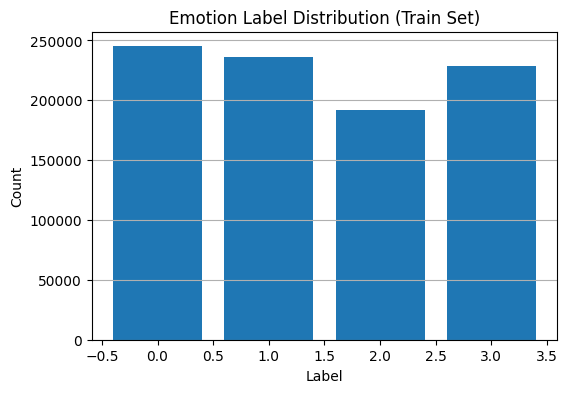

In [10]:
import numpy as np
import glob
import os
from collections import Counter
import matplotlib.pyplot as plt

# 라벨 배치 파일 경로 설정
label_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 전체 라벨 수집
all_labels = []

for file in label_files:
    labels = np.load(file, allow_pickle=True)
    all_labels.extend(labels.tolist())

# 라벨 분포 확인
label_counts = Counter(all_labels)
print("라벨 분포:", label_counts)

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Emotion Label Distribution (Train Set)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


# 감정 클래스 불균형 확인 코드

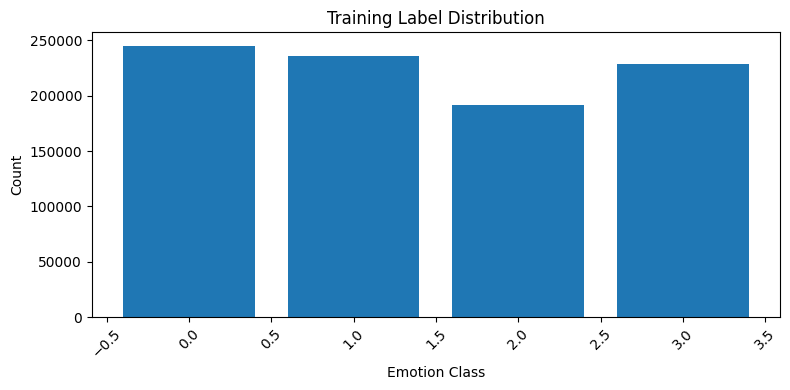

In [1]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from collections import Counter

# 라벨 배치 경로
label_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

# 모든 라벨 로딩
all_labels = []
for file in label_files:
    labels = np.load(file, allow_pickle=True)
    all_labels.extend(labels)

# 라벨 분포 확인
label_counter = Counter(all_labels)

# 시각화
plt.figure(figsize=(8, 4))
plt.bar(label_counter.keys(), label_counter.values())
plt.title("Training Label Distribution")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- class_weight 적용

- 증강 재조정

- 또는 RandomUnderSampler, SMOTE 등 대안 고려

## 1. class-weight 적용
- 클래스 불균형 문제를 완화하기 위해 각 클래스에 역비례 가중치를 적용할 수 있습니다. 아래는 전체 라벨을 분석하고 class_weight을 자동으로 계산하는 코드

In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 전체 라벨을 숫자로 인코딩한 리스트라고 가정 (예: [0, 1, 0, 2, 3, 1, ...])
all_labels_array = np.array(all_labels)

# 고유 클래스 목록
classes = np.unique(all_labels_array)

# 클래스 가중치 계산
weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels_array)
class_weights = dict(zip(classes, weights))

print("적용할 class_weight:", class_weights)


적용할 class_weight: {0: 0.9201513463210355, 1: 0.9562384679009989, 2: 1.17415625, 3: 0.9844626107006236}


## 2. 모델 학습 코드 개선
- 지금까지 개선사항을 반영하여, 각 셀에 맞게 구성해드립니다. (class_weight 적용 포함)

### 셀 1. 환경 및 경로 설정

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import glob
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# GPU 메모리 점진적 할당
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 하이퍼파라미터
BATCH_SIZE = 64
EPOCHS = 300
PATIENCE = 30

# 경로 설정
train_dir = "/media/usou/PortableSSD/mldl_project/data4class_batches"
val_dir = "/media/usou/PortableSSD/mldl_project/data4class_val_batches"
checkpoint_path = "/media/usou/PortableSSD/mldl_project/model_ckpt/best_model_voice_emotion_analysis.keras"


2025-04-03 23:59:16.882290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743692356.950121   44334 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743692356.973294   44334 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743692357.116733   44334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743692357.116793   44334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743692357.116796   44334 computation_placer.cc:177] computation placer alr

### 셀 2. CNN 모델 정의

In [4]:
def build_cnn_model(input_shape=(40, 300, 1), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model()


/home/usou/dev_ws/superbad/deeplearning-repo-3/dolbom_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-03 23:59:22.700145: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743692362.700595   44334 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4738 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


### 셀 3. 데이터 제너레이터 및 클래스 가중치 계산

In [5]:
def data_generator(mfcc_dir, label_dir, batch_size):
    mfcc_files = sorted(glob.glob(os.path.join(mfcc_dir, "mfcc_batch_*.npy")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "label_batch_*.npy")))

    while True:
        for mfcc_file, label_file in zip(mfcc_files, label_files):
            x = np.load(mfcc_file)
            y = np.load(label_file, allow_pickle=True)

            min_len = min(len(x), len(y))
            x = x[:min_len][..., np.newaxis]
            y = y[:min_len]

            for i in range(0, min_len, batch_size):
                yield x[i:i+batch_size], y[i:i+batch_size]

# 전체 라벨을 모아서 class_weight 계산
all_labels = []
for f in glob.glob(os.path.join(train_dir, "label_batch_*.npy")):
    labels = np.load(f, allow_pickle=True)
    all_labels.extend(labels)

classes = np.unique(all_labels)
weights = compute_class_weight('balanced', classes=classes, y=all_labels)
class_weights = dict(zip(classes, weights))

print("적용할 클래스 가중치:", class_weights)


적용할 클래스 가중치: {0: 0.9201513463210355, 1: 0.9562384679009989, 2: 1.17415625, 3: 0.9844626107006236}


### 셀 4. 검증 데이터 로딩

In [8]:
import glob
import os
import numpy as np

# 검증 데이터 배치 파일 목록
val_mfcc_files = sorted(glob.glob(os.path.join(val_dir, "mfcc_val_batch_*.npy")))
val_label_files = sorted(glob.glob(os.path.join(val_dir, "label_val_batch_*.npy")))

# 최대 로딩할 샘플 수 제한 (예: 5000개)
max_samples = 5000
loaded = 0

val_x_list, val_y_list = [], []

for mfcc_file, label_file in zip(val_mfcc_files, val_label_files):
    # 각 배치 파일 로딩
    x = np.load(mfcc_file)[..., np.newaxis]  # (배치, 40, 300, 1)
    y = np.load(label_file, allow_pickle=True)

    # 남은 개수 계산 후 일부만 사용 (과도한 메모리 사용 방지)
    remaining = max_samples - loaded
    if len(x) > remaining:
        x = x[:remaining]
        y = y[:remaining]

    val_x_list.append(x)
    val_y_list.append(y)
    loaded += len(x)

    if loaded >= max_samples:
        break

# 최종 배열로 병합
val_x = np.concatenate(val_x_list, axis=0)
val_y = np.concatenate(val_y_list, axis=0)

print("검증 데이터 shape:", val_x.shape, val_y.shape)


검증 데이터 shape: (5000, 40, 300, 1) (5000,)


In [10]:
# 문자열을 숫자로 매핑 (예: 감정 레이블이 str인 경우)
if val_y.dtype.type is np.str_ or val_y.dtype.type is np.object_:
    unique_labels = sorted(set(val_y))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    val_y = np.array([label_to_index[label] for label in val_y])


TypeError: '<' not supported between instances of 'str' and 'int'

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(val_y)
class_weights = dict(enumerate(compute_class_weight('balanced', classes=classes, y=val_y)))


TypeError: '<' not supported between instances of 'str' and 'int'

In [6]:
import numpy as np
import glob
import os
from sklearn.utils.class_weight import compute_class_weight

# 검증 라벨 배치 파일 경로
val_label_files = sorted(glob.glob(os.path.join(val_dir, "label_val_batch_*.npy")))

# 클래스 가중치 계산용 라벨만 메모리에 점진적으로 로딩
val_labels = []

for label_file in val_label_files:
    y = np.load(label_file, allow_pickle=True)
    val_labels.extend(y)

val_y_raw = np.array(val_labels)

# 문자열 라벨이면 숫자 인덱스로 인코딩
if val_y_raw.dtype.type is np.str_ or val_y_raw.dtype.type is np.object_:
    unique_labels = sorted(set(val_y_raw))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    val_y = np.array([label_to_index[label] for label in val_y_raw])
else:
    val_y = val_y_raw.copy()

# 클래스 가중치 계산
classes = np.unique(val_y)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=classes, y=val_y)))

# 결과 출력
print("클래스 가중치:", class_weights)


클래스 가중치: {0: 25.048666666666666, 1: 2.087388888888889, 2: 0.6288341889782888, 3: 0.8134664826391708, 4: 0.8491073446327684, 5: 0.6739672460492565}


In [22]:
import tensorflow as tf
import numpy as np
import glob
import os

def val_data_generator(val_mfcc_dir, val_label_dir, batch_size):
    """
    검증 데이터를 배치 단위로 불러오는 제너레이터 함수입니다.
    - 메모리 이슈를 피하기 위해 배치 단위로 불러옵니다.
    
    Parameters:
        val_mfcc_dir (str): MFCC 검증 배치 파일 경로
        val_label_dir (str): 라벨 검증 배치 파일 경로
        batch_size (int): 배치 크기

    Yields:
        Tuple[np.ndarray, np.ndarray]: (x_batch, y_batch)
    """
    mfcc_files = sorted(glob.glob(os.path.join(val_mfcc_dir, "mfcc_val_batch_*.npy")))
    label_files = sorted(glob.glob(os.path.join(val_label_dir, "label_val_batch_*.npy")))

    while True:
        for mfcc_file, label_file in zip(mfcc_files, label_files):
            x = np.load(mfcc_file)[..., np.newaxis]  # (batch, 40, 300, 1)
            y_raw = np.load(label_file, allow_pickle=True)

            # 문자열 레이블이면 숫자로 변환
            if y_raw.dtype.type is np.str_ or y_raw.dtype.type is np.object_:
                unique_labels = sorted(set(y_raw))
                label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
                y = np.array([label_to_index[label] for label in y_raw])
            else:
                y = y_raw.copy()

            min_len = min(len(x), len(y))
            x = x[:min_len]
            y = y[:min_len]

            for i in range(0, min_len, batch_size):
                yield x[i:i+batch_size], y[i:i+batch_size]


In [23]:
# 검증 제너레이터 인스턴스 생성
val_generator = val_data_generator(val_dir, val_dir, BATCH_SIZE)


In [24]:
# 검증 제너레이터 인스턴스 생성
val_generator = val_data_generator(val_dir, val_dir, BATCH_SIZE)

# 학습 스텝 수 계산 (전체 학습 샘플 수 / 배치 크기)
train_steps = sum([
    np.load(f).shape[0]
    for f in glob.glob(os.path.join(train_dir, "label_batch_*.npy"))
]) // BATCH_SIZE

# 검증 스텝 수 계산 (전체 검증 샘플 수 / 배치 크기)
val_steps = sum([
    np.load(f, allow_pickle=True).shape[0]
    for f in glob.glob(os.path.join(val_dir, "label_val_batch_*.npy"))
]) // BATCH_SIZE

# 콜백 정의
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=PATIENCE,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True
    )
]

# 모델 학습 실행
history = model.fit(
    data_generator(train_dir, train_dir, BATCH_SIZE),  # 학습용 제너레이터
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,                    # 검증용 제너레이터
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weights                        # 클래스 가중치 적용
)


ValueError: Argument `class_weight` is not supported for Python generator inputs. Received: class_weight={0: 25.048666666666666, 1: 2.087388888888889, 2: 0.6288341889782888, 3: 0.8134664826391708, 4: 0.8491073446327684, 5: 0.6739672460492565}

- 오류의 원인은 class_weight 인자는 Python 제너레이터 기반 입력에 사용할 수 없기 때문

In [1]:
import os
import json
import pandas as pd

# 설정
json_dir = "/media/usou/PortableSSD/mldl_project/json_data"
output_csv_path = "./data/usou/metadata_4class.csv"
target_emotions = {"angry", "happy", "neutrality", "sad"}

data = []
for root, _, files in os.walk(json_dir):
    for fname in files:
        if fname.endswith(".json"):
            with open(os.path.join(root, fname), "r", encoding="utf-8") as f:
                content = json.load(f)
                if content["emotion"] in target_emotions:
                    data.append({"wav_path": content["wav_path"], "emotion": content["emotion"]})

df = pd.DataFrame(data)
df.to_csv(output_csv_path, index=False)
print(f"✅ 4클래스 필터링 완료: {len(df)}개 → {output_csv_path}")


✅ 4클래스 필터링 완료: 0개 → ./data/usou/metadata_4class.csv


## class_weight 효과를 반영한 데이터 오버샘플링 진행

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from collections import Counter
from sklearn.utils import resample
from tqdm import tqdm

# 1. 경로 설정
csv_path = "./data/usou/metadata_4class.csv"
output_dir = "/media/usou/PortableSSD/mldl_project/data4class_oversampled_batches"
os.makedirs(output_dir, exist_ok=True)

# 2. MFCC 설정
n_mfcc = 40
max_len = 300
batch_size = 1000

# 3. 데이터 불러오기
df = pd.read_csv(csv_path)

# 4. 클래스별 분포 확인
label_counts = df['emotion'].value_counts()
max_count = label_counts.max()

# 5. 오버샘플링 수행
oversampled_df = pd.DataFrame()

for emotion, group in df.groupby('emotion'):
    # 클래스별로 최대 수만큼 오버샘플링
    group_oversampled = resample(group, replace=True, n_samples=max_count, random_state=42)
    oversampled_df = pd.concat([oversampled_df, group_oversampled])

# 6. MFCC 추출 함수
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

# 7. 배치 저장
mfcc_batch = []
label_batch = []
batch_index = 0

for _, row in tqdm(oversampled_df.iterrows(), total=len(oversampled_df), desc="오버샘플링된 MFCC 추출"):
    try:
        y, sr = librosa.load(row["wav_path"], sr=16000)
        mfcc = extract_mfcc(y, sr)
        mfcc_batch.append(mfcc)
        label_batch.append(row["emotion"])

        if len(mfcc_batch) >= batch_size:
            np.save(os.path.join(output_dir, f"mfcc_batch_{batch_index}.npy"), np.array(mfcc_batch))
            np.save(os.path.join(output_dir, f"label_batch_{batch_index}.npy"), np.array(label_batch, dtype=object))
            print(f"배치 {batch_index} 저장 완료 - {len(mfcc_batch)}개")
            batch_index += 1
            mfcc_batch.clear()
            label_batch.clear()

    except Exception as e:
        print(f"오류: {row['wav_path']} → {e}")
        continue

# 8. 마지막 배치 저장
if mfcc_batch:
    np.save(os.path.join(output_dir, f"mfcc_batch_{batch_index}.npy"), np.array(mfcc_batch))
    np.save(os.path.join(output_dir, f"label_batch_{batch_index}.npy"), np.array(label_batch, dtype=object))
    print(f"마지막 배치 {batch_index} 저장 완료 - {len(mfcc_batch)}개")

print("오버샘플링 기반 MFCC 추출 완료")


/tmp/ipykernel_5428/2753053002.py:20: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
오버샘플링된 MFCC 추출:   0%|          | 12/326668 [00:01<12:16:51,  7.39it/s]


KeyboardInterrupt: 

# 라벨 인코딩

In [2]:
import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from glob import glob
from tqdm import tqdm

# 1. 경로 설정
label_path = "/media/usou/PortableSSD/mldl_project/data4class_oversampled_batches/label_batch_*.npy"
save_dir = "/media/usou/PortableSSD/mldl_project/models"
os.makedirs(save_dir, exist_ok=True)

# 2. 전체 라벨 수집
all_labels = []
for label_file in tqdm(sorted(glob(label_path)), desc="전체 라벨 로딩"):
    labels = np.load(label_file, allow_pickle=True)
    all_labels.extend(labels)

# 3. 라벨 인코더 학습 및 저장
le = LabelEncoder()
le.fit(all_labels)

encoder_path = os.path.join(save_dir, "label_encoder_4class.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(le, f)

print("✅ LabelEncoder 학습 및 저장 완료:", encoder_path)
print("클래스 목록:", le.classes_)


전체 라벨 로딩:   0%|          | 0/327 [00:00<?, ?it/s]

전체 라벨 로딩: 100%|██████████| 327/327 [00:01<00:00, 321.24it/s]


✅ LabelEncoder 학습 및 저장 완료: /media/usou/PortableSSD/mldl_project/models/label_encoder_4class.pkl
클래스 목록: ['Angry' 'Happy' 'Neutrality' 'Sad']


## 배치 제너레이터 정의 

In [3]:
import numpy as np
import os
import pickle
from tensorflow.keras.utils import Sequence

class MFCCBatchGenerator(Sequence):
    def __init__(self, data_dir, encoder_path, batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle

        # 파일 목록
        self.mfcc_files = sorted([f for f in os.listdir(data_dir) if f.startswith("mfcc_batch_")])
        self.label_files = sorted([f for f in os.listdir(data_dir) if f.startswith("label_batch_")])
        self.indexes = np.arange(len(self.mfcc_files))

        # 라벨 인코더 로드
        with open(encoder_path, "rb") as f:
            self.encoder = pickle.load(f)

        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        i = self.indexes[idx]
        mfcc_path = os.path.join(self.data_dir, self.mfcc_files[i])
        label_path = os.path.join(self.data_dir, self.label_files[i])

        X = np.load(mfcc_path)
        y = np.load(label_path, allow_pickle=True)
        y_encoded = self.encoder.transform(y)

        return X[..., np.newaxis], y_encoded

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


2025-04-04 17:24:28.947118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743755068.995799    5428 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743755069.009420    5428 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743755069.127231    5428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743755069.127250    5428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743755069.127251    5428 computation_placer.cc:177] computation placer alr

: 

## 모델 구조 추천 (성능 좋은 CNN 기반)
- 기존보다 조금 더 깊고, BatchNormalization, Dropout 등을 넣어서 일반화 성능을 높이는 구조입니다.

- 커널 과부하를 막기 위해 파라미터 수를 100만 이하로 제한했습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape=(40, 300, 1), num_classes=4):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# 학습 

In [20]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

# 경로 설정
train_data_dir = "/media/usou/PortableSSD/mldl_project/data4class_oversampled_batches"
model_save_path = "./ai/models/voice_emotion_model_4class.keras"
history_save_path = "./ai/models/history_4class.pkl"

# 배치 제너레이터 생성
train_generator = MFCCBatchGenerator(data_dir=train_data_dir, batch_size=64, shuffle=True)

# 모델 빌드
model = build_cnn_model(input_shape=(40, 300, 1), num_classes=4)

# 콜백 설정
callbacks = [
    EarlyStopping(monitor='loss', patience=60, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_save_path, monitor='loss', save_best_only=True, verbose=1)
]

# 학습
history = model.fit(
    train_generator,
    epochs=300,
    callbacks=callbacks,
    verbose=1
)

# 학습 이력 저장
with open(history_save_path, "wb") as f:
    pickle.dump(history.history, f)

print("✅ 학습 완료 및 모델/이력 저장 완료")


TypeError: MFCCBatchGenerator.__init__() missing 1 required positional argument: 'encoder_path'

# 다시 시작 
# JSON -> DataFrame 변환(4개 감정만 필터링)

In [2]:
import os
import json
import pandas as pd
from tqdm import tqdm

# 사용할 감정 4종
target_emotions = {"neutral", "angry", "happy", "sad"}

# JSON 및 WAV 최상위 경로
label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/라벨링데이터/"
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/1.Training/원천데이터/"

# 결과 저장 경로: 외장 하드 mldl_4class 폴더
save_dir = "/media/usou/PortableSSD/mldl_4class"
os.makedirs(save_dir, exist_ok=True)

# 데이터 수집 리스트
data = []
broken_files = []

# JSON 탐색 및 처리
for folder_path, _, files in tqdm(os.walk(label_root), desc="JSON 파일 탐색"):
    for file_name in files:
        if file_name.endswith(".json"):
            json_path = os.path.join(folder_path, file_name)
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                emotion = content["화자정보"]["Emotion"]
                if emotion.lower() not in target_emotions:
                    continue

                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")
                wav_file = content["파일정보"]["FileName"]

                relative_path = os.path.relpath(folder_path, start=label_root).replace("TL", "TS")
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                if os.path.exists(wav_path):
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion.lower(),
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    print(f"[WAV 없음] {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                print(f"[JSON 오류] {json_path}: {e}")
                broken_files.append(json_path)

# DataFrame 저장
df = pd.DataFrame(data)
df.to_csv(os.path.join(save_dir, "metadata_cleaned.csv"), index=False)

# 오류 로그 저장
with open(os.path.join(save_dir, "broken_files.txt"), "w") as f:
    for path in broken_files:
        f.write(path + "\n")

print(f"✅ 정상 처리된 데이터 수: {len(df)}")
print(f"⚠️ 오류 수: {len(broken_files)}")


JSON 파일 탐색: 449it [02:39,  2.82it/s]


✅ 정상 처리된 데이터 수: 236584
⚠️ 오류 수: 0


# MFCC 추출

In [3]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# ============================
# 1. 메타데이터 로드 및 클래스 균형 맞춤
# ============================
csv_path = "/media/usou/PortableSSD/mldl_4class/metadata_cleaned.csv"
df = pd.read_csv(csv_path)

# 클래스별 개수 파악
min_class_count = df['emotion'].value_counts().min()

# 클래스별 균형 맞춤
balanced_df = df.groupby('emotion', group_keys=False).apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)

print("각 클래스 균형 샘플 수:", min_class_count)

# ============================
# 2. 설정값 정의
# ============================
sample_rate = 16000
max_duration = 5.0
save_interval = 10000

# 저장 디렉토리
save_dir = "/media/usou/PortableSSD/mldl_4class/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# ============================
# 3. MFCC 추출 루프 (제너레이터 스타일)
# ============================
mfcc_features = []
labels = []
error_files = []
save_counter = 0

for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df), desc="MFCC 추출 중"):
    wav_path = row["wav_path"]
    try:
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])
    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 남은 데이터 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ============================
# 4. 에러 로그 저장
# ============================
error_path = "/media/usou/PortableSSD/mldl_4class/broken_audio_files.txt"
with open(error_path, "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ============================
# 5. 요약 출력
# ============================
print(f"✅ 저장된 MFCC 배치 수: {save_counter + 1}")
print(f"⚠️ 실패한 파일 수: {len(error_files)}")


/tmp/ipykernel_5551/4277833996.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/tmp/ipykernel_5551/4277833996.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('emotion', group_keys=False).apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)


각 클래스 균형 샘플 수: 76332


MFCC 추출 중: 100%|██████████| 228996/228996 [44:48<00:00, 85.17it/s] 

✅ 저장된 MFCC 배치 수: 23
⚠️ 실패한 파일 수: 0


# 레이블 인코딩(Train 데이터)

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

# ===============================
# 1. 메타데이터 로드
# ===============================
csv_path = "/media/usou/PortableSSD/mldl_4class/metadata_cleaned.csv"
df = pd.read_csv(csv_path)

# ===============================
# 2. 레이블 인코딩
# ===============================
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df["emotion"])  # 'happy' → 0, ...

# ===============================
# 3. 인코더 저장 (나중에 검증 데이터에 동일하게 적용)
# ===============================
encoder_path = "./label_encoder.pkl"  # 현재 코드 폴더에 저장
with open(encoder_path, "wb") as f:
    pickle.dump(encoder, f)

# ===============================
# 4. 라벨을 MFCC 배치 기준으로 분리 저장
# ===============================

# 학습 데이터의 MFCC 배치 수 확인
mfcc_dir = "/media/usou/PortableSSD/mldl_4class/mfcc_batches"
mfcc_batches = sorted([f for f in os.listdir(mfcc_dir) if f.startswith("mfcc_batch")])
label_save_dir = os.path.join(mfcc_dir, "encoded_labels")
os.makedirs(label_save_dir, exist_ok=True)

start_idx = 0
for i, batch_name in enumerate(mfcc_batches):
    mfcc_path = os.path.join(mfcc_dir, batch_name)
    batch_mfcc = np.load(mfcc_path, allow_pickle=True)
    end_idx = start_idx + len(batch_mfcc)
    batch_labels = encoded_labels[start_idx:end_idx]
    
    # 저장
    np.save(os.path.join(label_save_dir, f"label_batch_{i}.npy"), batch_labels)
    start_idx = end_idx

print("✅ 레이블 인코딩 완료 및 저장")
print("📦 저장 경로:", label_save_dir)


/tmp/ipykernel_5551/2700387088.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ 레이블 인코딩 완료 및 저장
📦 저장 경로: /media/usou/PortableSSD/mldl_4class/mfcc_batches/encoded_labels


## Validation 전처리 (Train 과 동일)

In [5]:
import os
import json
import pandas as pd
from tqdm import tqdm

# ========================================
# 1. 경로 설정
# ========================================

label_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/라벨링데이터/VL1"
wav_root = "/media/usou/PortableSSD/mldl/015.감성 및 발화 스타일별 음성합성 데이터/01.데이터/2.Validation/원천데이터/VS1"
save_dir = "/media/usou/PortableSSD/mldl_4class/validation"
os.makedirs(save_dir, exist_ok=True)

# ========================================
# 2. 필터링 감정 정의 및 리스트 초기화
# ========================================

target_emotions = {"neutral", "angry", "happy", "sad"}
data = []
broken_files = []

# ========================================
# 3. JSON 탐색 및 필터링 처리
# ========================================

for folder_path, _, files in tqdm(os.walk(label_root), desc="Validation JSON 탐색"):
    for file_name in files:
        if file_name.endswith(".json"):
            json_path = os.path.join(folder_path, file_name)
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    content = json.load(f)

                emotion = content["화자정보"]["Emotion"].lower()
                if emotion not in target_emotions:
                    continue

                style = content["화자정보"].get("SpeechStyle", "N/A")
                sensitivity = content["화자정보"].get("Sensitivity", "N/A")
                wav_file = content["파일정보"]["FileName"]

                relative_path = os.path.relpath(folder_path, start=label_root)
                wav_path = os.path.join(wav_root, relative_path, wav_file)

                if os.path.exists(wav_path):
                    data.append({
                        "wav_path": wav_path,
                        "emotion": emotion,
                        "style": style,
                        "sensitivity": sensitivity
                    })
                else:
                    print(f"WAV 파일 없음: {wav_path}")
                    broken_files.append(wav_path)

            except Exception as e:
                print(f"JSON 읽기 오류: {json_path}, 에러: {e}")
                broken_files.append(json_path)

# ========================================
# 4. 결과 저장
# ========================================

df = pd.DataFrame(data)
df.to_csv(os.path.join(save_dir, "metadata_cleaned_val.csv"), index=False)

with open(os.path.join(save_dir, "broken_val_files.txt"), "w") as f:
    for path in broken_files:
        f.write(path + "\n")

print(f"✅ Validation 데이터 수: {len(df)}")
print(f"⚠️ 오류 파일 수: {len(broken_files)}")


Validation JSON 탐색: 0it [00:00, ?it/s]

Validation JSON 탐색: 88it [00:05, 15.21it/s]


✅ Validation 데이터 수: 36207
⚠️ 오류 파일 수: 0


## MFCC 추출 (Validation용, 클래스 불균형 조정 없이 전체 추출)

In [6]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

# ========================================
# 1. 메타데이터 로드
# ========================================

csv_path = "/media/usou/PortableSSD/mldl_4class/validation/metadata_cleaned_val.csv"
df = pd.read_csv(csv_path)

# ========================================
# 2. 설정값 정의
# ========================================

sample_rate = 16000
max_duration = 5.0
save_interval = 10000

# 저장 디렉토리
save_dir = "/media/usou/PortableSSD/mldl_4class/validation/mfcc_batches"
os.makedirs(save_dir, exist_ok=True)

# ========================================
# 3. MFCC 추출 루프 (제너레이터 방식)
# ========================================

mfcc_features = []
labels = []
error_files = []
save_counter = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc="MFCC 추출 중 (Validation)"):
    wav_path = row["wav_path"]
    try:
        y, sr = librosa.load(wav_path, sr=sample_rate, duration=max_duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_features.append(mfcc.T)
        labels.append(row["emotion"])
    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        error_files.append(wav_path)

    if len(mfcc_features) >= save_interval:
        np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
        np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))
        save_counter += 1
        mfcc_features = []
        labels = []

# 남은 데이터 저장
if mfcc_features:
    np.save(os.path.join(save_dir, f"mfcc_batch_{save_counter}.npy"), np.array(mfcc_features, dtype=object))
    np.save(os.path.join(save_dir, f"label_batch_{save_counter}.npy"), np.array(labels))

# ========================================
# 4. 에러 로그 저장
# ========================================

with open("/media/usou/PortableSSD/mldl_4class/validation/broken_audio_val.txt", "w") as f:
    for path in error_files:
        f.write(path + "\n")

# ========================================
# 5. 결과 출력
# ========================================

print(f"✅ 저장된 MFCC 배치 수: {save_counter + 1}")
print(f"⚠️ 실패한 파일 수: {len(error_files)}")


MFCC 추출 중 (Validation): 100%|██████████| 36207/36207 [10:14<00:00, 58.88it/s]


✅ 저장된 MFCC 배치 수: 4
⚠️ 실패한 파일 수: 0


# Validation 레이블 인코딩 (학습용 인코더 재사용)

In [8]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

# ========================================
# 1. LabelEncoder 로드
# ========================================
encoder_path = "./label_encoder.pkl"  # Train 3번 셀에서 저장한 인코더
with open(encoder_path, "rb") as f:
    encoder = pickle.load(f)

# ========================================
# 2. Validation 메타데이터 로드
# ========================================
csv_path = "/media/usou/PortableSSD/mldl_4class/validation/metadata_cleaned_val.csv"
df = pd.read_csv(csv_path)

# ========================================
# 3. 레이블 인코딩 적용
# ========================================
encoded_labels = encoder.transform(df["emotion"])

# ========================================
# 4. MFCC 배치 기준으로 라벨 분리 저장
# ========================================
mfcc_dir = "/media/usou/PortableSSD/mldl_4class/validation/mfcc_batches"
mfcc_batches = sorted([f for f in os.listdir(mfcc_dir) if f.startswith("mfcc_batch")])
label_save_dir = os.path.join(mfcc_dir, "encoded_labels")
os.makedirs(label_save_dir, exist_ok=True)

start_idx = 0
for i, batch_name in enumerate(mfcc_batches):
    mfcc_path = os.path.join(mfcc_dir, batch_name)
    batch_mfcc = np.load(mfcc_path, allow_pickle=True)
    end_idx = start_idx + len(batch_mfcc)
    batch_labels = encoded_labels[start_idx:end_idx]
    
    # 저장
    np.save(os.path.join(label_save_dir, f"label_batch_{i}.npy"), batch_labels)
    start_idx = end_idx

print("✅ Validation 라벨 인코딩 완료 및 저장")
print("📦 저장 경로:", label_save_dir)


✅ Validation 라벨 인코딩 완료 및 저장
📦 저장 경로: /media/usou/PortableSSD/mldl_4class/validation/mfcc_batches/encoded_labels


## CNN 모델 정의 (TensorFlow)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# GPU 메모리 점진 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def build_cnn_model(input_shape=(40, 100, 1), num_classes=4):  # ← 줄인 입력
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 모델 인스턴스 생성
model = build_cnn_model(input_shape=(40, 100, 1), num_classes=4)
model.summary()


2025-04-04 22:04:02.463416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743771842.481758   21737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743771842.487580   21737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743771842.501105   21737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743771842.501129   21737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743771842.501130   21737 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,077,252 (4.11 MB)

 Trainable params: 1,076,804 (4.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
import os
import numpy as np
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence

# =============================
# 1. 제너레이터 정의 (샘플 개수 맞춤 처리 포함)
# =============================
class MFCCGenerator(Sequence):
    def __init__(self, mfcc_dir, label_dir, batch_size=32):
        self.mfcc_paths = sorted([os.path.join(mfcc_dir, f) for f in os.listdir(mfcc_dir) if f.startswith("mfcc_batch")])
        self.label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.startswith("label_batch")])
        self.batch_size = batch_size

    def __len__(self):
        return len(self.mfcc_paths)

    def __getitem__(self, idx):
        x = np.load(self.mfcc_paths[idx], allow_pickle=True)
        y = np.load(self.label_paths[idx])

        # 오류 방지: 길이 맞춤
        min_len = min(len(x), len(y))
        x = x[:min_len]
        y = y[:min_len]

        # Padding & Shape 변환
        x = np.stack([
            np.pad(sample, ((0, max(0, 40 - sample.shape[0])), (0, 0)), mode='constant')[:40]
            for sample in x
        ])
        x = np.transpose(x, (0, 2, 1))            # (batch, 13, 40)
        x = x[..., np.newaxis]                    # (batch, 13, 40, 1)
        x = np.transpose(x, (0, 2, 1, 3))         # → (batch, 40, 13, 1)
        return x, y

# =============================
# 2. 경로 설정
# =============================
train_mfcc_dir = "/media/usou/PortableSSD/mldl_4class/mfcc_batches"
train_label_dir = os.path.join(train_mfcc_dir, "encoded_labels")

val_mfcc_dir = "/media/usou/PortableSSD/mldl_4class/validation/mfcc_batches"
val_label_dir = os.path.join(val_mfcc_dir, "encoded_labels")

# =============================
# 3. 제너레이터 준비
# =============================
train_gen = MFCCGenerator(train_mfcc_dir, train_label_dir, batch_size=32)
val_gen = MFCCGenerator(val_mfcc_dir, val_label_dir, batch_size=32)

# =============================
# 4. 모델 불러오기 (4번 셀에서 정의된 함수 사용)
# =============================
model = build_cnn_model(input_shape=(40, 13, 1), num_classes=4)

# =============================
# 5. 콜백 설정
# =============================
callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint("voice_emotion_analyze.h5", save_best_only=True, monitor='val_loss')
]

# =============================
# 6. 학습 실행
# =============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=300,
    callbacks=callbacks
)

# =============================
# 7. 학습 기록 저장 (.pkl)
# =============================
with open("voice_emotion_analyze_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ 학습 완료 및 저장됨")


Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2027 - loss: 3.1182

23/23 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.2051 - loss: 3.0772 - val_accuracy: 0.3149 - val_loss: 1.2610
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.3663 - loss: 1.1645 - val_accuracy: 0.3414 - val_loss: 1.3809
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3615 - loss: 1.1496

23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.3599 - loss: 1.1505 - val_accuracy: 0.3349 - val_loss: 1.1638
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3368 - loss: 1.1462

23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.3373 - loss: 1.1459 - val_accuracy: 0.2621 - val_loss: 1.1333
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.3099 - loss: 1.1686 - val_accuracy: 0.2642 - val_loss: 1.1390
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4517 - loss: 1.1090

23/23 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.4465 - loss: 1.1123 - val_accuracy: 0.3261 - val_loss: 1.1330
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2651 - loss: 1.1654

23/23 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.2664 - loss: 1.1652 - val_accuracy: 0.2822 - val_loss: 1.1324
Epoch 8/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3532 - loss: 1.1339

23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3524 - loss: 1.1342 - val_accuracy: 0.2450 - val_loss: 1.1249
Epoch 9/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3006 - loss: 1.1394 - val_accuracy: 0.3115 - val_loss: 1.1345
Epoch 10/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.4110 - loss: 1.0952 - val_accuracy: 0.1949 - val_loss: 1.1297
Epoch 11/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3814 - loss: 1.1115 - val_accuracy: 0.1884 - val_loss: 1.1356
Epoch 12/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3903 - loss: 1.1074 - val_accuracy: 0.2793 - val_loss: 1.1410
Epoch 13/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.3617 - loss: 1.1145 - val_accuracy: 0.2570 - val_loss: 1.1457
Epoch 14/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3680 - loss: 1.1364

23/23 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.3656 - loss: 1.1376 - val_accuracy: 0.2433 - val_loss: 1.1226
Epoch 15/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3630 - loss: 1.1103

23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3618 - loss: 1.1107 - val_accuracy: 0.3411 - val_loss: 1.1187
Epoch 16/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3613 - loss: 1.1172 - val_accuracy: 0.3214 - val_loss: 1.1275
Epoch 17/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3556 - loss: 1.1164 - val_accuracy: 0.3163 - val_loss: 1.1356
Epoch 18/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.3601 - loss: 1.1171 - val_accuracy: 0.2519 - val_loss: 1.1342
Epoch 19/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.3586 - loss: 1.1072 - val_accuracy: 0.3008 - val_loss: 1.1405
Epoch 20/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3168 - loss: 1.1444 - val_accuracy: 0.2285 - val_loss: 1.1235
Epoch 21/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3062 - loss: 1.1207 - val_accuracy: 0.2825 - val_loss: 1.1190
Epoch 22/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.3809 - loss: 1.1091 - val_accuracy: 0.2540 

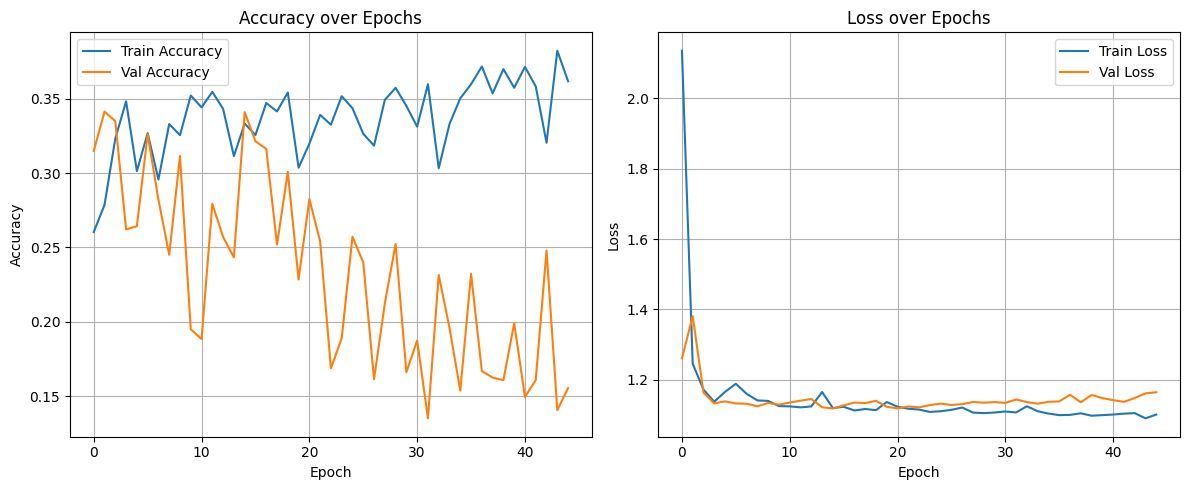

In [6]:
import pickle
import matplotlib.pyplot as plt

# ================================
# 1. history 로드
# ================================
with open("voice_emotion_analyze_history.pkl", "rb") as f:
    history = pickle.load(f)

# ================================
# 2. 시각화
# ================================
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 성능 개선 CNN + LSTM 모델 정의

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# GPU 메모리 점진 할당 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def build_cnn_lstm_model(input_shape=(40, 13, 1), num_classes=4):
    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = TimeDistributed(Flatten())(x)  # (batch, time_steps, features)

    # LSTM block
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 모델 생성
model = build_cnn_lstm_model()
model.summary()


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 40, 13, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 40, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 192)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,252 (333.02 KB)

 Trainable params: 85,060 (332.27 KB)

 Non-trainable params: 192 (768.00 B)